# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from GAN.cGANGenerator import Generator
from GAN.cGANDiscriminator import Discriminator
from GAN.data_preprocess import load_image_train, load_image_test, load_image_test_y
from tempfile import TemporaryFile
from scipy.io import loadmat, savemat #Handling Matlab File
import datetime # Time 
import h5py #store huge amounts of numerical data
import hdf5storage #Save a dictionary of python types to a MATLAB file
import skfuzzy as fuzz


# GPU Setting Parallel Computing

In [2]:
# GPU Setting
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.enable_eager_execution(config=config)
layers = tf.keras.layers

# Importing Data

In [4]:
# data path
path = "Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat"

# Initializing Perameters

In [5]:
# batch = 1 produces good results on U-NET
BATCH_SIZE = 1              

In [6]:
# model
generator = Generator()
discriminator = Discriminator()

In [7]:
# optimizer
generator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.compat.v1.train.RMSPropOptimizer(2e-5)
#discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)

# Discriminator loss:

The discriminator loss function takes 2 inputs; 
1. Real images 
2. Generated images

#### real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since the real images)

#### generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since the fake images)

Then the total_loss is the sum of real_loss and the generated_loss

# Discriminator_loss

In [8]:
def discriminator_loss(disc_real_output, disc_generated_output):
    """disc_real_output = [real_target]
       disc_generated_output = [generated_target]
    """
    
    
    
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_real_output), logits=disc_real_output)  # Real as label=1
    
    
    
    
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(disc_generated_output), logits=disc_generated_output)  # Fake as label=0
    
    
    
    
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return total_disc_loss

# Generator loss:

It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L2 loss between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.



The formula to calculate the total generator loss = gan_loss + LAMBDA * l2_loss, where LAMBDA = 100. 
This value was decided by the authors of the paper.


# Generator_loss

In [9]:
def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):
    """
        disc_generated_output: output of Discriminator when input is from Generator
        gen_output:  output of Generator (i.e., estimated H)
        target:  target image
        l2_weight: weight of L2 loss
    """
    
    
    
    
    # GAN loss
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc_generated_output), logits=disc_generated_output)
    
    
    
    
    # L2 loss - MSE, Mean Square Error
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    
    
    total_gen_loss = tf.reduce_mean(gen_loss) + l2_weight * l2_loss
    return total_gen_loss


# Generting Result Images 

In [10]:
def generated_image(model, test_input, tar, t=0):
    
    
    """Dispaly  the results of Generator"""
    
    
    prediction = model(test_input)
    #plt.figure(figsize=(15, 15))
    display_list = [np.squeeze(test_input[:,:,:,0]), np.squeeze(tar[:,:,:,0]), np.squeeze(prediction[:,:,:,0])]
    

    title = ['Input Y', 'Target H', 'Prediction H']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]) 
        plt.axis("off")
    plt.savefig(os.path.join("generated_img", "img_"+str(t)+".png"))


# Training Model

In [11]:
def train_step(input_image, target):
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)                      # input -> generated_target
        disc_real_output = discriminator(target)  # [input, target] -> disc output
        disc_generated_output = discriminator(gen_output)  # [input, generated_target] -> disc output
        # print("*", gen_output.shape, disc_real_output.shape, disc_generated_output.shape)

       
    
        # calculate loss
        gen_loss = generator_loss(disc_generated_output, gen_output, target)   # gen loss
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)  # disc loss

    
    
    
    
    # gradient
    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    
    
    
    # apply gradient
    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Epochs 

In [12]:
def train(epochs):
    nm = []
    ep = []
    start_time = datetime.datetime.now()
    for epoch in range(epochs):
        print("-----\nEPOCH:", epoch)
        
        
        
        # train
        for bi, (target, input_image) in enumerate(load_image_train(path)):
            elapsed_time = datetime.datetime.now() - start_time
            gen_loss, disc_loss = train_step(input_image, target)
            print("B/E:", bi, '/' , epoch, ", Generator loss:", gen_loss.numpy(), ", Discriminator loss:", disc_loss.numpy(), ', time:',  elapsed_time)
        
        
        
        # generated and see the progress
        for bii, (tar, inp) in enumerate(load_image_test(path)):            
            if bii == 100:
                generated_image(generator, inp, tar, t=epoch+1  )

        
        
        
        # save checkpoint
        # if (epoch + 1) % 2 == 0:
        ep.append(epoch + 1)
        #generator.save_weights(os.path.join(BASE_PATH, "weights/generator_"+str(epoch)+".h5"))
        #discriminator.save_weights(os.path.join(BASE_PATH, "weights/discriminator_"+str(epoch)+".h5"))
        
        realim, inpuim = load_image_test_y(path)   
        prediction = generator(inpuim)
        

        nm.append(fuzz.nmse(np.squeeze(realim), np.squeeze(prediction)))
        
        if epoch == epochs-1:
            nmse_epoch = TemporaryFile()
            np.save(nmse_epoch, nm)
        
        # Save the predicted Channel 
        # matfiledata = {} # make a dictionary to store the MAT data in
        # matfiledata[u'predict_Gan_0_dB_Indoor2p4_64ant_32users_8pilot'] = np.array(prediction) # *** u prefix for variable name = unicode format, no issues thru Python 3.5; advise keeping u prefix indicator format based on feedback despite docs ***
        # hdf5storage.write(matfiledata, '.', 'Results\Eest_cGAN_'+str(epoch + 1)+'_0db_Indoor2p4_64ant_32users_8pilot.mat', matlab_compatible=True)
        
        plt.figure()
        plt.plot(ep,nm,'^-r')
        plt.xlabel('Epoch')
        plt.ylabel('NMSE')
        plt.show();
    
    return nm, ep


-----
EPOCH: 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

B

B/E: 72 / 0 , Generator loss: 32.253773 , Discriminator loss: 1.3856859 , time: 0:01:02.488341
B/E: 73 / 0 , Generator loss: 32.352158 , Discriminator loss: 1.3853612 , time: 0:01:03.225971
B/E: 74 / 0 , Generator loss: 29.155968 , Discriminator loss: 1.3855145 , time: 0:01:03.937649
B/E: 75 / 0 , Generator loss: 30.437565 , Discriminator loss: 1.3859794 , time: 0:01:04.670288
B/E: 76 / 0 , Generator loss: 34.521297 , Discriminator loss: 1.3849431 , time: 0:01:05.430874
B/E: 77 / 0 , Generator loss: 35.752182 , Discriminator loss: 1.3836334 , time: 0:01:06.145547
B/E: 78 / 0 , Generator loss: 32.362877 , Discriminator loss: 1.3852367 , time: 0:01:06.864712
B/E: 79 / 0 , Generator loss: 37.325565 , Discriminator loss: 1.3865625 , time: 0:01:07.599347
B/E: 80 / 0 , Generator loss: 32.743477 , Discriminator loss: 1.3853979 , time: 0:01:08.330488
B/E: 81 / 0 , Generator loss: 28.640614 , Discriminator loss: 1.3863022 , time: 0:01:09.040168
B/E: 82 / 0 , Generator loss: 34.798393 , Discrimi

B/E: 158 / 0 , Generator loss: 29.497097 , Discriminator loss: 1.3800573 , time: 0:02:05.322600
B/E: 159 / 0 , Generator loss: 27.386091 , Discriminator loss: 1.381733 , time: 0:02:06.036275
B/E: 160 / 0 , Generator loss: 31.881035 , Discriminator loss: 1.3774822 , time: 0:02:06.757935
B/E: 161 / 0 , Generator loss: 33.07725 , Discriminator loss: 1.3770812 , time: 0:02:07.497559
B/E: 162 / 0 , Generator loss: 35.990627 , Discriminator loss: 1.3771213 , time: 0:02:08.270125
B/E: 163 / 0 , Generator loss: 28.311102 , Discriminator loss: 1.3764758 , time: 0:02:09.018734
B/E: 164 / 0 , Generator loss: 28.289423 , Discriminator loss: 1.3820574 , time: 0:02:09.741889
B/E: 165 / 0 , Generator loss: 28.317263 , Discriminator loss: 1.380631 , time: 0:02:10.464546
B/E: 166 / 0 , Generator loss: 30.610044 , Discriminator loss: 1.378782 , time: 0:02:11.184708
B/E: 167 / 0 , Generator loss: 30.698591 , Discriminator loss: 1.3743315 , time: 0:02:11.902375
B/E: 168 / 0 , Generator loss: 32.78292 , Di

B/E: 244 / 0 , Generator loss: 28.767818 , Discriminator loss: 1.1535614 , time: 0:03:08.854562
B/E: 245 / 0 , Generator loss: 31.44564 , Discriminator loss: 1.0536987 , time: 0:03:09.590695
B/E: 246 / 0 , Generator loss: 26.551867 , Discriminator loss: 1.1241411 , time: 0:03:10.338805
B/E: 247 / 0 , Generator loss: 34.885174 , Discriminator loss: 1.0182734 , time: 0:03:11.056471
B/E: 248 / 0 , Generator loss: 31.349493 , Discriminator loss: 1.0195917 , time: 0:03:11.772641
B/E: 249 / 0 , Generator loss: 30.46559 , Discriminator loss: 1.0556276 , time: 0:03:12.497295
B/E: 250 / 0 , Generator loss: 31.300358 , Discriminator loss: 0.9760511 , time: 0:03:13.257383
B/E: 251 / 0 , Generator loss: 34.47592 , Discriminator loss: 0.9566026 , time: 0:03:13.983533
B/E: 252 / 0 , Generator loss: 33.07737 , Discriminator loss: 0.994563 , time: 0:03:14.694212
B/E: 253 / 0 , Generator loss: 32.086864 , Discriminator loss: 0.96423495 , time: 0:03:15.425359
B/E: 254 / 0 , Generator loss: 35.037773 , D

B/E: 330 / 0 , Generator loss: 35.23764 , Discriminator loss: 0.14218064 , time: 0:04:12.604119
B/E: 331 / 0 , Generator loss: 33.591988 , Discriminator loss: 0.17579758 , time: 0:04:13.378681
B/E: 332 / 0 , Generator loss: 35.358273 , Discriminator loss: 0.14302957 , time: 0:04:14.123299
B/E: 333 / 0 , Generator loss: 35.89918 , Discriminator loss: 0.14316276 , time: 0:04:14.862424
B/E: 334 / 0 , Generator loss: 37.353752 , Discriminator loss: 0.13488127 , time: 0:04:15.585582
B/E: 335 / 0 , Generator loss: 36.34624 , Discriminator loss: 0.14386393 , time: 0:04:16.347666
B/E: 336 / 0 , Generator loss: 37.321968 , Discriminator loss: 0.13347906 , time: 0:04:17.087292
B/E: 337 / 0 , Generator loss: 33.893833 , Discriminator loss: 0.12806232 , time: 0:04:17.809449
B/E: 338 / 0 , Generator loss: 31.628197 , Discriminator loss: 0.32538202 , time: 0:04:18.537097
B/E: 339 / 0 , Generator loss: 27.666504 , Discriminator loss: 0.21590446 , time: 0:04:19.272731
B/E: 340 / 0 , Generator loss: 30

B/E: 415 / 0 , Generator loss: 38.764435 , Discriminator loss: 0.27335677 , time: 0:05:16.700034
B/E: 416 / 0 , Generator loss: 34.03484 , Discriminator loss: 1.0539361 , time: 0:05:17.449144
B/E: 417 / 0 , Generator loss: 34.96154 , Discriminator loss: 0.45613703 , time: 0:05:18.171799
B/E: 418 / 0 , Generator loss: 37.697475 , Discriminator loss: 0.51683724 , time: 0:05:18.900446
B/E: 419 / 0 , Generator loss: 37.027714 , Discriminator loss: 0.5496832 , time: 0:05:19.639073
B/E: 420 / 0 , Generator loss: 35.784733 , Discriminator loss: 0.546993 , time: 0:05:20.382195
B/E: 421 / 0 , Generator loss: 38.880413 , Discriminator loss: 1.5097748 , time: 0:05:21.113334
B/E: 422 / 0 , Generator loss: 34.008804 , Discriminator loss: 0.6628417 , time: 0:05:21.843978
B/E: 423 / 0 , Generator loss: 39.375965 , Discriminator loss: 0.3582167 , time: 0:05:22.572124
B/E: 424 / 0 , Generator loss: 37.25678 , Discriminator loss: 0.3929839 , time: 0:05:23.314745
B/E: 425 / 0 , Generator loss: 38.487167 

B/E: 501 / 0 , Generator loss: 32.87919 , Discriminator loss: 1.8505956 , time: 0:06:20.263936
B/E: 502 / 0 , Generator loss: 34.331284 , Discriminator loss: 0.46229932 , time: 0:06:20.988091
B/E: 503 / 0 , Generator loss: 34.17589 , Discriminator loss: 1.3071923 , time: 0:06:21.715245
B/E: 504 / 0 , Generator loss: 32.50805 , Discriminator loss: 0.95680296 , time: 0:06:22.441889
B/E: 505 / 0 , Generator loss: 31.675306 , Discriminator loss: 0.60199285 , time: 0:06:23.173032
B/E: 506 / 0 , Generator loss: 37.75406 , Discriminator loss: 0.4547497 , time: 0:06:23.906669
B/E: 507 / 0 , Generator loss: 33.878216 , Discriminator loss: 0.7954524 , time: 0:06:24.642302
B/E: 508 / 0 , Generator loss: 37.653736 , Discriminator loss: 0.7052038 , time: 0:06:25.394903
B/E: 509 / 0 , Generator loss: 28.882647 , Discriminator loss: 0.6301173 , time: 0:06:26.150998
B/E: 510 / 0 , Generator loss: 35.49219 , Discriminator loss: 0.7083075 , time: 0:06:26.880145
B/E: 511 / 0 , Generator loss: 33.189613 ,

B/E: 587 / 0 , Generator loss: 32.062454 , Discriminator loss: 1.3454727 , time: 0:07:23.805381
B/E: 588 / 0 , Generator loss: 37.5746 , Discriminator loss: 2.5533857 , time: 0:07:24.530034
B/E: 589 / 0 , Generator loss: 37.758755 , Discriminator loss: 0.79543203 , time: 0:07:25.279143
B/E: 590 / 0 , Generator loss: 38.931736 , Discriminator loss: 0.05348732 , time: 0:07:26.014278
B/E: 591 / 0 , Generator loss: 34.891747 , Discriminator loss: 0.43206507 , time: 0:07:26.747415
B/E: 592 / 0 , Generator loss: 35.70207 , Discriminator loss: 0.15495487 , time: 0:07:27.477559
B/E: 593 / 0 , Generator loss: 38.23449 , Discriminator loss: 0.6914348 , time: 0:07:28.234153
B/E: 594 / 0 , Generator loss: 40.15322 , Discriminator loss: 0.8342427 , time: 0:07:28.957310
B/E: 595 / 0 , Generator loss: 34.075474 , Discriminator loss: 0.41923356 , time: 0:07:29.682462
B/E: 596 / 0 , Generator loss: 42.74099 , Discriminator loss: 0.30298272 , time: 0:07:30.429075
B/E: 597 / 0 , Generator loss: 33.449894

B/E: 673 / 0 , Generator loss: 36.32025 , Discriminator loss: 0.06913738 , time: 0:08:27.230043
B/E: 674 / 0 , Generator loss: 34.81468 , Discriminator loss: 0.36216396 , time: 0:08:27.954696
B/E: 675 / 0 , Generator loss: 36.87673 , Discriminator loss: 3.2721407 , time: 0:08:28.692826
B/E: 676 / 0 , Generator loss: 34.527897 , Discriminator loss: 1.9458547 , time: 0:08:29.429955
B/E: 677 / 0 , Generator loss: 31.556494 , Discriminator loss: 1.6789662 , time: 0:08:30.150117
B/E: 678 / 0 , Generator loss: 31.778698 , Discriminator loss: 0.85817885 , time: 0:08:30.918190
B/E: 679 / 0 , Generator loss: 30.318802 , Discriminator loss: 0.4137506 , time: 0:08:31.728686
B/E: 680 / 0 , Generator loss: 33.7519 , Discriminator loss: 0.9663397 , time: 0:08:32.565131
B/E: 681 / 0 , Generator loss: 39.023438 , Discriminator loss: 2.367332 , time: 0:08:33.371632
B/E: 682 / 0 , Generator loss: 32.197025 , Discriminator loss: 1.6050159 , time: 0:08:34.177634
B/E: 683 / 0 , Generator loss: 29.811441 , 

B/E: 759 / 0 , Generator loss: 37.300014 , Discriminator loss: 0.89999455 , time: 0:09:32.097026
B/E: 760 / 0 , Generator loss: 43.988663 , Discriminator loss: 0.26581958 , time: 0:09:32.854119
B/E: 761 / 0 , Generator loss: 32.845573 , Discriminator loss: 0.8378373 , time: 0:09:33.620693
B/E: 762 / 0 , Generator loss: 40.274796 , Discriminator loss: 1.0479779 , time: 0:09:34.381781
B/E: 763 / 0 , Generator loss: 35.4113 , Discriminator loss: 0.80002666 , time: 0:09:35.118910
B/E: 764 / 0 , Generator loss: 35.58417 , Discriminator loss: 2.1819234 , time: 0:09:35.853546
B/E: 765 / 0 , Generator loss: 31.701244 , Discriminator loss: 0.63361526 , time: 0:09:36.634595
B/E: 766 / 0 , Generator loss: 31.107918 , Discriminator loss: 1.774792 , time: 0:09:37.393683
B/E: 767 / 0 , Generator loss: 36.853596 , Discriminator loss: 1.8444529 , time: 0:09:38.115843
B/E: 768 / 0 , Generator loss: 30.95571 , Discriminator loss: 0.24132714 , time: 0:09:38.839498
B/E: 769 / 0 , Generator loss: 36.0917 ,

B/E: 845 / 0 , Generator loss: 37.897003 , Discriminator loss: 0.05923377 , time: 0:10:37.360270
B/E: 846 / 0 , Generator loss: 39.470135 , Discriminator loss: 0.3201548 , time: 0:10:38.092410
B/E: 847 / 0 , Generator loss: 33.301662 , Discriminator loss: 0.13251914 , time: 0:10:38.841519
B/E: 848 / 0 , Generator loss: 37.115467 , Discriminator loss: 0.18163069 , time: 0:10:39.591625
B/E: 849 / 0 , Generator loss: 33.302505 , Discriminator loss: 0.09304318 , time: 0:10:40.344725
B/E: 850 / 0 , Generator loss: 34.377354 , Discriminator loss: 0.50231904 , time: 0:10:41.092834
B/E: 851 / 0 , Generator loss: 36.596024 , Discriminator loss: 0.62843525 , time: 0:10:41.843943
B/E: 852 / 0 , Generator loss: 37.968315 , Discriminator loss: 0.24171406 , time: 0:10:42.585062
B/E: 853 / 0 , Generator loss: 34.650646 , Discriminator loss: 1.4811053 , time: 0:10:43.354633
B/E: 854 / 0 , Generator loss: 28.193213 , Discriminator loss: 4.431647 , time: 0:10:44.077789
B/E: 855 / 0 , Generator loss: 34.

B/E: 931 / 0 , Generator loss: 40.485497 , Discriminator loss: 0.7154151 , time: 0:11:42.430874
B/E: 932 / 0 , Generator loss: 40.173645 , Discriminator loss: 1.2412766 , time: 0:11:43.189466
B/E: 933 / 0 , Generator loss: 31.300875 , Discriminator loss: 1.2339368 , time: 0:11:43.915116
B/E: 934 / 0 , Generator loss: 34.59175 , Discriminator loss: 0.14386244 , time: 0:11:44.655740
B/E: 935 / 0 , Generator loss: 32.039635 , Discriminator loss: 0.21744874 , time: 0:11:45.413332
B/E: 936 / 0 , Generator loss: 37.355244 , Discriminator loss: 0.35167736 , time: 0:11:46.165934
B/E: 937 / 0 , Generator loss: 31.624334 , Discriminator loss: 1.7573118 , time: 0:11:46.894580
B/E: 938 / 0 , Generator loss: 42.165928 , Discriminator loss: 0.89720076 , time: 0:11:47.655167
B/E: 939 / 0 , Generator loss: 32.333183 , Discriminator loss: 1.936666 , time: 0:11:48.456179
B/E: 940 / 0 , Generator loss: 33.61691 , Discriminator loss: 0.28825712 , time: 0:11:49.227245
B/E: 941 / 0 , Generator loss: 30.8176

B/E: 1016 / 0 , Generator loss: 27.385292 , Discriminator loss: 1.0300299 , time: 0:12:46.559727
B/E: 1017 / 0 , Generator loss: 30.67113 , Discriminator loss: 0.9061977 , time: 0:12:47.355248
B/E: 1018 / 0 , Generator loss: 29.665415 , Discriminator loss: 0.9175986 , time: 0:12:48.136297
B/E: 1019 / 0 , Generator loss: 35.587048 , Discriminator loss: 0.5049533 , time: 0:12:48.871431
B/E: 1020 / 0 , Generator loss: 31.655102 , Discriminator loss: 2.5311627 , time: 0:12:49.626529
B/E: 1021 / 0 , Generator loss: 34.51595 , Discriminator loss: 0.8107096 , time: 0:12:50.409075
B/E: 1022 / 0 , Generator loss: 27.716763 , Discriminator loss: 0.5112614 , time: 0:12:51.144208
B/E: 1023 / 0 , Generator loss: 35.49446 , Discriminator loss: 0.38358074 , time: 0:12:51.875849
B/E: 1024 / 0 , Generator loss: 31.251678 , Discriminator loss: 0.35303313 , time: 0:12:52.617970
B/E: 1025 / 0 , Generator loss: 33.79841 , Discriminator loss: 0.5814905 , time: 0:12:53.389037
B/E: 1026 / 0 , Generator loss: 

B/E: 1101 / 0 , Generator loss: 36.746098 , Discriminator loss: 0.6823505 , time: 0:13:50.297806
B/E: 1102 / 0 , Generator loss: 34.38056 , Discriminator loss: 1.0549351 , time: 0:13:51.017967
B/E: 1103 / 0 , Generator loss: 34.994 , Discriminator loss: 1.3709465 , time: 0:13:51.765079
B/E: 1104 / 0 , Generator loss: 34.106327 , Discriminator loss: 0.6606949 , time: 0:13:52.503208
B/E: 1105 / 0 , Generator loss: 32.227776 , Discriminator loss: 0.67120904 , time: 0:13:53.297733
B/E: 1106 / 0 , Generator loss: 35.581036 , Discriminator loss: 0.26026553 , time: 0:13:54.017894
B/E: 1107 / 0 , Generator loss: 37.45205 , Discriminator loss: 1.3210796 , time: 0:13:54.756522
B/E: 1108 / 0 , Generator loss: 39.80148 , Discriminator loss: 1.1266135 , time: 0:13:55.500140
B/E: 1109 / 0 , Generator loss: 32.470455 , Discriminator loss: 1.0739731 , time: 0:13:56.268713
B/E: 1110 / 0 , Generator loss: 40.911205 , Discriminator loss: 0.6871228 , time: 0:13:56.985380
B/E: 1111 / 0 , Generator loss: 31

B/E: 1186 / 0 , Generator loss: 28.562397 , Discriminator loss: 0.7643003 , time: 0:14:54.534957
B/E: 1187 / 0 , Generator loss: 24.690102 , Discriminator loss: 0.7559962 , time: 0:14:55.319499
B/E: 1188 / 0 , Generator loss: 31.157335 , Discriminator loss: 1.8189034 , time: 0:14:56.086574
B/E: 1189 / 0 , Generator loss: 25.365152 , Discriminator loss: 0.7402366 , time: 0:14:56.826200
B/E: 1190 / 0 , Generator loss: 44.294437 , Discriminator loss: 1.3605872 , time: 0:14:57.575808
B/E: 1191 / 0 , Generator loss: 31.444328 , Discriminator loss: 1.5476797 , time: 0:14:58.330905
B/E: 1192 / 0 , Generator loss: 31.710163 , Discriminator loss: 0.15554771 , time: 0:14:59.093987
B/E: 1193 / 0 , Generator loss: 31.907522 , Discriminator loss: 2.1242795 , time: 0:14:59.841598
B/E: 1194 / 0 , Generator loss: 40.049057 , Discriminator loss: 0.16047318 , time: 0:15:00.593202
B/E: 1195 / 0 , Generator loss: 34.319168 , Discriminator loss: 0.41005883 , time: 0:15:01.346802
B/E: 1196 / 0 , Generator l

B/E: 1271 / 0 , Generator loss: 38.269085 , Discriminator loss: 0.19321609 , time: 0:15:58.586952
B/E: 1272 / 0 , Generator loss: 39.390232 , Discriminator loss: 0.3957488 , time: 0:15:59.372993
B/E: 1273 / 0 , Generator loss: 28.766363 , Discriminator loss: 1.0010803 , time: 0:16:00.158034
B/E: 1274 / 0 , Generator loss: 39.914185 , Discriminator loss: 0.15960434 , time: 0:16:00.890673
B/E: 1275 / 0 , Generator loss: 29.463411 , Discriminator loss: 0.60085493 , time: 0:16:01.631299
B/E: 1276 / 0 , Generator loss: 32.584435 , Discriminator loss: 0.7790626 , time: 0:16:02.410848
B/E: 1277 / 0 , Generator loss: 35.159763 , Discriminator loss: 1.1530418 , time: 0:16:03.153967
B/E: 1278 / 0 , Generator loss: 37.779747 , Discriminator loss: 0.19341786 , time: 0:16:03.882614
B/E: 1279 / 0 , Generator loss: 37.055576 , Discriminator loss: 0.46083787 , time: 0:16:04.625733
B/E: 1280 / 0 , Generator loss: 34.588116 , Discriminator loss: 0.69724303 , time: 0:16:05.385324
B/E: 1281 / 0 , Generato

B/E: 1356 / 0 , Generator loss: 42.32765 , Discriminator loss: 0.46715343 , time: 0:17:02.721796
B/E: 1357 / 0 , Generator loss: 34.410965 , Discriminator loss: 0.53888124 , time: 0:17:03.456929
B/E: 1358 / 0 , Generator loss: 36.396538 , Discriminator loss: 0.45592058 , time: 0:17:04.227998
B/E: 1359 / 0 , Generator loss: 37.629154 , Discriminator loss: 0.7211959 , time: 0:17:04.964129
B/E: 1360 / 0 , Generator loss: 31.021315 , Discriminator loss: 0.38013253 , time: 0:17:05.704254
B/E: 1361 / 0 , Generator loss: 37.11061 , Discriminator loss: 1.2498633 , time: 0:17:06.444879
B/E: 1362 / 0 , Generator loss: 30.176384 , Discriminator loss: 0.63004464 , time: 0:17:07.200973
B/E: 1363 / 0 , Generator loss: 30.670925 , Discriminator loss: 1.5410329 , time: 0:17:07.927124
B/E: 1364 / 0 , Generator loss: 32.461754 , Discriminator loss: 1.53746 , time: 0:17:08.669744
B/E: 1365 / 0 , Generator loss: 35.741653 , Discriminator loss: 0.41483292 , time: 0:17:09.497706
B/E: 1366 / 0 , Generator lo

B/E: 1441 / 0 , Generator loss: 35.41382 , Discriminator loss: 0.9064396 , time: 0:18:06.969429
B/E: 1442 / 0 , Generator loss: 26.155743 , Discriminator loss: 0.691252 , time: 0:18:07.713047
B/E: 1443 / 0 , Generator loss: 34.248985 , Discriminator loss: 2.287958 , time: 0:18:08.451674
B/E: 1444 / 0 , Generator loss: 27.053097 , Discriminator loss: 0.94463587 , time: 0:18:09.218749
B/E: 1445 / 0 , Generator loss: 35.9175 , Discriminator loss: 1.1981697 , time: 0:18:09.946397
B/E: 1446 / 0 , Generator loss: 35.46418 , Discriminator loss: 0.4461073 , time: 0:18:10.734432
B/E: 1447 / 0 , Generator loss: 35.764244 , Discriminator loss: 0.25364926 , time: 0:18:11.489529
B/E: 1448 / 0 , Generator loss: 42.509983 , Discriminator loss: 0.31459448 , time: 0:18:12.255606
B/E: 1449 / 0 , Generator loss: 33.4907 , Discriminator loss: 1.3091443 , time: 0:18:13.023680
B/E: 1450 / 0 , Generator loss: 32.766422 , Discriminator loss: 0.5650764 , time: 0:18:13.765301
B/E: 1451 / 0 , Generator loss: 37.

B/E: 1526 / 0 , Generator loss: 29.758718 , Discriminator loss: 0.6623622 , time: 0:19:11.150184
B/E: 1527 / 0 , Generator loss: 37.5016 , Discriminator loss: 0.3411103 , time: 0:19:11.927739
B/E: 1528 / 0 , Generator loss: 30.483665 , Discriminator loss: 1.5728648 , time: 0:19:12.697310
B/E: 1529 / 0 , Generator loss: 35.91617 , Discriminator loss: 1.0507401 , time: 0:19:13.438432
B/E: 1530 / 0 , Generator loss: 40.764683 , Discriminator loss: 1.2885065 , time: 0:19:14.195027
B/E: 1531 / 0 , Generator loss: 31.426529 , Discriminator loss: 0.96090734 , time: 0:19:14.922176
B/E: 1532 / 0 , Generator loss: 38.906113 , Discriminator loss: 0.48429543 , time: 0:19:15.676277
B/E: 1533 / 0 , Generator loss: 26.743912 , Discriminator loss: 0.7370508 , time: 0:19:16.445845
B/E: 1534 / 0 , Generator loss: 29.735529 , Discriminator loss: 1.8557863 , time: 0:19:17.225396
B/E: 1535 / 0 , Generator loss: 35.72535 , Discriminator loss: 0.85998076 , time: 0:19:17.951049
B/E: 1536 / 0 , Generator loss:

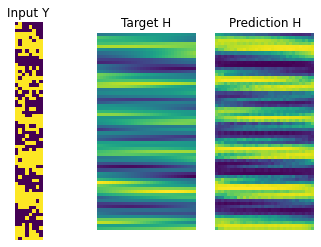

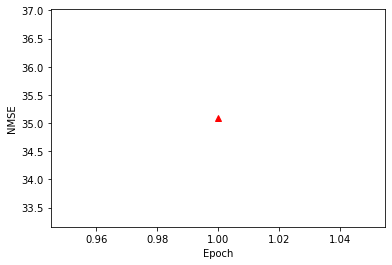

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 41.777725 , Discriminator loss: 0.8576042 , time: 0:20:17.483331
B/E: 1 / 1 , Generator loss: 36.982918 , Discriminator loss: 0.13205509 , time: 0:20:18.203492
B/E: 2 / 1 , Generator loss: 38.035915 , Discriminator loss: 0.4147357 , time: 0:20:18.955595
B/E: 3 / 1 , Generator loss: 38.914845 , Discriminator loss: 0.47803837 , time: 0:20:19.701709
B/E: 4 / 1 , Generator loss: 37.6363 , Discriminator loss: 0.7905166 , time: 0:20:20.425365
B/E: 5 / 1 , Generator loss: 32.474915 , Discriminator loss: 1.0089622 , time: 0:20:21.159500
B/E: 6 / 1 , Generator loss: 29.28449 , Discriminator loss: 1.113695 , time: 0:20:21.915095
B/E: 7 / 1 , Generator loss: 30.99098 , Discriminator loss: 0.19269827 , time: 0:20:22.640249
B/E: 8 / 1 , Generator loss: 39.14271 , Discriminator loss: 0.35635936 , time: 0:20:23.380872
B/E: 9 / 1 , Generator loss: 28.806393 , Discriminator loss: 0.996012 , time: 0:20:24.106524
B/E: 10 / 1 , Generator loss: 43.352554 , Discri

B/E: 87 / 1 , Generator loss: 36.20021 , Discriminator loss: 0.91933167 , time: 0:21:21.507877
B/E: 88 / 1 , Generator loss: 32.619682 , Discriminator loss: 1.77034 , time: 0:21:22.261975
B/E: 89 / 1 , Generator loss: 29.973461 , Discriminator loss: 0.90121543 , time: 0:21:22.996612
B/E: 90 / 1 , Generator loss: 26.91285 , Discriminator loss: 0.7385211 , time: 0:21:23.721265
B/E: 91 / 1 , Generator loss: 25.890781 , Discriminator loss: 1.1017634 , time: 0:21:24.437434
B/E: 92 / 1 , Generator loss: 34.23138 , Discriminator loss: 0.80140436 , time: 0:21:25.171570
B/E: 93 / 1 , Generator loss: 38.601955 , Discriminator loss: 0.95969516 , time: 0:21:25.900216
B/E: 94 / 1 , Generator loss: 37.946808 , Discriminator loss: 0.14929283 , time: 0:21:26.619380
B/E: 95 / 1 , Generator loss: 35.853893 , Discriminator loss: 0.5746238 , time: 0:21:27.385956
B/E: 96 / 1 , Generator loss: 36.341324 , Discriminator loss: 0.22623117 , time: 0:21:28.114103
B/E: 97 / 1 , Generator loss: 27.146149 , Discrim

B/E: 173 / 1 , Generator loss: 35.78385 , Discriminator loss: 0.45832023 , time: 0:22:24.757366
B/E: 174 / 1 , Generator loss: 39.65661 , Discriminator loss: 0.36393642 , time: 0:22:25.492500
B/E: 175 / 1 , Generator loss: 35.15902 , Discriminator loss: 1.8309107 , time: 0:22:26.218648
B/E: 176 / 1 , Generator loss: 39.686253 , Discriminator loss: 1.0165935 , time: 0:22:26.944799
B/E: 177 / 1 , Generator loss: 41.68828 , Discriminator loss: 0.24838732 , time: 0:22:27.690414
B/E: 178 / 1 , Generator loss: 34.95988 , Discriminator loss: 0.36851442 , time: 0:22:28.417065
B/E: 179 / 1 , Generator loss: 32.186954 , Discriminator loss: 1.3356303 , time: 0:22:29.170165
B/E: 180 / 1 , Generator loss: 33.99674 , Discriminator loss: 0.26591343 , time: 0:22:29.897812
B/E: 181 / 1 , Generator loss: 42.778416 , Discriminator loss: 0.20027372 , time: 0:22:30.617476
B/E: 182 / 1 , Generator loss: 28.957344 , Discriminator loss: 1.1933913 , time: 0:22:31.361594
B/E: 183 / 1 , Generator loss: 36.79387 

B/E: 259 / 1 , Generator loss: 29.166836 , Discriminator loss: 0.7680133 , time: 0:23:28.494446
B/E: 260 / 1 , Generator loss: 37.654694 , Discriminator loss: 0.55332637 , time: 0:23:29.215606
B/E: 261 / 1 , Generator loss: 34.82433 , Discriminator loss: 0.8457862 , time: 0:23:29.949740
B/E: 262 / 1 , Generator loss: 33.250286 , Discriminator loss: 1.3173847 , time: 0:23:30.706337
B/E: 263 / 1 , Generator loss: 29.669968 , Discriminator loss: 0.6722263 , time: 0:23:31.427496
B/E: 264 / 1 , Generator loss: 34.50993 , Discriminator loss: 0.5698558 , time: 0:23:32.150651
B/E: 265 / 1 , Generator loss: 36.23149 , Discriminator loss: 1.0662334 , time: 0:23:32.904252
B/E: 266 / 1 , Generator loss: 30.220657 , Discriminator loss: 0.19693431 , time: 0:23:33.630904
B/E: 267 / 1 , Generator loss: 30.608635 , Discriminator loss: 0.5310845 , time: 0:23:34.373523
B/E: 268 / 1 , Generator loss: 38.573776 , Discriminator loss: 0.23385555 , time: 0:23:35.096678
B/E: 269 / 1 , Generator loss: 28.894068

B/E: 345 / 1 , Generator loss: 38.5375 , Discriminator loss: 0.30516386 , time: 0:24:32.228031
B/E: 346 / 1 , Generator loss: 36.350414 , Discriminator loss: 2.4694493 , time: 0:24:32.954682
B/E: 347 / 1 , Generator loss: 33.74433 , Discriminator loss: 1.510679 , time: 0:24:33.735731
B/E: 348 / 1 , Generator loss: 30.909012 , Discriminator loss: 1.4259835 , time: 0:24:34.474358
B/E: 349 / 1 , Generator loss: 27.147621 , Discriminator loss: 0.6828888 , time: 0:24:35.194021
B/E: 350 / 1 , Generator loss: 42.34603 , Discriminator loss: 0.09371792 , time: 0:24:35.927658
B/E: 351 / 1 , Generator loss: 38.61009 , Discriminator loss: 0.63690245 , time: 0:24:36.656803
B/E: 352 / 1 , Generator loss: 37.70218 , Discriminator loss: 1.0643733 , time: 0:24:37.388445
B/E: 353 / 1 , Generator loss: 38.37613 , Discriminator loss: 1.2079861 , time: 0:24:38.105113
B/E: 354 / 1 , Generator loss: 39.401398 , Discriminator loss: 0.25044867 , time: 0:24:38.849730
B/E: 355 / 1 , Generator loss: 34.103596 , D

B/E: 431 / 1 , Generator loss: 39.967697 , Discriminator loss: 0.3624633 , time: 0:25:38.992988
B/E: 432 / 1 , Generator loss: 28.16604 , Discriminator loss: 1.1443839 , time: 0:25:39.716643
B/E: 433 / 1 , Generator loss: 37.30554 , Discriminator loss: 1.3942294 , time: 0:25:40.450281
B/E: 434 / 1 , Generator loss: 36.955765 , Discriminator loss: 0.31844878 , time: 0:25:41.357096
B/E: 435 / 1 , Generator loss: 40.1612 , Discriminator loss: 1.2063099 , time: 0:25:42.438585
B/E: 436 / 1 , Generator loss: 39.97456 , Discriminator loss: 0.48192602 , time: 0:25:43.339911
B/E: 437 / 1 , Generator loss: 36.324654 , Discriminator loss: 0.20158234 , time: 0:25:44.298131
B/E: 438 / 1 , Generator loss: 30.80223 , Discriminator loss: 0.64958346 , time: 0:25:45.112618
B/E: 439 / 1 , Generator loss: 33.131527 , Discriminator loss: 0.1141223 , time: 0:25:45.944073
B/E: 440 / 1 , Generator loss: 37.23469 , Discriminator loss: 0.71346194 , time: 0:25:46.761554
B/E: 441 / 1 , Generator loss: 25.514688 ,

B/E: 517 / 1 , Generator loss: 32.48031 , Discriminator loss: 1.1177431 , time: 0:26:43.942316
B/E: 518 / 1 , Generator loss: 35.20677 , Discriminator loss: 0.20849267 , time: 0:26:44.699908
B/E: 519 / 1 , Generator loss: 37.194145 , Discriminator loss: 0.6029841 , time: 0:26:45.436541
B/E: 520 / 1 , Generator loss: 29.695402 , Discriminator loss: 1.9782622 , time: 0:26:46.170177
B/E: 521 / 1 , Generator loss: 28.843563 , Discriminator loss: 0.3486377 , time: 0:26:46.900819
B/E: 522 / 1 , Generator loss: 30.61174 , Discriminator loss: 0.93847 , time: 0:26:47.633459
B/E: 523 / 1 , Generator loss: 33.06843 , Discriminator loss: 1.2919481 , time: 0:26:48.388556
B/E: 524 / 1 , Generator loss: 34.38718 , Discriminator loss: 0.5892796 , time: 0:26:49.134169
B/E: 525 / 1 , Generator loss: 35.367393 , Discriminator loss: 0.9246992 , time: 0:26:49.863814
B/E: 526 / 1 , Generator loss: 25.93866 , Discriminator loss: 2.369569 , time: 0:26:50.587470
B/E: 527 / 1 , Generator loss: 33.872322 , Discr

B/E: 603 / 1 , Generator loss: 36.444954 , Discriminator loss: 0.63366085 , time: 0:27:47.396922
B/E: 604 / 1 , Generator loss: 33.86084 , Discriminator loss: 0.4757104 , time: 0:27:48.221390
B/E: 605 / 1 , Generator loss: 45.92202 , Discriminator loss: 0.3871864 , time: 0:27:48.973991
B/E: 606 / 1 , Generator loss: 31.740921 , Discriminator loss: 0.47201473 , time: 0:27:49.701141
B/E: 607 / 1 , Generator loss: 39.077827 , Discriminator loss: 0.6337107 , time: 0:27:50.430287
B/E: 608 / 1 , Generator loss: 33.2395 , Discriminator loss: 0.67401165 , time: 0:27:51.186382
B/E: 609 / 1 , Generator loss: 27.974888 , Discriminator loss: 0.53309596 , time: 0:27:51.924510
B/E: 610 / 1 , Generator loss: 29.965155 , Discriminator loss: 0.2101713 , time: 0:27:52.644673
B/E: 611 / 1 , Generator loss: 30.29898 , Discriminator loss: 1.5885564 , time: 0:27:53.401266
B/E: 612 / 1 , Generator loss: 36.963116 , Discriminator loss: 0.6927259 , time: 0:27:54.135402
B/E: 613 / 1 , Generator loss: 31.442049 

B/E: 689 / 1 , Generator loss: 35.435616 , Discriminator loss: 1.3911579 , time: 0:28:50.907424
B/E: 690 / 1 , Generator loss: 31.115969 , Discriminator loss: 0.45153636 , time: 0:28:51.631578
B/E: 691 / 1 , Generator loss: 28.963188 , Discriminator loss: 0.3058039 , time: 0:28:52.366214
B/E: 692 / 1 , Generator loss: 33.658745 , Discriminator loss: 1.3457007 , time: 0:28:53.100350
B/E: 693 / 1 , Generator loss: 34.342266 , Discriminator loss: 0.5375103 , time: 0:28:53.844968
B/E: 694 / 1 , Generator loss: 34.80932 , Discriminator loss: 1.398062 , time: 0:28:54.580102
B/E: 695 / 1 , Generator loss: 31.844378 , Discriminator loss: 0.13770817 , time: 0:28:55.333700
B/E: 696 / 1 , Generator loss: 41.554 , Discriminator loss: 0.13777721 , time: 0:28:56.074325
B/E: 697 / 1 , Generator loss: 27.666933 , Discriminator loss: 0.5301445 , time: 0:28:56.803469
B/E: 698 / 1 , Generator loss: 34.71105 , Discriminator loss: 2.6367178 , time: 0:28:57.529120
B/E: 699 / 1 , Generator loss: 37.76296 , D

B/E: 775 / 1 , Generator loss: 27.60003 , Discriminator loss: 1.6705321 , time: 0:29:54.959919
B/E: 776 / 1 , Generator loss: 22.586224 , Discriminator loss: 1.6124041 , time: 0:29:55.721503
B/E: 777 / 1 , Generator loss: 23.047787 , Discriminator loss: 1.587474 , time: 0:29:56.476102
B/E: 778 / 1 , Generator loss: 27.53869 , Discriminator loss: 2.0980759 , time: 0:29:57.194267
B/E: 779 / 1 , Generator loss: 24.074541 , Discriminator loss: 1.2820609 , time: 0:29:58.021730
B/E: 780 / 1 , Generator loss: 23.575512 , Discriminator loss: 2.0026586 , time: 0:29:58.766347
B/E: 781 / 1 , Generator loss: 26.812206 , Discriminator loss: 0.5597913 , time: 0:29:59.509964
B/E: 782 / 1 , Generator loss: 27.89779 , Discriminator loss: 2.0923078 , time: 0:30:00.259573
B/E: 783 / 1 , Generator loss: 29.40085 , Discriminator loss: 2.580385 , time: 0:30:00.990215
B/E: 784 / 1 , Generator loss: 30.613743 , Discriminator loss: 1.2207909 , time: 0:30:01.744315
B/E: 785 / 1 , Generator loss: 24.70653 , Disc

B/E: 861 / 1 , Generator loss: 26.594303 , Discriminator loss: 0.5594796 , time: 0:30:58.592693
B/E: 862 / 1 , Generator loss: 19.410269 , Discriminator loss: 1.3985581 , time: 0:30:59.333318
B/E: 863 / 1 , Generator loss: 23.761446 , Discriminator loss: 1.4369868 , time: 0:31:00.056475
B/E: 864 / 1 , Generator loss: 21.405138 , Discriminator loss: 2.7596056 , time: 0:31:00.778632
B/E: 865 / 1 , Generator loss: 22.999945 , Discriminator loss: 1.1057142 , time: 0:31:01.518757
B/E: 866 / 1 , Generator loss: 22.921642 , Discriminator loss: 0.6188407 , time: 0:31:02.270859
B/E: 867 / 1 , Generator loss: 22.736015 , Discriminator loss: 2.1400728 , time: 0:31:03.023960
B/E: 868 / 1 , Generator loss: 25.752064 , Discriminator loss: 0.59766227 , time: 0:31:03.749113
B/E: 869 / 1 , Generator loss: 26.777786 , Discriminator loss: 1.2007862 , time: 0:31:04.485745
B/E: 870 / 1 , Generator loss: 24.854616 , Discriminator loss: 0.5547116 , time: 0:31:05.206907
B/E: 871 / 1 , Generator loss: 23.16870

B/E: 947 / 1 , Generator loss: 20.523993 , Discriminator loss: 1.1818738 , time: 0:32:01.930017
B/E: 948 / 1 , Generator loss: 23.98261 , Discriminator loss: 0.7376777 , time: 0:32:02.661658
B/E: 949 / 1 , Generator loss: 18.331137 , Discriminator loss: 1.0925395 , time: 0:32:03.390803
B/E: 950 / 1 , Generator loss: 23.81673 , Discriminator loss: 0.75122476 , time: 0:32:04.115957
B/E: 951 / 1 , Generator loss: 23.228893 , Discriminator loss: 1.1708956 , time: 0:32:04.892513
B/E: 952 / 1 , Generator loss: 24.031914 , Discriminator loss: 0.78249335 , time: 0:32:05.682545
B/E: 953 / 1 , Generator loss: 23.745415 , Discriminator loss: 0.56044084 , time: 0:32:06.478567
B/E: 954 / 1 , Generator loss: 22.761084 , Discriminator loss: 0.6368151 , time: 0:32:07.235161
B/E: 955 / 1 , Generator loss: 19.131987 , Discriminator loss: 1.135065 , time: 0:32:07.972790
B/E: 956 / 1 , Generator loss: 24.23263 , Discriminator loss: 0.60997105 , time: 0:32:08.695949
B/E: 957 / 1 , Generator loss: 19.50935 

B/E: 1032 / 1 , Generator loss: 24.823769 , Discriminator loss: 0.57596445 , time: 0:33:05.192980
B/E: 1033 / 1 , Generator loss: 20.889347 , Discriminator loss: 0.74474615 , time: 0:33:05.930109
B/E: 1034 / 1 , Generator loss: 24.164343 , Discriminator loss: 0.56199694 , time: 0:33:06.656762
B/E: 1035 / 1 , Generator loss: 21.622234 , Discriminator loss: 0.5721256 , time: 0:33:07.414352
B/E: 1036 / 1 , Generator loss: 18.911898 , Discriminator loss: 0.9364444 , time: 0:33:08.155475
B/E: 1037 / 1 , Generator loss: 24.937855 , Discriminator loss: 0.64080966 , time: 0:33:08.886117
B/E: 1038 / 1 , Generator loss: 19.65982 , Discriminator loss: 0.6149388 , time: 0:33:09.609274
B/E: 1039 / 1 , Generator loss: 25.302998 , Discriminator loss: 0.81170076 , time: 0:33:10.355388
B/E: 1040 / 1 , Generator loss: 22.135185 , Discriminator loss: 1.4645072 , time: 0:33:11.084533
B/E: 1041 / 1 , Generator loss: 20.847252 , Discriminator loss: 0.86550486 , time: 0:33:11.815674
B/E: 1042 / 1 , Generator

B/E: 1117 / 1 , Generator loss: 18.542564 , Discriminator loss: 0.6659726 , time: 0:34:07.760733
B/E: 1118 / 1 , Generator loss: 17.694017 , Discriminator loss: 1.7092215 , time: 0:34:08.507844
B/E: 1119 / 1 , Generator loss: 25.463327 , Discriminator loss: 0.6448098 , time: 0:34:09.234993
B/E: 1120 / 1 , Generator loss: 20.316893 , Discriminator loss: 0.4456436 , time: 0:34:09.963140
B/E: 1121 / 1 , Generator loss: 23.551207 , Discriminator loss: 0.5591351 , time: 0:34:10.715244
B/E: 1122 / 1 , Generator loss: 21.050663 , Discriminator loss: 0.9982633 , time: 0:34:11.449380
B/E: 1123 / 1 , Generator loss: 16.609903 , Discriminator loss: 1.0933158 , time: 0:34:12.185512
B/E: 1124 / 1 , Generator loss: 24.532282 , Discriminator loss: 1.5142518 , time: 0:34:12.941608
B/E: 1125 / 1 , Generator loss: 23.604382 , Discriminator loss: 0.656468 , time: 0:34:13.673747
B/E: 1126 / 1 , Generator loss: 25.1128 , Discriminator loss: 0.91021466 , time: 0:34:14.410877
B/E: 1127 / 1 , Generator loss: 

B/E: 1202 / 1 , Generator loss: 16.124756 , Discriminator loss: 1.6552587 , time: 0:35:10.455749
B/E: 1203 / 1 , Generator loss: 20.777832 , Discriminator loss: 1.8958932 , time: 0:35:11.178906
B/E: 1204 / 1 , Generator loss: 21.453442 , Discriminator loss: 0.66596395 , time: 0:35:11.909049
B/E: 1205 / 1 , Generator loss: 18.682423 , Discriminator loss: 0.637758 , time: 0:35:12.657159
B/E: 1206 / 1 , Generator loss: 28.237738 , Discriminator loss: 0.39509043 , time: 0:35:13.388799
B/E: 1207 / 1 , Generator loss: 22.375677 , Discriminator loss: 0.8785161 , time: 0:35:14.112455
B/E: 1208 / 1 , Generator loss: 21.969845 , Discriminator loss: 0.8844083 , time: 0:35:14.847590
B/E: 1209 / 1 , Generator loss: 21.969225 , Discriminator loss: 1.0039966 , time: 0:35:15.575238
B/E: 1210 / 1 , Generator loss: 20.790325 , Discriminator loss: 0.44641033 , time: 0:35:16.302886
B/E: 1211 / 1 , Generator loss: 19.340086 , Discriminator loss: 0.627873 , time: 0:35:17.069462
B/E: 1212 / 1 , Generator los

B/E: 1287 / 1 , Generator loss: 22.636093 , Discriminator loss: 0.54691297 , time: 0:36:15.338202
B/E: 1288 / 1 , Generator loss: 19.910967 , Discriminator loss: 0.7175526 , time: 0:36:16.084317
B/E: 1289 / 1 , Generator loss: 20.667616 , Discriminator loss: 1.7700874 , time: 0:36:16.867361
B/E: 1290 / 1 , Generator loss: 22.268917 , Discriminator loss: 0.5684265 , time: 0:36:18.151975
B/E: 1291 / 1 , Generator loss: 22.061401 , Discriminator loss: 1.2339089 , time: 0:36:19.513445
B/E: 1292 / 1 , Generator loss: 19.645174 , Discriminator loss: 0.59588695 , time: 0:36:20.468171
B/E: 1293 / 1 , Generator loss: 22.275589 , Discriminator loss: 1.8137102 , time: 0:36:21.294637
B/E: 1294 / 1 , Generator loss: 23.367485 , Discriminator loss: 1.0022683 , time: 0:36:22.307254
B/E: 1295 / 1 , Generator loss: 25.428812 , Discriminator loss: 0.757625 , time: 0:36:23.428172
B/E: 1296 / 1 , Generator loss: 20.264397 , Discriminator loss: 0.6441587 , time: 0:36:24.353952
B/E: 1297 / 1 , Generator los

B/E: 1372 / 1 , Generator loss: 19.072514 , Discriminator loss: 0.8933806 , time: 0:37:34.514599
B/E: 1373 / 1 , Generator loss: 18.182192 , Discriminator loss: 1.0387578 , time: 0:37:35.652983
B/E: 1374 / 1 , Generator loss: 25.337605 , Discriminator loss: 0.71345466 , time: 0:37:36.668597
B/E: 1375 / 1 , Generator loss: 23.719349 , Discriminator loss: 1.1492891 , time: 0:37:37.569923
B/E: 1376 / 1 , Generator loss: 24.68839 , Discriminator loss: 0.8041311 , time: 0:37:38.309548
B/E: 1377 / 1 , Generator loss: 17.291475 , Discriminator loss: 1.3986124 , time: 0:37:39.022722
B/E: 1378 / 1 , Generator loss: 23.517073 , Discriminator loss: 0.64456 , time: 0:37:39.809760
B/E: 1379 / 1 , Generator loss: 18.995283 , Discriminator loss: 1.1855217 , time: 0:37:40.537409
B/E: 1380 / 1 , Generator loss: 20.938183 , Discriminator loss: 0.7826163 , time: 0:37:41.253577
B/E: 1381 / 1 , Generator loss: 21.497334 , Discriminator loss: 1.4469054 , time: 0:37:42.025144
B/E: 1382 / 1 , Generator loss: 

B/E: 1457 / 1 , Generator loss: 23.051435 , Discriminator loss: 1.0408895 , time: 0:38:48.464705
B/E: 1458 / 1 , Generator loss: 19.552475 , Discriminator loss: 0.9581038 , time: 0:38:49.558671
B/E: 1459 / 1 , Generator loss: 21.862234 , Discriminator loss: 0.56116587 , time: 0:38:50.472973
B/E: 1460 / 1 , Generator loss: 16.866589 , Discriminator loss: 1.5551641 , time: 0:38:51.635314
B/E: 1461 / 1 , Generator loss: 17.60541 , Discriminator loss: 1.1483757 , time: 0:38:52.601519
B/E: 1462 / 1 , Generator loss: 19.164328 , Discriminator loss: 1.643794 , time: 0:38:53.652566
B/E: 1463 / 1 , Generator loss: 24.992823 , Discriminator loss: 0.59401226 , time: 0:38:54.730565
B/E: 1464 / 1 , Generator loss: 22.437384 , Discriminator loss: 0.8066757 , time: 0:38:55.612425
B/E: 1465 / 1 , Generator loss: 20.28431 , Discriminator loss: 0.3288563 , time: 0:38:56.365026
B/E: 1466 / 1 , Generator loss: 23.02583 , Discriminator loss: 1.4414674 , time: 0:38:57.336720
B/E: 1467 / 1 , Generator loss: 

B/E: 1542 / 1 , Generator loss: 19.272493 , Discriminator loss: 1.4456892 , time: 0:39:56.774790
B/E: 1543 / 1 , Generator loss: 25.111946 , Discriminator loss: 0.7607889 , time: 0:39:57.529387
B/E: 1544 / 1 , Generator loss: 22.37069 , Discriminator loss: 1.5359513 , time: 0:39:58.325407
B/E: 1545 / 1 , Generator loss: 18.454626 , Discriminator loss: 1.5692605 , time: 0:39:59.071522


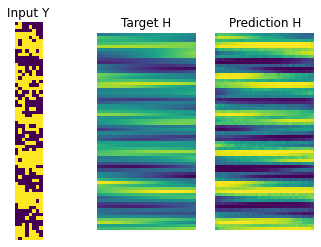

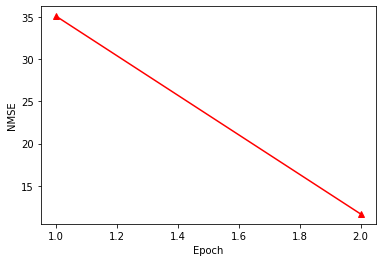

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 19.205675 , Discriminator loss: 0.89125746 , time: 0:40:49.515302
B/E: 1 / 2 , Generator loss: 20.006207 , Discriminator loss: 0.64551055 , time: 0:40:50.245445
B/E: 2 / 2 , Generator loss: 21.55579 , Discriminator loss: 1.8691478 , time: 0:40:50.993054
B/E: 3 / 2 , Generator loss: 21.953634 , Discriminator loss: 1.0942127 , time: 0:40:51.728689
B/E: 4 / 2 , Generator loss: 18.712463 , Discriminator loss: 1.2740165 , time: 0:40:52.455837
B/E: 5 / 2 , Generator loss: 19.506903 , Discriminator loss: 1.5841041 , time: 0:40:53.214428
B/E: 6 / 2 , Generator loss: 19.473547 , Discriminator loss: 1.6336052 , time: 0:40:53.939081
B/E: 7 / 2 , Generator loss: 22.951479 , Discriminator loss: 0.38323414 , time: 0:40:54.667728
B/E: 8 / 2 , Generator loss: 23.023891 , Discriminator loss: 0.73962206 , time: 0:40:55.438795
B/E: 9 / 2 , Generator loss: 17.683504 , Discriminator loss: 0.58443063 , time: 0:40:56.290713
B/E: 10 / 2 , Generator loss: 21.990204 ,

B/E: 87 / 2 , Generator loss: 23.729591 , Discriminator loss: 0.60844994 , time: 0:41:54.017460
B/E: 88 / 2 , Generator loss: 17.355038 , Discriminator loss: 1.4691178 , time: 0:41:54.757586
B/E: 89 / 2 , Generator loss: 16.745085 , Discriminator loss: 2.1534884 , time: 0:41:55.525159
B/E: 90 / 2 , Generator loss: 19.18126 , Discriminator loss: 0.5194047 , time: 0:41:56.271771
B/E: 91 / 2 , Generator loss: 17.804905 , Discriminator loss: 0.59478796 , time: 0:41:56.997423
B/E: 92 / 2 , Generator loss: 21.81309 , Discriminator loss: 0.629492 , time: 0:41:57.765497
B/E: 93 / 2 , Generator loss: 14.191604 , Discriminator loss: 1.5052918 , time: 0:41:58.542054
B/E: 94 / 2 , Generator loss: 19.26243 , Discriminator loss: 0.84834206 , time: 0:41:59.284673
B/E: 95 / 2 , Generator loss: 17.366951 , Discriminator loss: 0.73463506 , time: 0:42:00.047256
B/E: 96 / 2 , Generator loss: 19.874228 , Discriminator loss: 0.6043552 , time: 0:42:00.812834
B/E: 97 / 2 , Generator loss: 19.206669 , Discrimi

B/E: 173 / 2 , Generator loss: 20.203388 , Discriminator loss: 1.6825848 , time: 0:42:58.044003
B/E: 174 / 2 , Generator loss: 19.929039 , Discriminator loss: 1.3787757 , time: 0:42:58.766162
B/E: 175 / 2 , Generator loss: 23.579058 , Discriminator loss: 0.56468886 , time: 0:42:59.499300
B/E: 176 / 2 , Generator loss: 16.040125 , Discriminator loss: 1.7842965 , time: 0:43:00.237429
B/E: 177 / 2 , Generator loss: 20.978386 , Discriminator loss: 0.58353186 , time: 0:43:00.969567
B/E: 178 / 2 , Generator loss: 19.085163 , Discriminator loss: 2.0940268 , time: 0:43:01.700710
B/E: 179 / 2 , Generator loss: 19.49851 , Discriminator loss: 1.4510789 , time: 0:43:02.456307
B/E: 180 / 2 , Generator loss: 18.175182 , Discriminator loss: 1.8777015 , time: 0:43:03.191440
B/E: 181 / 2 , Generator loss: 23.02722 , Discriminator loss: 0.8141323 , time: 0:43:03.917590
B/E: 182 / 2 , Generator loss: 23.359293 , Discriminator loss: 0.47146052 , time: 0:43:04.647235
B/E: 183 / 2 , Generator loss: 17.88868

B/E: 259 / 2 , Generator loss: 20.675356 , Discriminator loss: 0.54559255 , time: 0:44:01.868422
B/E: 260 / 2 , Generator loss: 16.538712 , Discriminator loss: 1.1001668 , time: 0:44:02.618530
B/E: 261 / 2 , Generator loss: 20.050303 , Discriminator loss: 0.44697332 , time: 0:44:03.363644
B/E: 262 / 2 , Generator loss: 23.88709 , Discriminator loss: 0.41128367 , time: 0:44:04.086800
B/E: 263 / 2 , Generator loss: 16.775858 , Discriminator loss: 2.1529481 , time: 0:44:04.816944
B/E: 264 / 2 , Generator loss: 18.419674 , Discriminator loss: 1.0063689 , time: 0:44:05.546089
B/E: 265 / 2 , Generator loss: 17.183992 , Discriminator loss: 1.2361635 , time: 0:44:06.280724
B/E: 266 / 2 , Generator loss: 19.738375 , Discriminator loss: 0.8025513 , time: 0:44:07.002383
B/E: 267 / 2 , Generator loss: 17.525106 , Discriminator loss: 1.3561178 , time: 0:44:07.735022
B/E: 268 / 2 , Generator loss: 20.474573 , Discriminator loss: 1.0301559 , time: 0:44:08.472152
B/E: 269 / 2 , Generator loss: 20.7891

B/E: 345 / 2 , Generator loss: 15.2892 , Discriminator loss: 1.6943173 , time: 0:45:05.467759
B/E: 346 / 2 , Generator loss: 24.385786 , Discriminator loss: 0.3424003 , time: 0:45:06.223354
B/E: 347 / 2 , Generator loss: 19.295061 , Discriminator loss: 0.8311167 , time: 0:45:06.960985
B/E: 348 / 2 , Generator loss: 18.301466 , Discriminator loss: 0.87166154 , time: 0:45:07.691627
B/E: 349 / 2 , Generator loss: 24.623156 , Discriminator loss: 0.45308626 , time: 0:45:08.422269
B/E: 350 / 2 , Generator loss: 14.82746 , Discriminator loss: 0.97865283 , time: 0:45:09.150416
B/E: 351 / 2 , Generator loss: 19.478136 , Discriminator loss: 0.7748071 , time: 0:45:09.881059
B/E: 352 / 2 , Generator loss: 19.820776 , Discriminator loss: 0.8534381 , time: 0:45:10.599725
B/E: 353 / 2 , Generator loss: 22.496489 , Discriminator loss: 0.7953743 , time: 0:45:11.353823
B/E: 354 / 2 , Generator loss: 17.793531 , Discriminator loss: 0.8256616 , time: 0:45:12.096941
B/E: 355 / 2 , Generator loss: 19.669239

B/E: 431 / 2 , Generator loss: 18.580927 , Discriminator loss: 0.5462692 , time: 0:46:09.569661
B/E: 432 / 2 , Generator loss: 18.318127 , Discriminator loss: 0.7792946 , time: 0:46:10.313280
B/E: 433 / 2 , Generator loss: 21.932491 , Discriminator loss: 0.58592755 , time: 0:46:11.043424
B/E: 434 / 2 , Generator loss: 18.572338 , Discriminator loss: 0.62981415 , time: 0:46:11.775565
B/E: 435 / 2 , Generator loss: 15.309068 , Discriminator loss: 1.1691954 , time: 0:46:12.520180
B/E: 436 / 2 , Generator loss: 17.192486 , Discriminator loss: 1.3526857 , time: 0:46:13.274778
B/E: 437 / 2 , Generator loss: 19.582386 , Discriminator loss: 0.5773324 , time: 0:46:14.014404
B/E: 438 / 2 , Generator loss: 17.756514 , Discriminator loss: 1.2531576 , time: 0:46:14.761516
B/E: 439 / 2 , Generator loss: 18.685675 , Discriminator loss: 0.44211447 , time: 0:46:15.536076
B/E: 440 / 2 , Generator loss: 17.431612 , Discriminator loss: 1.1922561 , time: 0:46:16.266221
B/E: 441 / 2 , Generator loss: 18.963

B/E: 517 / 2 , Generator loss: 17.367178 , Discriminator loss: 1.3496865 , time: 0:47:12.927947
B/E: 518 / 2 , Generator loss: 22.682516 , Discriminator loss: 0.6307472 , time: 0:47:13.663081
B/E: 519 / 2 , Generator loss: 16.035044 , Discriminator loss: 0.95463955 , time: 0:47:14.403208
B/E: 520 / 2 , Generator loss: 16.41999 , Discriminator loss: 0.95756966 , time: 0:47:15.127361
B/E: 521 / 2 , Generator loss: 24.244328 , Discriminator loss: 0.54824615 , time: 0:47:15.852015
B/E: 522 / 2 , Generator loss: 18.82918 , Discriminator loss: 0.8952091 , time: 0:47:16.599624
B/E: 523 / 2 , Generator loss: 26.424599 , Discriminator loss: 0.89780164 , time: 0:47:17.334760
B/E: 524 / 2 , Generator loss: 16.953403 , Discriminator loss: 1.5985947 , time: 0:47:18.087361
B/E: 525 / 2 , Generator loss: 16.0683 , Discriminator loss: 0.9947986 , time: 0:47:18.822497
B/E: 526 / 2 , Generator loss: 24.884464 , Discriminator loss: 1.0669278 , time: 0:47:19.544155
B/E: 527 / 2 , Generator loss: 21.686403

B/E: 603 / 2 , Generator loss: 19.760328 , Discriminator loss: 0.7722804 , time: 0:48:16.354106
B/E: 604 / 2 , Generator loss: 17.604738 , Discriminator loss: 1.1138142 , time: 0:48:17.086245
B/E: 605 / 2 , Generator loss: 17.745811 , Discriminator loss: 0.89988726 , time: 0:48:17.820880
B/E: 606 / 2 , Generator loss: 15.101201 , Discriminator loss: 1.5031835 , time: 0:48:18.553519
B/E: 607 / 2 , Generator loss: 19.180176 , Discriminator loss: 0.4897715 , time: 0:48:19.305622
B/E: 608 / 2 , Generator loss: 17.556038 , Discriminator loss: 0.8171616 , time: 0:48:20.049739
B/E: 609 / 2 , Generator loss: 17.793137 , Discriminator loss: 1.255198 , time: 0:48:20.784873
B/E: 610 / 2 , Generator loss: 18.618217 , Discriminator loss: 1.3972472 , time: 0:48:21.511523
B/E: 611 / 2 , Generator loss: 13.738751 , Discriminator loss: 1.30811 , time: 0:48:22.233182
B/E: 612 / 2 , Generator loss: 19.429337 , Discriminator loss: 0.9099932 , time: 0:48:22.963825
B/E: 613 / 2 , Generator loss: 18.472176 ,

B/E: 689 / 2 , Generator loss: 19.035295 , Discriminator loss: 0.66375715 , time: 0:49:19.626549
B/E: 690 / 2 , Generator loss: 19.605364 , Discriminator loss: 0.6161974 , time: 0:49:20.360686
B/E: 691 / 2 , Generator loss: 20.882383 , Discriminator loss: 0.45197496 , time: 0:49:21.093329
B/E: 692 / 2 , Generator loss: 20.723938 , Discriminator loss: 0.55390745 , time: 0:49:21.847423
B/E: 693 / 2 , Generator loss: 21.12527 , Discriminator loss: 0.6895407 , time: 0:49:22.588048
B/E: 694 / 2 , Generator loss: 15.971682 , Discriminator loss: 1.1618505 , time: 0:49:23.325178
B/E: 695 / 2 , Generator loss: 16.954178 , Discriminator loss: 1.2929153 , time: 0:49:24.054825
B/E: 696 / 2 , Generator loss: 15.792323 , Discriminator loss: 1.3983189 , time: 0:49:24.796943
B/E: 697 / 2 , Generator loss: 20.024239 , Discriminator loss: 0.36271665 , time: 0:49:25.524591
B/E: 698 / 2 , Generator loss: 16.85652 , Discriminator loss: 1.2701898 , time: 0:49:26.258228
B/E: 699 / 2 , Generator loss: 22.7681

B/E: 775 / 2 , Generator loss: 16.525219 , Discriminator loss: 0.7255004 , time: 0:50:23.365627
B/E: 776 / 2 , Generator loss: 21.40026 , Discriminator loss: 0.6397047 , time: 0:50:24.163144
B/E: 777 / 2 , Generator loss: 17.834427 , Discriminator loss: 1.4663548 , time: 0:50:24.959166
B/E: 778 / 2 , Generator loss: 16.543 , Discriminator loss: 1.3399119 , time: 0:50:25.764670
B/E: 779 / 2 , Generator loss: 15.721219 , Discriminator loss: 0.96063834 , time: 0:50:26.505793
B/E: 780 / 2 , Generator loss: 17.73616 , Discriminator loss: 0.77072465 , time: 0:50:27.240927
B/E: 781 / 2 , Generator loss: 16.351961 , Discriminator loss: 0.862482 , time: 0:50:27.968075
B/E: 782 / 2 , Generator loss: 15.537875 , Discriminator loss: 1.0613506 , time: 0:50:28.696222
B/E: 783 / 2 , Generator loss: 18.768152 , Discriminator loss: 0.65731114 , time: 0:50:29.433852
B/E: 784 / 2 , Generator loss: 20.731625 , Discriminator loss: 0.42373228 , time: 0:50:30.152018
B/E: 785 / 2 , Generator loss: 19.390308 ,

B/E: 861 / 2 , Generator loss: 18.406038 , Discriminator loss: 1.2407308 , time: 0:51:26.916055
B/E: 862 / 2 , Generator loss: 17.87778 , Discriminator loss: 0.7109988 , time: 0:51:27.648694
B/E: 863 / 2 , Generator loss: 17.589123 , Discriminator loss: 1.3834932 , time: 0:51:28.394807
B/E: 864 / 2 , Generator loss: 19.165066 , Discriminator loss: 0.5585292 , time: 0:51:29.120460
B/E: 865 / 2 , Generator loss: 17.562498 , Discriminator loss: 1.2434351 , time: 0:51:29.841119
B/E: 866 / 2 , Generator loss: 12.932315 , Discriminator loss: 0.8061685 , time: 0:51:30.568271
B/E: 867 / 2 , Generator loss: 20.847328 , Discriminator loss: 1.1167437 , time: 0:51:31.296914
B/E: 868 / 2 , Generator loss: 16.994724 , Discriminator loss: 0.98562044 , time: 0:51:32.024065
B/E: 869 / 2 , Generator loss: 18.32264 , Discriminator loss: 0.6495988 , time: 0:51:32.756703
B/E: 870 / 2 , Generator loss: 20.339703 , Discriminator loss: 0.6859547 , time: 0:51:33.491338
B/E: 871 / 2 , Generator loss: 18.41549 ,

B/E: 947 / 2 , Generator loss: 17.074677 , Discriminator loss: 0.63647884 , time: 0:52:33.075136
B/E: 948 / 2 , Generator loss: 21.946907 , Discriminator loss: 0.51997674 , time: 0:52:33.806777
B/E: 949 / 2 , Generator loss: 17.423061 , Discriminator loss: 0.7959878 , time: 0:52:34.521449
B/E: 950 / 2 , Generator loss: 20.171993 , Discriminator loss: 0.92953825 , time: 0:52:35.256083
B/E: 951 / 2 , Generator loss: 17.607332 , Discriminator loss: 0.9912817 , time: 0:52:36.015672
B/E: 952 / 2 , Generator loss: 17.766663 , Discriminator loss: 1.9833016 , time: 0:52:36.748311
B/E: 953 / 2 , Generator loss: 18.421934 , Discriminator loss: 0.7831347 , time: 0:52:37.495423
B/E: 954 / 2 , Generator loss: 23.920227 , Discriminator loss: 2.499239 , time: 0:52:38.233551
B/E: 955 / 2 , Generator loss: 18.593779 , Discriminator loss: 0.86792 , time: 0:52:38.970682
B/E: 956 / 2 , Generator loss: 19.279722 , Discriminator loss: 0.4464291 , time: 0:52:39.716296
B/E: 957 / 2 , Generator loss: 17.78507 

B/E: 1033 / 2 , Generator loss: 22.491457 , Discriminator loss: 1.1252527 , time: 0:53:36.717892
B/E: 1034 / 2 , Generator loss: 18.501593 , Discriminator loss: 0.8724354 , time: 0:53:37.472489
B/E: 1035 / 2 , Generator loss: 17.13575 , Discriminator loss: 2.448174 , time: 0:53:38.209620
B/E: 1036 / 2 , Generator loss: 23.48128 , Discriminator loss: 0.3065027 , time: 0:53:38.927287
B/E: 1037 / 2 , Generator loss: 21.98602 , Discriminator loss: 0.5497542 , time: 0:53:39.673900
B/E: 1038 / 2 , Generator loss: 19.248749 , Discriminator loss: 0.50199753 , time: 0:53:40.420013
B/E: 1039 / 2 , Generator loss: 16.604546 , Discriminator loss: 0.74099565 , time: 0:53:41.155648
B/E: 1040 / 2 , Generator loss: 16.953617 , Discriminator loss: 1.3376516 , time: 0:53:41.908748
B/E: 1041 / 2 , Generator loss: 19.611822 , Discriminator loss: 1.0839791 , time: 0:53:42.640887
B/E: 1042 / 2 , Generator loss: 20.112751 , Discriminator loss: 1.1939335 , time: 0:53:43.378018
B/E: 1043 / 2 , Generator loss: 

B/E: 1118 / 2 , Generator loss: 16.344707 , Discriminator loss: 1.5814134 , time: 0:54:39.830632
B/E: 1119 / 2 , Generator loss: 21.606562 , Discriminator loss: 1.0997025 , time: 0:54:40.564269
B/E: 1120 / 2 , Generator loss: 15.109951 , Discriminator loss: 1.3172767 , time: 0:54:41.296908
B/E: 1121 / 2 , Generator loss: 20.103964 , Discriminator loss: 0.5228974 , time: 0:54:42.029048
B/E: 1122 / 2 , Generator loss: 21.852438 , Discriminator loss: 0.5052462 , time: 0:54:42.765180
B/E: 1123 / 2 , Generator loss: 13.986924 , Discriminator loss: 0.71350694 , time: 0:54:43.506305
B/E: 1124 / 2 , Generator loss: 21.83025 , Discriminator loss: 0.69248164 , time: 0:54:44.247925
B/E: 1125 / 2 , Generator loss: 14.4761715 , Discriminator loss: 1.2488178 , time: 0:54:44.990546
B/E: 1126 / 2 , Generator loss: 19.065208 , Discriminator loss: 0.84109175 , time: 0:54:45.725681
B/E: 1127 / 2 , Generator loss: 15.56614 , Discriminator loss: 1.533584 , time: 0:54:46.559631
B/E: 1128 / 2 , Generator los

B/E: 1203 / 2 , Generator loss: 21.154455 , Discriminator loss: 0.61978114 , time: 0:55:44.672660
B/E: 1204 / 2 , Generator loss: 21.530405 , Discriminator loss: 0.6204025 , time: 0:55:45.416279
B/E: 1205 / 2 , Generator loss: 15.533616 , Discriminator loss: 0.94001913 , time: 0:55:46.183356
B/E: 1206 / 2 , Generator loss: 19.131613 , Discriminator loss: 0.6942312 , time: 0:55:46.945937
B/E: 1207 / 2 , Generator loss: 17.917881 , Discriminator loss: 0.8672967 , time: 0:55:47.688058
B/E: 1208 / 2 , Generator loss: 19.37128 , Discriminator loss: 0.93362933 , time: 0:55:48.439662
B/E: 1209 / 2 , Generator loss: 19.576824 , Discriminator loss: 0.5046475 , time: 0:55:49.163816
B/E: 1210 / 2 , Generator loss: 18.675009 , Discriminator loss: 1.3077292 , time: 0:55:49.886474
B/E: 1211 / 2 , Generator loss: 20.864073 , Discriminator loss: 0.67997557 , time: 0:55:50.617616
B/E: 1212 / 2 , Generator loss: 16.442041 , Discriminator loss: 1.1570876 , time: 0:55:51.362732
B/E: 1213 / 2 , Generator l

B/E: 1288 / 2 , Generator loss: 17.89698 , Discriminator loss: 0.6073026 , time: 0:56:51.574362
B/E: 1289 / 2 , Generator loss: 18.403341 , Discriminator loss: 0.956461 , time: 0:56:52.316981
B/E: 1290 / 2 , Generator loss: 17.223331 , Discriminator loss: 1.5500138 , time: 0:56:53.066090
B/E: 1291 / 2 , Generator loss: 17.724318 , Discriminator loss: 0.9751137 , time: 0:56:53.792241
B/E: 1292 / 2 , Generator loss: 17.569048 , Discriminator loss: 0.8316797 , time: 0:56:54.516396
B/E: 1293 / 2 , Generator loss: 18.328554 , Discriminator loss: 0.6712767 , time: 0:56:55.247038
B/E: 1294 / 2 , Generator loss: 22.593573 , Discriminator loss: 0.5934092 , time: 0:56:55.981174
B/E: 1295 / 2 , Generator loss: 17.674496 , Discriminator loss: 0.509745 , time: 0:56:56.729285
B/E: 1296 / 2 , Generator loss: 18.284266 , Discriminator loss: 1.1044757 , time: 0:56:57.467413
B/E: 1297 / 2 , Generator loss: 18.46898 , Discriminator loss: 0.6890323 , time: 0:56:58.225006
B/E: 1298 / 2 , Generator loss: 20

B/E: 1373 / 2 , Generator loss: 21.392298 , Discriminator loss: 0.7088554 , time: 0:57:54.412114
B/E: 1374 / 2 , Generator loss: 18.507439 , Discriminator loss: 1.3147694 , time: 0:57:55.157229
B/E: 1375 / 2 , Generator loss: 19.348412 , Discriminator loss: 0.6257653 , time: 0:57:55.908833
B/E: 1376 / 2 , Generator loss: 20.298029 , Discriminator loss: 0.4434198 , time: 0:57:56.682395
B/E: 1377 / 2 , Generator loss: 14.8818035 , Discriminator loss: 1.047942 , time: 0:57:57.451467
B/E: 1378 / 2 , Generator loss: 17.35737 , Discriminator loss: 0.7566522 , time: 0:57:58.290907
B/E: 1379 / 2 , Generator loss: 14.137736 , Discriminator loss: 0.7845011 , time: 0:57:59.104895
B/E: 1380 / 2 , Generator loss: 18.382858 , Discriminator loss: 0.9729855 , time: 0:57:59.842025
B/E: 1381 / 2 , Generator loss: 19.661541 , Discriminator loss: 0.5694573 , time: 0:58:00.586642
B/E: 1382 / 2 , Generator loss: 18.033194 , Discriminator loss: 0.639465 , time: 0:58:01.323772
B/E: 1383 / 2 , Generator loss: 

B/E: 1458 / 2 , Generator loss: 17.81421 , Discriminator loss: 1.5266621 , time: 0:58:57.300272
B/E: 1459 / 2 , Generator loss: 15.925694 , Discriminator loss: 1.0080447 , time: 0:58:58.041395
B/E: 1460 / 2 , Generator loss: 24.00178 , Discriminator loss: 0.67956185 , time: 0:58:58.777527
B/E: 1461 / 2 , Generator loss: 14.924189 , Discriminator loss: 0.5286182 , time: 0:58:59.514659
B/E: 1462 / 2 , Generator loss: 22.852493 , Discriminator loss: 0.32477447 , time: 0:59:00.249793
B/E: 1463 / 2 , Generator loss: 15.45304 , Discriminator loss: 1.5597459 , time: 0:59:00.992911
B/E: 1464 / 2 , Generator loss: 20.414732 , Discriminator loss: 1.9228462 , time: 0:59:01.721557
B/E: 1465 / 2 , Generator loss: 16.738453 , Discriminator loss: 1.1475539 , time: 0:59:02.444215
B/E: 1466 / 2 , Generator loss: 18.82872 , Discriminator loss: 0.52359486 , time: 0:59:03.181345
B/E: 1467 / 2 , Generator loss: 15.846437 , Discriminator loss: 0.6368977 , time: 0:59:03.917478
B/E: 1468 / 2 , Generator loss:

B/E: 1543 / 2 , Generator loss: 18.318092 , Discriminator loss: 1.2394373 , time: 1:00:00.148505
B/E: 1544 / 2 , Generator loss: 17.09238 , Discriminator loss: 0.909015 , time: 1:00:00.871164
B/E: 1545 / 2 , Generator loss: 17.100779 , Discriminator loss: 1.1234003 , time: 1:00:01.607295


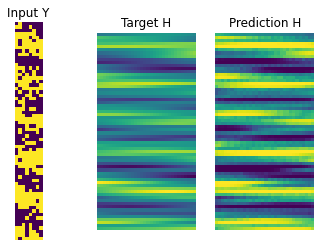

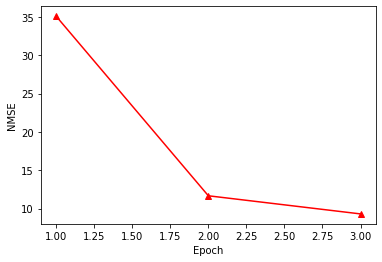

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 15.40748 , Discriminator loss: 0.8398583 , time: 1:00:52.295626
B/E: 1 / 3 , Generator loss: 18.753117 , Discriminator loss: 0.41439158 , time: 1:00:53.026261
B/E: 2 / 3 , Generator loss: 16.21167 , Discriminator loss: 1.1370904 , time: 1:00:53.763392
B/E: 3 / 3 , Generator loss: 16.983347 , Discriminator loss: 2.0407016 , time: 1:00:54.503517
B/E: 4 / 3 , Generator loss: 17.62396 , Discriminator loss: 0.89294267 , time: 1:00:55.251127
B/E: 5 / 3 , Generator loss: 17.359962 , Discriminator loss: 0.56915516 , time: 1:00:55.983267
B/E: 6 / 3 , Generator loss: 16.466944 , Discriminator loss: 0.9387631 , time: 1:00:56.716405
B/E: 7 / 3 , Generator loss: 23.34367 , Discriminator loss: 0.82372826 , time: 1:00:57.460023
B/E: 8 / 3 , Generator loss: 17.978588 , Discriminator loss: 0.6035278 , time: 1:00:58.210130
B/E: 9 / 3 , Generator loss: 20.556679 , Discriminator loss: 0.56363916 , time: 1:00:58.933287
B/E: 10 / 3 , Generator loss: 16.510029 , Di

B/E: 87 / 3 , Generator loss: 13.8179035 , Discriminator loss: 1.8037889 , time: 1:01:56.433456
B/E: 88 / 3 , Generator loss: 20.108494 , Discriminator loss: 0.5490031 , time: 1:01:57.164098
B/E: 89 / 3 , Generator loss: 19.130169 , Discriminator loss: 0.20458807 , time: 1:01:57.957623
B/E: 90 / 3 , Generator loss: 17.986103 , Discriminator loss: 0.6743657 , time: 1:01:58.701241
B/E: 91 / 3 , Generator loss: 13.580212 , Discriminator loss: 1.1052856 , time: 1:01:59.439870
B/E: 92 / 3 , Generator loss: 22.87881 , Discriminator loss: 0.39817828 , time: 1:02:00.209938
B/E: 93 / 3 , Generator loss: 17.441084 , Discriminator loss: 0.39439973 , time: 1:02:00.958048
B/E: 94 / 3 , Generator loss: 15.067298 , Discriminator loss: 0.7439192 , time: 1:02:01.718636
B/E: 95 / 3 , Generator loss: 19.21657 , Discriminator loss: 0.57219946 , time: 1:02:02.445285
B/E: 96 / 3 , Generator loss: 17.293705 , Discriminator loss: 0.5349583 , time: 1:02:03.172934
B/E: 97 / 3 , Generator loss: 15.1444 , Discrim

B/E: 173 / 3 , Generator loss: 16.197823 , Discriminator loss: 0.63639987 , time: 1:03:00.047265
B/E: 174 / 3 , Generator loss: 17.283361 , Discriminator loss: 0.48991692 , time: 1:03:00.791882
B/E: 175 / 3 , Generator loss: 16.016933 , Discriminator loss: 1.0038892 , time: 1:03:01.531507
B/E: 176 / 3 , Generator loss: 13.264491 , Discriminator loss: 1.2292081 , time: 1:03:02.257658
B/E: 177 / 3 , Generator loss: 23.025478 , Discriminator loss: 0.6845494 , time: 1:03:03.026729
B/E: 178 / 3 , Generator loss: 17.595882 , Discriminator loss: 0.6188328 , time: 1:03:03.768351
B/E: 179 / 3 , Generator loss: 13.572166 , Discriminator loss: 0.4139462 , time: 1:03:04.517959
B/E: 180 / 3 , Generator loss: 18.767576 , Discriminator loss: 0.7079321 , time: 1:03:05.251099
B/E: 181 / 3 , Generator loss: 18.47279 , Discriminator loss: 0.56880397 , time: 1:03:05.978248
B/E: 182 / 3 , Generator loss: 19.05182 , Discriminator loss: 0.31280488 , time: 1:03:06.694915
B/E: 183 / 3 , Generator loss: 18.3149

B/E: 259 / 3 , Generator loss: 17.928383 , Discriminator loss: 0.6137527 , time: 1:04:03.450466
B/E: 260 / 3 , Generator loss: 17.293804 , Discriminator loss: 1.1086473 , time: 1:04:04.197078
B/E: 261 / 3 , Generator loss: 19.120308 , Discriminator loss: 1.3903422 , time: 1:04:05.052490
B/E: 262 / 3 , Generator loss: 19.477146 , Discriminator loss: 0.5918915 , time: 1:04:05.868973
B/E: 263 / 3 , Generator loss: 16.067497 , Discriminator loss: 0.6456196 , time: 1:04:06.630060
B/E: 264 / 3 , Generator loss: 11.734856 , Discriminator loss: 1.1371982 , time: 1:04:07.370184
B/E: 265 / 3 , Generator loss: 17.68234 , Discriminator loss: 1.4022193 , time: 1:04:08.086353
B/E: 266 / 3 , Generator loss: 18.535269 , Discriminator loss: 0.33166876 , time: 1:04:08.819990
B/E: 267 / 3 , Generator loss: 17.159935 , Discriminator loss: 0.40590346 , time: 1:04:09.552630
B/E: 268 / 3 , Generator loss: 19.35363 , Discriminator loss: 0.48282757 , time: 1:04:10.285267
B/E: 269 / 3 , Generator loss: 13.57277

B/E: 345 / 3 , Generator loss: 18.14315 , Discriminator loss: 0.83120894 , time: 1:05:07.475013
B/E: 346 / 3 , Generator loss: 15.04229 , Discriminator loss: 0.5941186 , time: 1:05:08.217633
B/E: 347 / 3 , Generator loss: 18.560415 , Discriminator loss: 1.0553027 , time: 1:05:08.975225
B/E: 348 / 3 , Generator loss: 19.90686 , Discriminator loss: 1.2945589 , time: 1:05:09.701377
B/E: 349 / 3 , Generator loss: 14.743437 , Discriminator loss: 0.6818482 , time: 1:05:10.427031
B/E: 350 / 3 , Generator loss: 16.8108 , Discriminator loss: 1.1677134 , time: 1:05:11.159667
B/E: 351 / 3 , Generator loss: 26.146849 , Discriminator loss: 0.8889868 , time: 1:05:11.898296
B/E: 352 / 3 , Generator loss: 18.922825 , Discriminator loss: 0.94318604 , time: 1:05:12.625943
B/E: 353 / 3 , Generator loss: 15.215662 , Discriminator loss: 0.6147473 , time: 1:05:13.387029
B/E: 354 / 3 , Generator loss: 16.451908 , Discriminator loss: 0.61380225 , time: 1:05:14.129650
B/E: 355 / 3 , Generator loss: 15.28919 , 

B/E: 431 / 3 , Generator loss: 18.236437 , Discriminator loss: 0.6919892 , time: 1:06:10.835294
B/E: 432 / 3 , Generator loss: 13.738756 , Discriminator loss: 0.97809845 , time: 1:06:11.583902
B/E: 433 / 3 , Generator loss: 17.290722 , Discriminator loss: 0.5709188 , time: 1:06:12.335508
B/E: 434 / 3 , Generator loss: 20.480066 , Discriminator loss: 0.5479638 , time: 1:06:13.066149
B/E: 435 / 3 , Generator loss: 14.426484 , Discriminator loss: 0.36050296 , time: 1:06:13.791303
B/E: 436 / 3 , Generator loss: 15.852756 , Discriminator loss: 0.49697283 , time: 1:06:14.525439
B/E: 437 / 3 , Generator loss: 13.668613 , Discriminator loss: 1.220254 , time: 1:06:15.281033
B/E: 438 / 3 , Generator loss: 11.466614 , Discriminator loss: 1.0081764 , time: 1:06:15.997203
B/E: 439 / 3 , Generator loss: 16.560854 , Discriminator loss: 0.6431902 , time: 1:06:16.734834
B/E: 440 / 3 , Generator loss: 16.72417 , Discriminator loss: 0.47016913 , time: 1:06:17.464478
B/E: 441 / 3 , Generator loss: 16.5465

B/E: 517 / 3 , Generator loss: 14.25665 , Discriminator loss: 1.2886662 , time: 1:07:14.013414
B/E: 518 / 3 , Generator loss: 18.759775 , Discriminator loss: 0.5320262 , time: 1:07:14.759028
B/E: 519 / 3 , Generator loss: 18.999788 , Discriminator loss: 0.27528295 , time: 1:07:15.497656
B/E: 520 / 3 , Generator loss: 16.589298 , Discriminator loss: 0.56048965 , time: 1:07:16.234787
B/E: 521 / 3 , Generator loss: 16.451239 , Discriminator loss: 0.57709146 , time: 1:07:16.965929
B/E: 522 / 3 , Generator loss: 16.968773 , Discriminator loss: 0.77387553 , time: 1:07:17.696071
B/E: 523 / 3 , Generator loss: 21.38429 , Discriminator loss: 1.8737639 , time: 1:07:18.416233
B/E: 524 / 3 , Generator loss: 19.536877 , Discriminator loss: 0.5905371 , time: 1:07:19.151866
B/E: 525 / 3 , Generator loss: 16.501522 , Discriminator loss: 0.4499963 , time: 1:07:19.882510
B/E: 526 / 3 , Generator loss: 17.549154 , Discriminator loss: 0.88905317 , time: 1:07:20.601673
B/E: 527 / 3 , Generator loss: 22.268

B/E: 603 / 3 , Generator loss: 19.576843 , Discriminator loss: 0.4938716 , time: 1:08:17.358223
B/E: 604 / 3 , Generator loss: 16.568285 , Discriminator loss: 0.42631033 , time: 1:08:18.128292
B/E: 605 / 3 , Generator loss: 16.828035 , Discriminator loss: 0.357851 , time: 1:08:18.859933
B/E: 606 / 3 , Generator loss: 15.888175 , Discriminator loss: 1.0373745 , time: 1:08:19.594569
B/E: 607 / 3 , Generator loss: 20.602148 , Discriminator loss: 0.43669355 , time: 1:08:20.341181
B/E: 608 / 3 , Generator loss: 18.139498 , Discriminator loss: 0.72370327 , time: 1:08:21.207571
B/E: 609 / 3 , Generator loss: 16.934013 , Discriminator loss: 1.9551206 , time: 1:08:22.004091
B/E: 610 / 3 , Generator loss: 15.468067 , Discriminator loss: 1.8780161 , time: 1:08:22.842034
B/E: 611 / 3 , Generator loss: 20.909475 , Discriminator loss: 1.2748605 , time: 1:08:23.658019
B/E: 612 / 3 , Generator loss: 16.280655 , Discriminator loss: 0.38483152 , time: 1:08:24.407126
B/E: 613 / 3 , Generator loss: 13.695

B/E: 689 / 3 , Generator loss: 12.282552 , Discriminator loss: 0.9264591 , time: 1:09:21.540976
B/E: 690 / 3 , Generator loss: 15.882678 , Discriminator loss: 1.2528671 , time: 1:09:22.277610
B/E: 691 / 3 , Generator loss: 18.444553 , Discriminator loss: 2.5853508 , time: 1:09:23.006753
B/E: 692 / 3 , Generator loss: 15.553585 , Discriminator loss: 1.4054046 , time: 1:09:23.745381
B/E: 693 / 3 , Generator loss: 18.061962 , Discriminator loss: 0.93255997 , time: 1:09:24.499980
B/E: 694 / 3 , Generator loss: 17.769644 , Discriminator loss: 0.8624576 , time: 1:09:25.233615
B/E: 695 / 3 , Generator loss: 13.532777 , Discriminator loss: 2.5940077 , time: 1:09:25.968750
B/E: 696 / 3 , Generator loss: 17.396746 , Discriminator loss: 0.44482595 , time: 1:09:26.711370
B/E: 697 / 3 , Generator loss: 21.831017 , Discriminator loss: 0.5070704 , time: 1:09:27.438019
B/E: 698 / 3 , Generator loss: 13.965975 , Discriminator loss: 1.5127412 , time: 1:09:28.180641
B/E: 699 / 3 , Generator loss: 13.4149

B/E: 775 / 3 , Generator loss: 14.387203 , Discriminator loss: 0.44022742 , time: 1:10:25.418297
B/E: 776 / 3 , Generator loss: 17.73408 , Discriminator loss: 0.6666512 , time: 1:10:26.153931
B/E: 777 / 3 , Generator loss: 14.380708 , Discriminator loss: 0.33870095 , time: 1:10:26.888066
B/E: 778 / 3 , Generator loss: 14.651268 , Discriminator loss: 2.0294597 , time: 1:10:27.609725
B/E: 779 / 3 , Generator loss: 16.922945 , Discriminator loss: 0.54635286 , time: 1:10:28.346858
B/E: 780 / 3 , Generator loss: 15.176672 , Discriminator loss: 0.669846 , time: 1:10:29.071011
B/E: 781 / 3 , Generator loss: 18.239826 , Discriminator loss: 0.8154145 , time: 1:10:29.815626
B/E: 782 / 3 , Generator loss: 19.428019 , Discriminator loss: 0.8166805 , time: 1:10:30.539281
B/E: 783 / 3 , Generator loss: 17.107714 , Discriminator loss: 0.63785636 , time: 1:10:31.301868
B/E: 784 / 3 , Generator loss: 14.949372 , Discriminator loss: 0.6673033 , time: 1:10:32.051971
B/E: 785 / 3 , Generator loss: 15.5934

B/E: 861 / 3 , Generator loss: 15.336933 , Discriminator loss: 0.7212877 , time: 1:11:29.982341
B/E: 862 / 3 , Generator loss: 16.27012 , Discriminator loss: 1.6270821 , time: 1:11:30.707495
B/E: 863 / 3 , Generator loss: 12.531013 , Discriminator loss: 1.3473065 , time: 1:11:31.438636
B/E: 864 / 3 , Generator loss: 19.403044 , Discriminator loss: 0.34326723 , time: 1:11:32.177262
B/E: 865 / 3 , Generator loss: 18.33681 , Discriminator loss: 0.30724123 , time: 1:11:32.899421
B/E: 866 / 3 , Generator loss: 14.922875 , Discriminator loss: 0.5304553 , time: 1:11:33.659509
B/E: 867 / 3 , Generator loss: 13.563208 , Discriminator loss: 0.94794905 , time: 1:11:34.406124
B/E: 868 / 3 , Generator loss: 20.682327 , Discriminator loss: 0.518505 , time: 1:11:35.157227
B/E: 869 / 3 , Generator loss: 17.497381 , Discriminator loss: 0.46089554 , time: 1:11:35.934283
B/E: 870 / 3 , Generator loss: 17.230652 , Discriminator loss: 0.2679244 , time: 1:11:36.760748
B/E: 871 / 3 , Generator loss: 16.21381

B/E: 947 / 3 , Generator loss: 15.595229 , Discriminator loss: 1.4032624 , time: 1:12:33.608129
B/E: 948 / 3 , Generator loss: 17.452824 , Discriminator loss: 0.38179058 , time: 1:12:34.340768
B/E: 949 / 3 , Generator loss: 15.895787 , Discriminator loss: 0.40869385 , time: 1:12:35.069913
B/E: 950 / 3 , Generator loss: 15.58119 , Discriminator loss: 0.48389068 , time: 1:12:35.839982
B/E: 951 / 3 , Generator loss: 17.926271 , Discriminator loss: 0.3547909 , time: 1:12:36.580107
B/E: 952 / 3 , Generator loss: 14.853996 , Discriminator loss: 0.51436704 , time: 1:12:37.340195
B/E: 953 / 3 , Generator loss: 15.645114 , Discriminator loss: 0.98215467 , time: 1:12:38.057362
B/E: 954 / 3 , Generator loss: 17.17771 , Discriminator loss: 0.84193367 , time: 1:12:38.793993
B/E: 955 / 3 , Generator loss: 18.372738 , Discriminator loss: 0.26805788 , time: 1:12:39.519147
B/E: 956 / 3 , Generator loss: 16.24068 , Discriminator loss: 0.5241185 , time: 1:12:40.249290
B/E: 957 / 3 , Generator loss: 15.15

B/E: 1032 / 3 , Generator loss: 14.993913 , Discriminator loss: 0.18678302 , time: 1:13:36.290171
B/E: 1033 / 3 , Generator loss: 14.343002 , Discriminator loss: 0.9574101 , time: 1:13:37.056747
B/E: 1034 / 3 , Generator loss: 15.197163 , Discriminator loss: 1.1094735 , time: 1:13:37.817333
B/E: 1035 / 3 , Generator loss: 13.437307 , Discriminator loss: 0.8492712 , time: 1:13:38.537494
B/E: 1036 / 3 , Generator loss: 18.581654 , Discriminator loss: 0.3232767 , time: 1:13:39.300577
B/E: 1037 / 3 , Generator loss: 13.348434 , Discriminator loss: 1.722862 , time: 1:13:40.040202
B/E: 1038 / 3 , Generator loss: 16.561626 , Discriminator loss: 0.34710014 , time: 1:13:40.768850
B/E: 1039 / 3 , Generator loss: 21.58227 , Discriminator loss: 0.60642725 , time: 1:13:41.502488
B/E: 1040 / 3 , Generator loss: 13.908412 , Discriminator loss: 0.4448833 , time: 1:13:42.235125
B/E: 1041 / 3 , Generator loss: 16.019243 , Discriminator loss: 1.2205738 , time: 1:13:42.963771
B/E: 1042 / 3 , Generator los

B/E: 1117 / 3 , Generator loss: 14.957081 , Discriminator loss: 0.77300906 , time: 1:14:39.036092
B/E: 1118 / 3 , Generator loss: 17.32286 , Discriminator loss: 0.2814743 , time: 1:14:39.769729
B/E: 1119 / 3 , Generator loss: 13.736609 , Discriminator loss: 1.246944 , time: 1:14:40.528322
B/E: 1120 / 3 , Generator loss: 16.411737 , Discriminator loss: 0.62403965 , time: 1:14:41.272936
B/E: 1121 / 3 , Generator loss: 15.410053 , Discriminator loss: 0.6250129 , time: 1:14:41.995094
B/E: 1122 / 3 , Generator loss: 15.926792 , Discriminator loss: 0.63203424 , time: 1:14:42.729231
B/E: 1123 / 3 , Generator loss: 16.591457 , Discriminator loss: 0.9404422 , time: 1:14:43.473848
B/E: 1124 / 3 , Generator loss: 12.146367 , Discriminator loss: 2.867332 , time: 1:14:44.191515
B/E: 1125 / 3 , Generator loss: 20.68832 , Discriminator loss: 0.65612966 , time: 1:14:44.920659
B/E: 1126 / 3 , Generator loss: 14.226016 , Discriminator loss: 0.45693737 , time: 1:14:45.652300
B/E: 1127 / 3 , Generator los

B/E: 1202 / 3 , Generator loss: 13.443998 , Discriminator loss: 2.110667 , time: 1:15:42.169295
B/E: 1203 / 3 , Generator loss: 15.707188 , Discriminator loss: 3.0933182 , time: 1:15:42.931878
B/E: 1204 / 3 , Generator loss: 14.173429 , Discriminator loss: 0.78473485 , time: 1:15:43.674997
B/E: 1205 / 3 , Generator loss: 13.333273 , Discriminator loss: 0.90101445 , time: 1:15:44.404643
B/E: 1206 / 3 , Generator loss: 17.149591 , Discriminator loss: 0.6452706 , time: 1:15:45.139776
B/E: 1207 / 3 , Generator loss: 13.896647 , Discriminator loss: 0.349587 , time: 1:15:45.877905
B/E: 1208 / 3 , Generator loss: 18.030493 , Discriminator loss: 0.38771597 , time: 1:15:46.665941
B/E: 1209 / 3 , Generator loss: 16.189903 , Discriminator loss: 0.5537494 , time: 1:15:47.408063
B/E: 1210 / 3 , Generator loss: 20.169899 , Discriminator loss: 0.9124806 , time: 1:15:48.139203
B/E: 1211 / 3 , Generator loss: 19.203672 , Discriminator loss: 0.3453776 , time: 1:15:48.872841
B/E: 1212 / 3 , Generator los

B/E: 1287 / 3 , Generator loss: 15.273287 , Discriminator loss: 1.3886247 , time: 1:16:50.644075
B/E: 1288 / 3 , Generator loss: 15.78566 , Discriminator loss: 0.54680943 , time: 1:16:51.812403
B/E: 1289 / 3 , Generator loss: 19.374767 , Discriminator loss: 0.6772527 , time: 1:16:52.882416
B/E: 1290 / 3 , Generator loss: 12.482647 , Discriminator loss: 1.4650584 , time: 1:16:53.934960
B/E: 1291 / 3 , Generator loss: 19.290115 , Discriminator loss: 0.2669547 , time: 1:16:54.938096
B/E: 1292 / 3 , Generator loss: 17.391863 , Discriminator loss: 0.9313072 , time: 1:16:55.904303
B/E: 1293 / 3 , Generator loss: 12.796705 , Discriminator loss: 0.7860332 , time: 1:16:56.870506
B/E: 1294 / 3 , Generator loss: 14.884815 , Discriminator loss: 0.5938868 , time: 1:16:57.854178
B/E: 1295 / 3 , Generator loss: 16.23131 , Discriminator loss: 0.5507835 , time: 1:16:58.814893
B/E: 1296 / 3 , Generator loss: 17.960535 , Discriminator loss: 1.0760363 , time: 1:16:59.763131
B/E: 1297 / 3 , Generator loss:

B/E: 1372 / 3 , Generator loss: 14.557905 , Discriminator loss: 1.0878568 , time: 1:17:56.988311
B/E: 1373 / 3 , Generator loss: 17.298653 , Discriminator loss: 1.702737 , time: 1:17:57.752392
B/E: 1374 / 3 , Generator loss: 14.583812 , Discriminator loss: 1.6436812 , time: 1:17:58.574863
B/E: 1375 / 3 , Generator loss: 16.69925 , Discriminator loss: 0.43804657 , time: 1:17:59.323473
B/E: 1376 / 3 , Generator loss: 18.367575 , Discriminator loss: 0.38598728 , time: 1:18:00.046130
B/E: 1377 / 3 , Generator loss: 14.763683 , Discriminator loss: 0.6373314 , time: 1:18:00.788751
B/E: 1378 / 3 , Generator loss: 16.48525 , Discriminator loss: 0.34569633 , time: 1:18:01.567304
B/E: 1379 / 3 , Generator loss: 15.459349 , Discriminator loss: 0.6283932 , time: 1:18:02.362826
B/E: 1380 / 3 , Generator loss: 14.081793 , Discriminator loss: 0.5583538 , time: 1:18:03.154854
B/E: 1381 / 3 , Generator loss: 13.288787 , Discriminator loss: 0.48186743 , time: 1:18:03.937899
B/E: 1382 / 3 , Generator los

B/E: 1457 / 3 , Generator loss: 15.24932 , Discriminator loss: 1.0162852 , time: 1:19:00.196375
B/E: 1458 / 3 , Generator loss: 17.055096 , Discriminator loss: 1.8791962 , time: 1:19:00.957461
B/E: 1459 / 3 , Generator loss: 14.465739 , Discriminator loss: 1.0274674 , time: 1:19:01.691098
B/E: 1460 / 3 , Generator loss: 20.714298 , Discriminator loss: 0.22915788 , time: 1:19:02.410762
B/E: 1461 / 3 , Generator loss: 16.579674 , Discriminator loss: 1.2425195 , time: 1:19:03.148391
B/E: 1462 / 3 , Generator loss: 16.976255 , Discriminator loss: 0.6840456 , time: 1:19:03.888517
B/E: 1463 / 3 , Generator loss: 14.14093 , Discriminator loss: 0.30023006 , time: 1:19:04.608678
B/E: 1464 / 3 , Generator loss: 20.019848 , Discriminator loss: 0.33785498 , time: 1:19:05.346306
B/E: 1465 / 3 , Generator loss: 14.042168 , Discriminator loss: 1.7139084 , time: 1:19:06.073955
B/E: 1466 / 3 , Generator loss: 19.459158 , Discriminator loss: 3.0149188 , time: 1:19:06.806596
B/E: 1467 / 3 , Generator los

B/E: 1542 / 3 , Generator loss: 14.699907 , Discriminator loss: 1.1073327 , time: 1:20:03.192832
B/E: 1543 / 3 , Generator loss: 15.426754 , Discriminator loss: 0.41354257 , time: 1:20:03.944435
B/E: 1544 / 3 , Generator loss: 17.739452 , Discriminator loss: 0.27113283 , time: 1:20:04.685059
B/E: 1545 / 3 , Generator loss: 17.191978 , Discriminator loss: 1.6730672 , time: 1:20:05.413708


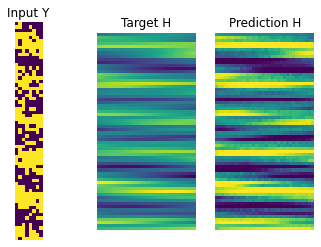

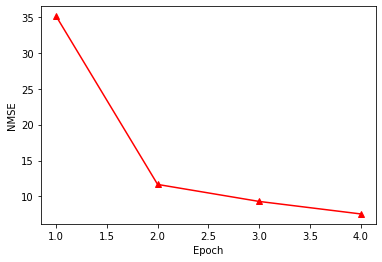

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 11.799739 , Discriminator loss: 1.0668279 , time: 1:20:56.339844
B/E: 1 / 4 , Generator loss: 13.245794 , Discriminator loss: 1.6520591 , time: 1:20:57.054017
B/E: 2 / 4 , Generator loss: 16.600628 , Discriminator loss: 0.7798408 , time: 1:20:57.801129
B/E: 3 / 4 , Generator loss: 13.458134 , Discriminator loss: 0.44263482 , time: 1:20:58.522788
B/E: 4 / 4 , Generator loss: 13.181711 , Discriminator loss: 0.97408414 , time: 1:20:59.267406
B/E: 5 / 4 , Generator loss: 12.802247 , Discriminator loss: 0.34561473 , time: 1:21:00.013022
B/E: 6 / 4 , Generator loss: 16.407038 , Discriminator loss: 0.866169 , time: 1:21:00.763625
B/E: 7 / 4 , Generator loss: 13.415842 , Discriminator loss: 1.0136023 , time: 1:21:01.517224
B/E: 8 / 4 , Generator loss: 14.899652 , Discriminator loss: 0.96515 , time: 1:21:02.275316
B/E: 9 / 4 , Generator loss: 15.659749 , Discriminator loss: 0.91822296 , time: 1:21:03.028419
B/E: 10 / 4 , Generator loss: 13.345428 , Di

B/E: 86 / 4 , Generator loss: 17.508589 , Discriminator loss: 0.74009484 , time: 1:22:00.155280
B/E: 87 / 4 , Generator loss: 13.661607 , Discriminator loss: 0.76789165 , time: 1:22:00.886920
B/E: 88 / 4 , Generator loss: 16.188438 , Discriminator loss: 0.41461146 , time: 1:22:01.624051
B/E: 89 / 4 , Generator loss: 16.001163 , Discriminator loss: 0.3602015 , time: 1:22:02.357687
B/E: 90 / 4 , Generator loss: 19.319391 , Discriminator loss: 0.39147192 , time: 1:22:03.075355
B/E: 91 / 4 , Generator loss: 15.010016 , Discriminator loss: 0.2608183 , time: 1:22:03.796514
B/E: 92 / 4 , Generator loss: 14.220404 , Discriminator loss: 0.7490945 , time: 1:22:04.525659
B/E: 93 / 4 , Generator loss: 14.590584 , Discriminator loss: 1.0098596 , time: 1:22:05.247818
B/E: 94 / 4 , Generator loss: 16.945496 , Discriminator loss: 0.89561206 , time: 1:22:05.984948
B/E: 95 / 4 , Generator loss: 14.543006 , Discriminator loss: 0.5704078 , time: 1:22:06.723577
B/E: 96 / 4 , Generator loss: 13.242419 , Dis

B/E: 172 / 4 , Generator loss: 14.910928 , Discriminator loss: 0.5818197 , time: 1:23:03.129281
B/E: 173 / 4 , Generator loss: 13.628813 , Discriminator loss: 0.50708 , time: 1:23:03.908330
B/E: 174 / 4 , Generator loss: 15.3994 , Discriminator loss: 1.3609235 , time: 1:23:04.686386
B/E: 175 / 4 , Generator loss: 13.005684 , Discriminator loss: 0.5159169 , time: 1:23:05.454957
B/E: 176 / 4 , Generator loss: 12.7288685 , Discriminator loss: 0.5002376 , time: 1:23:06.205563
B/E: 177 / 4 , Generator loss: 16.655968 , Discriminator loss: 0.29908 , time: 1:23:06.925724
B/E: 178 / 4 , Generator loss: 16.125765 , Discriminator loss: 1.2702844 , time: 1:23:07.673337
B/E: 179 / 4 , Generator loss: 13.529514 , Discriminator loss: 0.46651998 , time: 1:23:08.398993
B/E: 180 / 4 , Generator loss: 13.85058 , Discriminator loss: 0.4415481 , time: 1:23:09.117652
B/E: 181 / 4 , Generator loss: 15.52053 , Discriminator loss: 0.22091854 , time: 1:23:09.836815
B/E: 182 / 4 , Generator loss: 14.869384 , Di

B/E: 258 / 4 , Generator loss: 19.030592 , Discriminator loss: 1.1043316 , time: 1:24:06.701665
B/E: 259 / 4 , Generator loss: 14.102377 , Discriminator loss: 1.9438529 , time: 1:24:07.427318
B/E: 260 / 4 , Generator loss: 15.036154 , Discriminator loss: 1.1073959 , time: 1:24:08.155962
B/E: 261 / 4 , Generator loss: 10.999793 , Discriminator loss: 0.7665669 , time: 1:24:08.884113
B/E: 262 / 4 , Generator loss: 14.008841 , Discriminator loss: 1.1839379 , time: 1:24:09.604773
B/E: 263 / 4 , Generator loss: 10.890963 , Discriminator loss: 0.51888996 , time: 1:24:10.358371
B/E: 264 / 4 , Generator loss: 15.985707 , Discriminator loss: 1.927151 , time: 1:24:11.174861
B/E: 265 / 4 , Generator loss: 13.572453 , Discriminator loss: 0.8628544 , time: 1:24:11.941929
B/E: 266 / 4 , Generator loss: 15.355004 , Discriminator loss: 0.2690217 , time: 1:24:12.662590
B/E: 267 / 4 , Generator loss: 13.18239 , Discriminator loss: 0.42450252 , time: 1:24:13.424175
B/E: 268 / 4 , Generator loss: 14.520002

B/E: 344 / 4 , Generator loss: 12.9739685 , Discriminator loss: 0.88728666 , time: 1:25:10.681296
B/E: 345 / 4 , Generator loss: 13.516387 , Discriminator loss: 1.3328161 , time: 1:25:11.439888
B/E: 346 / 4 , Generator loss: 15.539472 , Discriminator loss: 1.1844184 , time: 1:25:12.169530
B/E: 347 / 4 , Generator loss: 12.961667 , Discriminator loss: 0.75177085 , time: 1:25:12.897178
B/E: 348 / 4 , Generator loss: 13.688198 , Discriminator loss: 0.67304695 , time: 1:25:13.624826
B/E: 349 / 4 , Generator loss: 15.09994 , Discriminator loss: 0.7187194 , time: 1:25:14.355972
B/E: 350 / 4 , Generator loss: 13.491194 , Discriminator loss: 0.8633523 , time: 1:25:15.076130
B/E: 351 / 4 , Generator loss: 12.302905 , Discriminator loss: 0.44353935 , time: 1:25:15.834223
B/E: 352 / 4 , Generator loss: 15.704765 , Discriminator loss: 0.2200672 , time: 1:25:16.560875
B/E: 353 / 4 , Generator loss: 15.799829 , Discriminator loss: 0.4683973 , time: 1:25:17.298999
B/E: 354 / 4 , Generator loss: 16.62

B/E: 430 / 4 , Generator loss: 14.691752 , Discriminator loss: 0.24392924 , time: 1:26:14.483256
B/E: 431 / 4 , Generator loss: 15.862626 , Discriminator loss: 1.1146071 , time: 1:26:15.204417
B/E: 432 / 4 , Generator loss: 13.848898 , Discriminator loss: 1.1894878 , time: 1:26:15.937556
B/E: 433 / 4 , Generator loss: 17.771389 , Discriminator loss: 2.3775153 , time: 1:26:16.672190
B/E: 434 / 4 , Generator loss: 14.046742 , Discriminator loss: 2.5712137 , time: 1:26:17.416307
B/E: 435 / 4 , Generator loss: 15.631023 , Discriminator loss: 0.20040736 , time: 1:26:18.195860
B/E: 436 / 4 , Generator loss: 13.152835 , Discriminator loss: 0.38261437 , time: 1:26:18.931991
B/E: 437 / 4 , Generator loss: 17.068195 , Discriminator loss: 0.84614354 , time: 1:26:19.665627
B/E: 438 / 4 , Generator loss: 14.828253 , Discriminator loss: 0.5088807 , time: 1:26:20.397268
B/E: 439 / 4 , Generator loss: 17.312683 , Discriminator loss: 0.40001255 , time: 1:26:21.130406
B/E: 440 / 4 , Generator loss: 13.2

B/E: 516 / 4 , Generator loss: 17.78756 , Discriminator loss: 0.5488028 , time: 1:27:17.625443
B/E: 517 / 4 , Generator loss: 13.913375 , Discriminator loss: 0.64601755 , time: 1:27:18.384144
B/E: 518 / 4 , Generator loss: 20.066006 , Discriminator loss: 0.15016888 , time: 1:27:19.133640
B/E: 519 / 4 , Generator loss: 14.668043 , Discriminator loss: 1.7223818 , time: 1:27:19.861289
B/E: 520 / 4 , Generator loss: 12.609149 , Discriminator loss: 1.3844297 , time: 1:27:20.616386
B/E: 521 / 4 , Generator loss: 18.152212 , Discriminator loss: 0.187104 , time: 1:27:21.360003
B/E: 522 / 4 , Generator loss: 14.536282 , Discriminator loss: 0.32018042 , time: 1:27:22.086155
B/E: 523 / 4 , Generator loss: 15.195591 , Discriminator loss: 0.4577098 , time: 1:27:22.806816
B/E: 524 / 4 , Generator loss: 16.63756 , Discriminator loss: 0.31353143 , time: 1:27:23.558918
B/E: 525 / 4 , Generator loss: 14.106817 , Discriminator loss: 0.32013974 , time: 1:27:24.284571
B/E: 526 / 4 , Generator loss: 16.6696

B/E: 602 / 4 , Generator loss: 13.982798 , Discriminator loss: 0.17321768 , time: 1:28:20.886407
B/E: 603 / 4 , Generator loss: 16.693205 , Discriminator loss: 1.128481 , time: 1:28:21.618547
B/E: 604 / 4 , Generator loss: 13.5465765 , Discriminator loss: 0.3123629 , time: 1:28:22.354680
B/E: 605 / 4 , Generator loss: 13.572507 , Discriminator loss: 0.25234357 , time: 1:28:23.117263
B/E: 606 / 4 , Generator loss: 14.539734 , Discriminator loss: 0.76068616 , time: 1:28:23.859884
B/E: 607 / 4 , Generator loss: 14.009408 , Discriminator loss: 2.0928524 , time: 1:28:24.592521
B/E: 608 / 4 , Generator loss: 18.632973 , Discriminator loss: 0.62216544 , time: 1:28:25.332149
B/E: 609 / 4 , Generator loss: 16.77265 , Discriminator loss: 0.71037555 , time: 1:28:26.067284
B/E: 610 / 4 , Generator loss: 18.255056 , Discriminator loss: 0.34280607 , time: 1:28:26.797425
B/E: 611 / 4 , Generator loss: 12.619308 , Discriminator loss: 0.64189285 , time: 1:28:27.514593
B/E: 612 / 4 , Generator loss: 14.

B/E: 688 / 4 , Generator loss: 17.637579 , Discriminator loss: 1.303333 , time: 1:29:23.945747
B/E: 689 / 4 , Generator loss: 17.161352 , Discriminator loss: 0.84546155 , time: 1:29:24.664414
B/E: 690 / 4 , Generator loss: 14.387992 , Discriminator loss: 1.650104 , time: 1:29:25.416516
B/E: 691 / 4 , Generator loss: 17.334438 , Discriminator loss: 0.29847652 , time: 1:29:26.134682
B/E: 692 / 4 , Generator loss: 15.756904 , Discriminator loss: 0.3908723 , time: 1:29:26.859833
B/E: 693 / 4 , Generator loss: 16.60313 , Discriminator loss: 0.82702667 , time: 1:29:27.585486
B/E: 694 / 4 , Generator loss: 14.25927 , Discriminator loss: 0.5956019 , time: 1:29:28.322116
B/E: 695 / 4 , Generator loss: 19.324366 , Discriminator loss: 0.4072005 , time: 1:29:29.041280
B/E: 696 / 4 , Generator loss: 13.12039 , Discriminator loss: 0.35725385 , time: 1:29:29.775916
B/E: 697 / 4 , Generator loss: 21.647238 , Discriminator loss: 0.29482523 , time: 1:29:30.499072
B/E: 698 / 4 , Generator loss: 14.676732

B/E: 774 / 4 , Generator loss: 15.881871 , Discriminator loss: 1.8504822 , time: 1:30:27.170781
B/E: 775 / 4 , Generator loss: 13.9767 , Discriminator loss: 0.6643771 , time: 1:30:27.932865
B/E: 776 / 4 , Generator loss: 15.658642 , Discriminator loss: 0.9580588 , time: 1:30:28.670995
B/E: 777 / 4 , Generator loss: 18.349358 , Discriminator loss: 0.84721196 , time: 1:30:29.393151
B/E: 778 / 4 , Generator loss: 18.069963 , Discriminator loss: 0.7967706 , time: 1:30:30.123298
B/E: 779 / 4 , Generator loss: 18.695553 , Discriminator loss: 0.27141365 , time: 1:30:30.854936
B/E: 780 / 4 , Generator loss: 12.875309 , Discriminator loss: 0.99637437 , time: 1:30:31.583087
B/E: 781 / 4 , Generator loss: 17.973654 , Discriminator loss: 0.79183793 , time: 1:30:32.322709
B/E: 782 / 4 , Generator loss: 14.373629 , Discriminator loss: 0.58559966 , time: 1:30:33.044866
B/E: 783 / 4 , Generator loss: 16.169401 , Discriminator loss: 0.13004705 , time: 1:30:33.791479
B/E: 784 / 4 , Generator loss: 14.24

B/E: 860 / 4 , Generator loss: 11.625678 , Discriminator loss: 2.2054927 , time: 1:31:30.575479
B/E: 861 / 4 , Generator loss: 14.808212 , Discriminator loss: 1.302675 , time: 1:31:31.298136
B/E: 862 / 4 , Generator loss: 12.694092 , Discriminator loss: 0.78138226 , time: 1:31:32.022789
B/E: 863 / 4 , Generator loss: 13.859688 , Discriminator loss: 0.5311276 , time: 1:31:32.751436
B/E: 864 / 4 , Generator loss: 16.055079 , Discriminator loss: 0.43688366 , time: 1:31:33.472596
B/E: 865 / 4 , Generator loss: 13.558653 , Discriminator loss: 0.7587285 , time: 1:31:34.222703
B/E: 866 / 4 , Generator loss: 20.45551 , Discriminator loss: 0.7985615 , time: 1:31:34.971830
B/E: 867 / 4 , Generator loss: 15.073137 , Discriminator loss: 0.27926853 , time: 1:31:35.687982
B/E: 868 / 4 , Generator loss: 14.287338 , Discriminator loss: 0.6110222 , time: 1:31:36.427106
B/E: 869 / 4 , Generator loss: 18.48249 , Discriminator loss: 0.3159958 , time: 1:31:37.162242
B/E: 870 / 4 , Generator loss: 14.314406

B/E: 946 / 4 , Generator loss: 17.328941 , Discriminator loss: 0.38267815 , time: 1:32:34.087478
B/E: 947 / 4 , Generator loss: 17.50495 , Discriminator loss: 0.6215637 , time: 1:32:34.821614
B/E: 948 / 4 , Generator loss: 12.729565 , Discriminator loss: 0.59258837 , time: 1:32:35.562736
B/E: 949 / 4 , Generator loss: 16.982422 , Discriminator loss: 0.33812082 , time: 1:32:36.295875
B/E: 950 / 4 , Generator loss: 15.447136 , Discriminator loss: 0.30166578 , time: 1:32:37.025019
B/E: 951 / 4 , Generator loss: 19.833553 , Discriminator loss: 0.20619696 , time: 1:32:37.780616
B/E: 952 / 4 , Generator loss: 15.613763 , Discriminator loss: 1.034065 , time: 1:32:38.497285
B/E: 953 / 4 , Generator loss: 17.352432 , Discriminator loss: 0.5791173 , time: 1:32:39.235911
B/E: 954 / 4 , Generator loss: 17.37898 , Discriminator loss: 0.86728954 , time: 1:32:39.968053
B/E: 955 / 4 , Generator loss: 12.698578 , Discriminator loss: 0.9352634 , time: 1:32:40.695701
B/E: 956 / 4 , Generator loss: 16.277

B/E: 1031 / 4 , Generator loss: 16.479177 , Discriminator loss: 0.24400356 , time: 1:33:36.721608
B/E: 1032 / 4 , Generator loss: 17.43483 , Discriminator loss: 0.30147836 , time: 1:33:37.456243
B/E: 1033 / 4 , Generator loss: 19.499802 , Discriminator loss: 0.19731048 , time: 1:33:38.193872
B/E: 1034 / 4 , Generator loss: 13.175508 , Discriminator loss: 0.5182671 , time: 1:33:38.909043
B/E: 1035 / 4 , Generator loss: 19.24141 , Discriminator loss: 0.21737316 , time: 1:33:39.648170
B/E: 1036 / 4 , Generator loss: 13.805596 , Discriminator loss: 0.6143404 , time: 1:33:40.378315
B/E: 1037 / 4 , Generator loss: 15.923215 , Discriminator loss: 0.33107 , time: 1:33:41.103467
B/E: 1038 / 4 , Generator loss: 20.168846 , Discriminator loss: 0.7784409 , time: 1:33:41.825625
B/E: 1039 / 4 , Generator loss: 12.005714 , Discriminator loss: 1.3948116 , time: 1:33:42.550278
B/E: 1040 / 4 , Generator loss: 18.174154 , Discriminator loss: 0.29400724 , time: 1:33:43.283915
B/E: 1041 / 4 , Generator los

B/E: 1116 / 4 , Generator loss: 13.305066 , Discriminator loss: 0.15425608 , time: 1:34:39.228474
B/E: 1117 / 4 , Generator loss: 14.403272 , Discriminator loss: 1.331484 , time: 1:34:39.957622
B/E: 1118 / 4 , Generator loss: 14.770573 , Discriminator loss: 1.015658 , time: 1:34:40.685767
B/E: 1119 / 4 , Generator loss: 15.458116 , Discriminator loss: 0.5370477 , time: 1:34:41.408425
B/E: 1120 / 4 , Generator loss: 15.673193 , Discriminator loss: 2.0236607 , time: 1:34:42.139567
B/E: 1121 / 4 , Generator loss: 13.550408 , Discriminator loss: 1.3680044 , time: 1:34:42.882685
B/E: 1122 / 4 , Generator loss: 16.761312 , Discriminator loss: 0.3807103 , time: 1:34:43.610333
B/E: 1123 / 4 , Generator loss: 15.009468 , Discriminator loss: 0.53402144 , time: 1:34:44.340976
B/E: 1124 / 4 , Generator loss: 16.513111 , Discriminator loss: 1.0731109 , time: 1:34:45.064632
B/E: 1125 / 4 , Generator loss: 13.156177 , Discriminator loss: 0.43836647 , time: 1:34:45.815237
B/E: 1126 / 4 , Generator los

B/E: 1201 / 4 , Generator loss: 15.797715 , Discriminator loss: 0.7002354 , time: 1:35:43.024447
B/E: 1202 / 4 , Generator loss: 15.447588 , Discriminator loss: 0.44844496 , time: 1:35:43.745607
B/E: 1203 / 4 , Generator loss: 21.5666 , Discriminator loss: 0.20870264 , time: 1:35:44.480740
B/E: 1204 / 4 , Generator loss: 15.8102 , Discriminator loss: 0.7523269 , time: 1:35:45.227851
B/E: 1205 / 4 , Generator loss: 11.480552 , Discriminator loss: 1.0420728 , time: 1:35:45.962488
B/E: 1206 / 4 , Generator loss: 16.285648 , Discriminator loss: 0.527251 , time: 1:35:46.757011
B/E: 1207 / 4 , Generator loss: 15.02528 , Discriminator loss: 0.85498595 , time: 1:35:47.481166
B/E: 1208 / 4 , Generator loss: 15.624493 , Discriminator loss: 1.2090385 , time: 1:35:48.220792
B/E: 1209 / 4 , Generator loss: 13.780135 , Discriminator loss: 0.5142434 , time: 1:35:48.954429
B/E: 1210 / 4 , Generator loss: 16.93959 , Discriminator loss: 0.098584816 , time: 1:35:49.691559
B/E: 1211 / 4 , Generator loss: 

B/E: 1286 / 4 , Generator loss: 15.918913 , Discriminator loss: 0.155089 , time: 1:36:45.647596
B/E: 1287 / 4 , Generator loss: 14.321391 , Discriminator loss: 0.48675764 , time: 1:36:46.391215
B/E: 1288 / 4 , Generator loss: 14.128055 , Discriminator loss: 0.3747833 , time: 1:36:47.171267
B/E: 1289 / 4 , Generator loss: 12.103807 , Discriminator loss: 0.7997166 , time: 1:36:47.931354
B/E: 1290 / 4 , Generator loss: 18.040483 , Discriminator loss: 0.1741419 , time: 1:36:48.747338
B/E: 1291 / 4 , Generator loss: 15.208413 , Discriminator loss: 1.0028102 , time: 1:36:49.490457
B/E: 1292 / 4 , Generator loss: 14.426295 , Discriminator loss: 0.5809661 , time: 1:36:50.214611
B/E: 1293 / 4 , Generator loss: 16.040678 , Discriminator loss: 0.8108744 , time: 1:36:50.944258
B/E: 1294 / 4 , Generator loss: 11.902175 , Discriminator loss: 1.701403 , time: 1:36:51.672901
B/E: 1295 / 4 , Generator loss: 18.289919 , Discriminator loss: 0.17833918 , time: 1:36:52.405541
B/E: 1296 / 4 , Generator loss

B/E: 1371 / 4 , Generator loss: 18.087337 , Discriminator loss: 0.16473845 , time: 1:37:48.182910
B/E: 1372 / 4 , Generator loss: 14.662035 , Discriminator loss: 0.45617148 , time: 1:37:48.912055
B/E: 1373 / 4 , Generator loss: 14.254346 , Discriminator loss: 0.275097 , time: 1:37:49.651181
B/E: 1374 / 4 , Generator loss: 13.888805 , Discriminator loss: 0.8666879 , time: 1:37:50.386815
B/E: 1375 / 4 , Generator loss: 14.184535 , Discriminator loss: 0.42953792 , time: 1:37:51.103484
B/E: 1376 / 4 , Generator loss: 17.593952 , Discriminator loss: 0.66235507 , time: 1:37:51.827139
B/E: 1377 / 4 , Generator loss: 15.595768 , Discriminator loss: 0.7838471 , time: 1:37:52.546303
B/E: 1378 / 4 , Generator loss: 17.949118 , Discriminator loss: 0.11380389 , time: 1:37:53.273951
B/E: 1379 / 4 , Generator loss: 16.454584 , Discriminator loss: 0.59857154 , time: 1:37:54.017071
B/E: 1380 / 4 , Generator loss: 11.955724 , Discriminator loss: 0.9783784 , time: 1:37:54.748712
B/E: 1381 / 4 , Generator

B/E: 1456 / 4 , Generator loss: 17.518406 , Discriminator loss: 0.297427 , time: 1:38:50.835506
B/E: 1457 / 4 , Generator loss: 12.830299 , Discriminator loss: 1.3655825 , time: 1:38:51.570141
B/E: 1458 / 4 , Generator loss: 19.053637 , Discriminator loss: 2.8392153 , time: 1:38:52.306773
B/E: 1459 / 4 , Generator loss: 12.900563 , Discriminator loss: 0.71991575 , time: 1:38:53.024938
B/E: 1460 / 4 , Generator loss: 17.35318 , Discriminator loss: 0.51264423 , time: 1:38:53.757578
B/E: 1461 / 4 , Generator loss: 15.548991 , Discriminator loss: 0.8086551 , time: 1:38:54.491217
B/E: 1462 / 4 , Generator loss: 16.138773 , Discriminator loss: 1.2249321 , time: 1:38:55.213871
B/E: 1463 / 4 , Generator loss: 13.980767 , Discriminator loss: 0.870069 , time: 1:38:55.940524
B/E: 1464 / 4 , Generator loss: 15.594751 , Discriminator loss: 0.5479516 , time: 1:38:56.668669
B/E: 1465 / 4 , Generator loss: 16.096462 , Discriminator loss: 0.90276515 , time: 1:38:57.434745
B/E: 1466 / 4 , Generator loss

B/E: 1541 / 4 , Generator loss: 15.3109665 , Discriminator loss: 0.33417255 , time: 1:39:53.583924
B/E: 1542 / 4 , Generator loss: 15.733024 , Discriminator loss: 0.32719713 , time: 1:39:54.368966
B/E: 1543 / 4 , Generator loss: 15.372786 , Discriminator loss: 0.15654415 , time: 1:39:55.103101
B/E: 1544 / 4 , Generator loss: 13.931117 , Discriminator loss: 1.5986269 , time: 1:39:55.839233
B/E: 1545 / 4 , Generator loss: 11.926972 , Discriminator loss: 0.7186144 , time: 1:39:56.578860


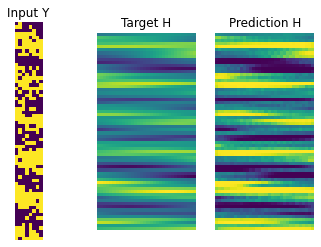

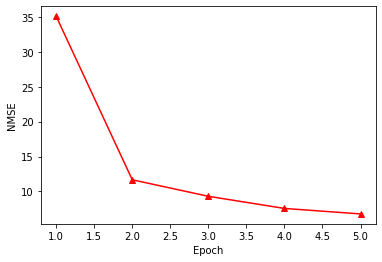

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 15.300201 , Discriminator loss: 0.318698 , time: 1:40:47.401935
B/E: 1 / 5 , Generator loss: 13.496134 , Discriminator loss: 0.18590966 , time: 1:40:48.184482
B/E: 2 / 5 , Generator loss: 16.45481 , Discriminator loss: 0.41768348 , time: 1:40:48.978504
B/E: 3 / 5 , Generator loss: 15.688706 , Discriminator loss: 0.601718 , time: 1:40:49.714637
B/E: 4 / 5 , Generator loss: 10.713322 , Discriminator loss: 1.0193795 , time: 1:40:50.456760
B/E: 5 / 5 , Generator loss: 14.380111 , Discriminator loss: 0.9275017 , time: 1:40:51.249784
B/E: 6 / 5 , Generator loss: 13.619412 , Discriminator loss: 0.87072504 , time: 1:40:52.018856
B/E: 7 / 5 , Generator loss: 14.789771 , Discriminator loss: 0.6979229 , time: 1:40:52.769961
B/E: 8 / 5 , Generator loss: 13.441305 , Discriminator loss: 0.12902501 , time: 1:40:53.505594
B/E: 9 / 5 , Generator loss: 12.140467 , Discriminator loss: 0.7083447 , time: 1:40:54.238732
B/E: 10 / 5 , Generator loss: 12.9382 , Disc

B/E: 86 / 5 , Generator loss: 13.656445 , Discriminator loss: 0.91952646 , time: 1:41:50.937888
B/E: 87 / 5 , Generator loss: 14.415945 , Discriminator loss: 0.68374944 , time: 1:41:51.660547
B/E: 88 / 5 , Generator loss: 14.983006 , Discriminator loss: 0.25196627 , time: 1:41:52.385699
B/E: 89 / 5 , Generator loss: 17.015757 , Discriminator loss: 0.16480057 , time: 1:41:53.109853
B/E: 90 / 5 , Generator loss: 12.80592 , Discriminator loss: 0.69213724 , time: 1:41:53.857965
B/E: 91 / 5 , Generator loss: 16.726372 , Discriminator loss: 2.6564667 , time: 1:41:54.577629
B/E: 92 / 5 , Generator loss: 12.7958 , Discriminator loss: 0.70303565 , time: 1:41:55.344702
B/E: 93 / 5 , Generator loss: 14.147352 , Discriminator loss: 0.58475035 , time: 1:41:56.076341
B/E: 94 / 5 , Generator loss: 12.571056 , Discriminator loss: 0.41715497 , time: 1:41:56.800995
B/E: 95 / 5 , Generator loss: 15.094058 , Discriminator loss: 0.21425733 , time: 1:41:57.528644
B/E: 96 / 5 , Generator loss: 13.540659 , Di

B/E: 172 / 5 , Generator loss: 14.288444 , Discriminator loss: 2.5510323 , time: 1:42:54.496801
B/E: 173 / 5 , Generator loss: 11.365072 , Discriminator loss: 0.84225553 , time: 1:42:55.221454
B/E: 174 / 5 , Generator loss: 14.359397 , Discriminator loss: 0.09668411 , time: 1:42:55.946108
B/E: 175 / 5 , Generator loss: 15.84624 , Discriminator loss: 0.42231002 , time: 1:42:56.667268
B/E: 176 / 5 , Generator loss: 12.745411 , Discriminator loss: 0.16268486 , time: 1:42:57.420868
B/E: 177 / 5 , Generator loss: 13.692641 , Discriminator loss: 0.23748396 , time: 1:42:58.143029
B/E: 178 / 5 , Generator loss: 16.208998 , Discriminator loss: 0.38278165 , time: 1:42:58.863687
B/E: 179 / 5 , Generator loss: 14.617435 , Discriminator loss: 0.24242817 , time: 1:42:59.600817
B/E: 180 / 5 , Generator loss: 13.895958 , Discriminator loss: 0.32351324 , time: 1:43:00.346432
B/E: 181 / 5 , Generator loss: 15.025731 , Discriminator loss: 0.17815909 , time: 1:43:01.061104
B/E: 182 / 5 , Generator loss: 1

B/E: 257 / 5 , Generator loss: 12.434164 , Discriminator loss: 1.2755492 , time: 1:43:57.365994
B/E: 258 / 5 , Generator loss: 14.269787 , Discriminator loss: 2.3402667 , time: 1:43:58.167005
B/E: 259 / 5 , Generator loss: 15.2801485 , Discriminator loss: 0.7056161 , time: 1:43:58.917113
B/E: 260 / 5 , Generator loss: 13.923559 , Discriminator loss: 0.20162202 , time: 1:43:59.648754
B/E: 261 / 5 , Generator loss: 14.101119 , Discriminator loss: 0.081007555 , time: 1:44:00.427805
B/E: 262 / 5 , Generator loss: 14.036104 , Discriminator loss: 0.30483782 , time: 1:44:01.159446
B/E: 263 / 5 , Generator loss: 12.806877 , Discriminator loss: 0.27867547 , time: 1:44:01.879108
B/E: 264 / 5 , Generator loss: 13.678788 , Discriminator loss: 1.1339861 , time: 1:44:02.598274
B/E: 265 / 5 , Generator loss: 11.011522 , Discriminator loss: 0.33747962 , time: 1:44:03.340901
B/E: 266 / 5 , Generator loss: 10.859044 , Discriminator loss: 0.7494555 , time: 1:44:04.072034
B/E: 267 / 5 , Generator loss: 13

B/E: 343 / 5 , Generator loss: 16.278782 , Discriminator loss: 0.27528253 , time: 1:45:00.682855
B/E: 344 / 5 , Generator loss: 14.364291 , Discriminator loss: 0.6024683 , time: 1:45:01.426475
B/E: 345 / 5 , Generator loss: 12.401926 , Discriminator loss: 1.3885293 , time: 1:45:02.160610
B/E: 346 / 5 , Generator loss: 20.810646 , Discriminator loss: 1.1900375 , time: 1:45:02.918202
B/E: 347 / 5 , Generator loss: 15.02106 , Discriminator loss: 1.0172672 , time: 1:45:03.646350
B/E: 348 / 5 , Generator loss: 12.960809 , Discriminator loss: 0.35008442 , time: 1:45:04.381983
B/E: 349 / 5 , Generator loss: 13.592017 , Discriminator loss: 1.6648645 , time: 1:45:05.097156
B/E: 350 / 5 , Generator loss: 10.953177 , Discriminator loss: 2.3194344 , time: 1:45:05.825800
B/E: 351 / 5 , Generator loss: 14.356357 , Discriminator loss: 0.6068223 , time: 1:45:06.553947
B/E: 352 / 5 , Generator loss: 14.585861 , Discriminator loss: 0.1923198 , time: 1:45:07.275107
B/E: 353 / 5 , Generator loss: 17.29368

B/E: 429 / 5 , Generator loss: 17.29869 , Discriminator loss: 3.512227 , time: 1:46:03.946818
B/E: 430 / 5 , Generator loss: 12.640808 , Discriminator loss: 0.8506196 , time: 1:46:04.694926
B/E: 431 / 5 , Generator loss: 18.201746 , Discriminator loss: 0.13370697 , time: 1:46:05.460004
B/E: 432 / 5 , Generator loss: 12.565497 , Discriminator loss: 0.77924615 , time: 1:46:06.184159
B/E: 433 / 5 , Generator loss: 13.422369 , Discriminator loss: 0.710533 , time: 1:46:06.912306
B/E: 434 / 5 , Generator loss: 14.251486 , Discriminator loss: 1.5620716 , time: 1:46:07.642949
B/E: 435 / 5 , Generator loss: 11.47414 , Discriminator loss: 0.95027626 , time: 1:46:08.383073
B/E: 436 / 5 , Generator loss: 14.0631695 , Discriminator loss: 0.3103599 , time: 1:46:09.114714
B/E: 437 / 5 , Generator loss: 13.829144 , Discriminator loss: 0.39226097 , time: 1:46:09.829387
B/E: 438 / 5 , Generator loss: 13.421189 , Discriminator loss: 0.17872365 , time: 1:46:10.567514
B/E: 439 / 5 , Generator loss: 13.8123

B/E: 515 / 5 , Generator loss: 15.248328 , Discriminator loss: 1.3393968 , time: 1:47:07.048078
B/E: 516 / 5 , Generator loss: 12.165705 , Discriminator loss: 1.5708442 , time: 1:47:07.767741
B/E: 517 / 5 , Generator loss: 14.151358 , Discriminator loss: 0.124801934 , time: 1:47:08.497883
B/E: 518 / 5 , Generator loss: 16.195602 , Discriminator loss: 0.36903182 , time: 1:47:09.234515
B/E: 519 / 5 , Generator loss: 14.221069 , Discriminator loss: 0.21866986 , time: 1:47:09.956674
B/E: 520 / 5 , Generator loss: 17.792599 , Discriminator loss: 0.1768389 , time: 1:47:10.683823
B/E: 521 / 5 , Generator loss: 14.324626 , Discriminator loss: 0.14422417 , time: 1:47:11.424449
B/E: 522 / 5 , Generator loss: 14.367383 , Discriminator loss: 0.50252336 , time: 1:47:12.176550
B/E: 523 / 5 , Generator loss: 12.576599 , Discriminator loss: 1.6585945 , time: 1:47:12.903700
B/E: 524 / 5 , Generator loss: 15.817852 , Discriminator loss: 2.1873462 , time: 1:47:13.632344
B/E: 525 / 5 , Generator loss: 13.

B/E: 600 / 5 , Generator loss: 15.541548 , Discriminator loss: 0.34003985 , time: 1:48:09.414706
B/E: 601 / 5 , Generator loss: 15.004456 , Discriminator loss: 1.3256692 , time: 1:48:10.133870
B/E: 602 / 5 , Generator loss: 16.940296 , Discriminator loss: 1.3545524 , time: 1:48:10.865509
B/E: 603 / 5 , Generator loss: 17.410618 , Discriminator loss: 1.4446185 , time: 1:48:11.598647
B/E: 604 / 5 , Generator loss: 12.752654 , Discriminator loss: 1.3304657 , time: 1:48:12.336776
B/E: 605 / 5 , Generator loss: 14.932547 , Discriminator loss: 1.70656 , time: 1:48:13.070413
B/E: 606 / 5 , Generator loss: 14.431123 , Discriminator loss: 0.4530586 , time: 1:48:13.802552
B/E: 607 / 5 , Generator loss: 16.421383 , Discriminator loss: 1.1629773 , time: 1:48:14.556153
B/E: 608 / 5 , Generator loss: 13.175902 , Discriminator loss: 1.5942798 , time: 1:48:15.293284
B/E: 609 / 5 , Generator loss: 13.3074465 , Discriminator loss: 0.5605639 , time: 1:48:16.037401
B/E: 610 / 5 , Generator loss: 13.056167

B/E: 686 / 5 , Generator loss: 11.333404 , Discriminator loss: 1.7680272 , time: 1:49:12.647722
B/E: 687 / 5 , Generator loss: 15.599627 , Discriminator loss: 0.15048695 , time: 1:49:13.388845
B/E: 688 / 5 , Generator loss: 17.849388 , Discriminator loss: 1.2305582 , time: 1:49:14.136456
B/E: 689 / 5 , Generator loss: 11.754318 , Discriminator loss: 1.3089654 , time: 1:49:14.873587
B/E: 690 / 5 , Generator loss: 13.346982 , Discriminator loss: 1.0208647 , time: 1:49:15.616208
B/E: 691 / 5 , Generator loss: 13.493449 , Discriminator loss: 0.8987277 , time: 1:49:16.377792
B/E: 692 / 5 , Generator loss: 14.272172 , Discriminator loss: 1.0442408 , time: 1:49:17.103943
B/E: 693 / 5 , Generator loss: 14.570295 , Discriminator loss: 0.28475082 , time: 1:49:17.829596
B/E: 694 / 5 , Generator loss: 12.611464 , Discriminator loss: 0.45527908 , time: 1:49:18.559738
B/E: 695 / 5 , Generator loss: 22.690315 , Discriminator loss: 0.35491744 , time: 1:49:19.293376
B/E: 696 / 5 , Generator loss: 15.81

B/E: 771 / 5 , Generator loss: 13.997868 , Discriminator loss: 0.40553993 , time: 1:50:15.369193
B/E: 772 / 5 , Generator loss: 14.101758 , Discriminator loss: 0.31715906 , time: 1:50:16.106321
B/E: 773 / 5 , Generator loss: 16.93356 , Discriminator loss: 0.62797946 , time: 1:50:16.834967
B/E: 774 / 5 , Generator loss: 10.259196 , Discriminator loss: 1.7690303 , time: 1:50:17.564112
B/E: 775 / 5 , Generator loss: 18.051352 , Discriminator loss: 0.32055643 , time: 1:50:18.315717
B/E: 776 / 5 , Generator loss: 14.955086 , Discriminator loss: 0.18138228 , time: 1:50:19.032883
B/E: 777 / 5 , Generator loss: 17.903809 , Discriminator loss: 0.32840493 , time: 1:50:19.764025
B/E: 778 / 5 , Generator loss: 13.946457 , Discriminator loss: 0.2189148 , time: 1:50:20.503652
B/E: 779 / 5 , Generator loss: 12.706674 , Discriminator loss: 0.24515864 , time: 1:50:21.241280
B/E: 780 / 5 , Generator loss: 14.443899 , Discriminator loss: 1.2290695 , time: 1:50:21.969427
B/E: 781 / 5 , Generator loss: 12.

B/E: 857 / 5 , Generator loss: 15.229963 , Discriminator loss: 0.6108377 , time: 1:51:18.515868
B/E: 858 / 5 , Generator loss: 12.391465 , Discriminator loss: 0.43421924 , time: 1:51:19.240024
B/E: 859 / 5 , Generator loss: 14.525947 , Discriminator loss: 0.11853156 , time: 1:51:19.966174
B/E: 860 / 5 , Generator loss: 14.366332 , Discriminator loss: 0.6337999 , time: 1:51:20.693324
B/E: 861 / 5 , Generator loss: 12.692287 , Discriminator loss: 1.3765125 , time: 1:51:21.418476
B/E: 862 / 5 , Generator loss: 18.872168 , Discriminator loss: 0.1322456 , time: 1:51:22.248434
B/E: 863 / 5 , Generator loss: 14.314249 , Discriminator loss: 0.0918758 , time: 1:51:23.037467
B/E: 864 / 5 , Generator loss: 15.488229 , Discriminator loss: 0.15740371 , time: 1:51:23.770106
B/E: 865 / 5 , Generator loss: 16.130333 , Discriminator loss: 1.035878 , time: 1:51:24.492267
B/E: 866 / 5 , Generator loss: 15.731398 , Discriminator loss: 1.1903049 , time: 1:51:25.225403
B/E: 867 / 5 , Generator loss: 15.7333

B/E: 942 / 5 , Generator loss: 12.732892 , Discriminator loss: 0.52722514 , time: 1:52:21.068649
B/E: 943 / 5 , Generator loss: 15.583491 , Discriminator loss: 1.4308475 , time: 1:52:21.809273
B/E: 944 / 5 , Generator loss: 11.021056 , Discriminator loss: 0.8310791 , time: 1:52:22.541912
B/E: 945 / 5 , Generator loss: 16.41124 , Discriminator loss: 0.120321125 , time: 1:52:23.283534
B/E: 946 / 5 , Generator loss: 14.935333 , Discriminator loss: 0.43726844 , time: 1:52:24.008687
B/E: 947 / 5 , Generator loss: 12.982504 , Discriminator loss: 0.10533406 , time: 1:52:24.749811
B/E: 948 / 5 , Generator loss: 15.616999 , Discriminator loss: 0.28930348 , time: 1:52:25.477958
B/E: 949 / 5 , Generator loss: 18.62355 , Discriminator loss: 0.08504647 , time: 1:52:26.221576
B/E: 950 / 5 , Generator loss: 14.652316 , Discriminator loss: 0.17146851 , time: 1:52:26.944732
B/E: 951 / 5 , Generator loss: 15.530647 , Discriminator loss: 0.51885736 , time: 1:52:27.676372
B/E: 952 / 5 , Generator loss: 14

B/E: 1027 / 5 , Generator loss: 16.516712 , Discriminator loss: 0.19627713 , time: 1:53:23.802095
B/E: 1028 / 5 , Generator loss: 13.463648 , Discriminator loss: 1.6714516 , time: 1:53:24.535732
B/E: 1029 / 5 , Generator loss: 14.177037 , Discriminator loss: 1.0962392 , time: 1:53:25.273363
B/E: 1030 / 5 , Generator loss: 14.959999 , Discriminator loss: 0.35361105 , time: 1:53:26.001010
B/E: 1031 / 5 , Generator loss: 12.165361 , Discriminator loss: 0.35531688 , time: 1:53:26.733648
B/E: 1032 / 5 , Generator loss: 12.727635 , Discriminator loss: 0.8141741 , time: 1:53:27.469782
B/E: 1033 / 5 , Generator loss: 14.765373 , Discriminator loss: 0.24059714 , time: 1:53:28.191939
B/E: 1034 / 5 , Generator loss: 13.09226 , Discriminator loss: 0.7697921 , time: 1:53:28.927073
B/E: 1035 / 5 , Generator loss: 14.884931 , Discriminator loss: 1.0113274 , time: 1:53:29.674685
B/E: 1036 / 5 , Generator loss: 14.895027 , Discriminator loss: 0.6391259 , time: 1:53:30.394847
B/E: 1037 / 5 , Generator l

B/E: 1112 / 5 , Generator loss: 15.517346 , Discriminator loss: 0.2890409 , time: 1:54:27.043597
B/E: 1113 / 5 , Generator loss: 13.849339 , Discriminator loss: 1.0933002 , time: 1:54:27.780728
B/E: 1114 / 5 , Generator loss: 15.462329 , Discriminator loss: 0.24837275 , time: 1:54:28.507876
B/E: 1115 / 5 , Generator loss: 17.289274 , Discriminator loss: 0.2687121 , time: 1:54:29.234028
B/E: 1116 / 5 , Generator loss: 13.86973 , Discriminator loss: 0.28355742 , time: 1:54:29.956684
B/E: 1117 / 5 , Generator loss: 14.681581 , Discriminator loss: 0.52227324 , time: 1:54:30.679841
B/E: 1118 / 5 , Generator loss: 14.644921 , Discriminator loss: 0.30466065 , time: 1:54:31.415973
B/E: 1119 / 5 , Generator loss: 14.176033 , Discriminator loss: 0.11226519 , time: 1:54:32.138631
B/E: 1120 / 5 , Generator loss: 18.74056 , Discriminator loss: 0.59759027 , time: 1:54:32.859291
B/E: 1121 / 5 , Generator loss: 11.10709 , Discriminator loss: 1.0162578 , time: 1:54:33.600915
B/E: 1122 / 5 , Generator l

B/E: 1197 / 5 , Generator loss: 12.516439 , Discriminator loss: 1.8434529 , time: 1:55:31.186923
B/E: 1198 / 5 , Generator loss: 12.269209 , Discriminator loss: 0.7865414 , time: 1:55:31.908082
B/E: 1199 / 5 , Generator loss: 12.820512 , Discriminator loss: 0.22240451 , time: 1:55:32.639723
B/E: 1200 / 5 , Generator loss: 14.328801 , Discriminator loss: 2.5539854 , time: 1:55:33.382843
B/E: 1201 / 5 , Generator loss: 14.309243 , Discriminator loss: 1.2842256 , time: 1:55:34.094026
B/E: 1202 / 5 , Generator loss: 13.535098 , Discriminator loss: 0.81840193 , time: 1:55:34.825662
B/E: 1203 / 5 , Generator loss: 15.349458 , Discriminator loss: 0.25493258 , time: 1:55:35.556305
B/E: 1204 / 5 , Generator loss: 13.551684 , Discriminator loss: 0.2325599 , time: 1:55:36.294933
B/E: 1205 / 5 , Generator loss: 13.6355095 , Discriminator loss: 0.43053156 , time: 1:55:37.046037
B/E: 1206 / 5 , Generator loss: 15.460856 , Discriminator loss: 0.19294855 , time: 1:55:37.773687
B/E: 1207 / 5 , Generato

B/E: 1282 / 5 , Generator loss: 16.426489 , Discriminator loss: 0.07092652 , time: 1:56:33.517616
B/E: 1283 / 5 , Generator loss: 13.476331 , Discriminator loss: 0.14505795 , time: 1:56:34.247762
B/E: 1284 / 5 , Generator loss: 15.62107 , Discriminator loss: 0.3465699 , time: 1:56:34.975908
B/E: 1285 / 5 , Generator loss: 10.030872 , Discriminator loss: 1.074189 , time: 1:56:35.696568
B/E: 1286 / 5 , Generator loss: 18.704626 , Discriminator loss: 0.44344467 , time: 1:56:36.453162
B/E: 1287 / 5 , Generator loss: 17.23418 , Discriminator loss: 0.07819174 , time: 1:56:37.180312
B/E: 1288 / 5 , Generator loss: 15.423086 , Discriminator loss: 0.14533803 , time: 1:56:37.908960
B/E: 1289 / 5 , Generator loss: 15.44281 , Discriminator loss: 0.21460178 , time: 1:56:38.635608
B/E: 1290 / 5 , Generator loss: 12.55963 , Discriminator loss: 0.34260213 , time: 1:56:39.383720
B/E: 1291 / 5 , Generator loss: 15.702293 , Discriminator loss: 0.14296308 , time: 1:56:40.101385
B/E: 1292 / 5 , Generator l

B/E: 1367 / 5 , Generator loss: 19.250416 , Discriminator loss: 0.2516252 , time: 1:57:35.648682
B/E: 1368 / 5 , Generator loss: 15.7239685 , Discriminator loss: 0.4411988 , time: 1:57:36.396293
B/E: 1369 / 5 , Generator loss: 12.842425 , Discriminator loss: 0.90175223 , time: 1:57:37.130429
B/E: 1370 / 5 , Generator loss: 17.468956 , Discriminator loss: 1.4135834 , time: 1:57:37.854583
B/E: 1371 / 5 , Generator loss: 12.878619 , Discriminator loss: 0.2723661 , time: 1:57:38.580734
B/E: 1372 / 5 , Generator loss: 16.740332 , Discriminator loss: 0.2848959 , time: 1:57:39.313375
B/E: 1373 / 5 , Generator loss: 17.458855 , Discriminator loss: 0.11412254 , time: 1:57:40.035034
B/E: 1374 / 5 , Generator loss: 17.279451 , Discriminator loss: 0.4234193 , time: 1:57:40.761682
B/E: 1375 / 5 , Generator loss: 13.597584 , Discriminator loss: 0.48363262 , time: 1:57:41.509791
B/E: 1376 / 5 , Generator loss: 16.91941 , Discriminator loss: 2.1588356 , time: 1:57:42.225462
B/E: 1377 / 5 , Generator l

B/E: 1452 / 5 , Generator loss: 16.56403 , Discriminator loss: 1.0089623 , time: 1:58:38.611202
B/E: 1453 / 5 , Generator loss: 12.637321 , Discriminator loss: 0.8967391 , time: 1:58:39.345338
B/E: 1454 / 5 , Generator loss: 17.86398 , Discriminator loss: 0.12445186 , time: 1:58:40.054521
B/E: 1455 / 5 , Generator loss: 16.672297 , Discriminator loss: 0.63154733 , time: 1:58:40.797140
B/E: 1456 / 5 , Generator loss: 13.283197 , Discriminator loss: 0.48899266 , time: 1:58:41.536766
B/E: 1457 / 5 , Generator loss: 14.246368 , Discriminator loss: 0.8154166 , time: 1:58:42.260921
B/E: 1458 / 5 , Generator loss: 13.757034 , Discriminator loss: 0.3158906 , time: 1:58:42.992562
B/E: 1459 / 5 , Generator loss: 16.993324 , Discriminator loss: 0.13487437 , time: 1:58:43.740174
B/E: 1460 / 5 , Generator loss: 15.244609 , Discriminator loss: 0.08417851 , time: 1:58:44.471812
B/E: 1461 / 5 , Generator loss: 17.347054 , Discriminator loss: 0.063269936 , time: 1:58:45.191477
B/E: 1462 / 5 , Generator

B/E: 1537 / 5 , Generator loss: 13.058707 , Discriminator loss: 0.50781643 , time: 1:59:40.760233
B/E: 1538 / 5 , Generator loss: 12.104458 , Discriminator loss: 0.4511448 , time: 1:59:41.496365
B/E: 1539 / 5 , Generator loss: 16.447226 , Discriminator loss: 0.13769412 , time: 1:59:42.229003
B/E: 1540 / 5 , Generator loss: 16.131319 , Discriminator loss: 0.6078226 , time: 1:59:42.954656
B/E: 1541 / 5 , Generator loss: 16.204308 , Discriminator loss: 0.46650833 , time: 1:59:43.676316
B/E: 1542 / 5 , Generator loss: 13.7303295 , Discriminator loss: 0.37275344 , time: 1:59:44.403465
B/E: 1543 / 5 , Generator loss: 15.459029 , Discriminator loss: 0.21620741 , time: 1:59:45.131112
B/E: 1544 / 5 , Generator loss: 15.84135 , Discriminator loss: 0.0673824 , time: 1:59:45.851274
B/E: 1545 / 5 , Generator loss: 14.349321 , Discriminator loss: 0.13590488 , time: 1:59:46.625835


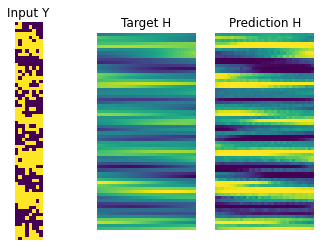

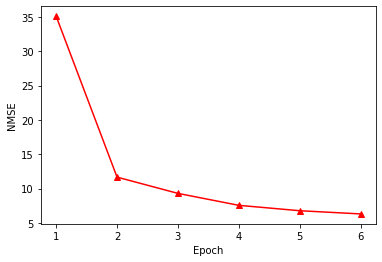

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 14.687893 , Discriminator loss: 0.09908783 , time: 2:00:37.597137
B/E: 1 / 6 , Generator loss: 15.098251 , Discriminator loss: 0.21447825 , time: 2:00:38.392656
B/E: 2 / 6 , Generator loss: 15.679551 , Discriminator loss: 0.061171986 , time: 2:00:39.189675
B/E: 3 / 6 , Generator loss: 11.895187 , Discriminator loss: 0.5070775 , time: 2:00:39.970724
B/E: 4 / 6 , Generator loss: 16.921333 , Discriminator loss: 2.7139902 , time: 2:00:40.727319
B/E: 5 / 6 , Generator loss: 13.713326 , Discriminator loss: 2.1206725 , time: 2:00:41.474930
B/E: 6 / 6 , Generator loss: 13.454547 , Discriminator loss: 0.21689343 , time: 2:00:42.201082
B/E: 7 / 6 , Generator loss: 13.451923 , Discriminator loss: 0.17607988 , time: 2:00:42.978636
B/E: 8 / 6 , Generator loss: 16.832153 , Discriminator loss: 0.07824302 , time: 2:00:43.742717
B/E: 9 / 6 , Generator loss: 15.179667 , Discriminator loss: 0.08414039 , time: 2:00:44.496317
B/E: 10 / 6 , Generator loss: 15.3127

B/E: 86 / 6 , Generator loss: 14.035806 , Discriminator loss: 0.9700685 , time: 2:01:41.577763
B/E: 87 / 6 , Generator loss: 14.4629 , Discriminator loss: 0.2732854 , time: 2:01:42.307906
B/E: 88 / 6 , Generator loss: 15.564566 , Discriminator loss: 0.08973326 , time: 2:01:43.031562
B/E: 89 / 6 , Generator loss: 14.000738 , Discriminator loss: 0.7432909 , time: 2:01:43.771189
B/E: 90 / 6 , Generator loss: 12.857176 , Discriminator loss: 0.9340046 , time: 2:01:44.497339
B/E: 91 / 6 , Generator loss: 16.906586 , Discriminator loss: 0.21313363 , time: 2:01:45.225486
B/E: 92 / 6 , Generator loss: 13.943593 , Discriminator loss: 0.23710018 , time: 2:01:45.960619
B/E: 93 / 6 , Generator loss: 13.45537 , Discriminator loss: 0.14141652 , time: 2:01:46.691762
B/E: 94 / 6 , Generator loss: 14.429709 , Discriminator loss: 0.1936972 , time: 2:01:47.434881
B/E: 95 / 6 , Generator loss: 13.743407 , Discriminator loss: 0.5127636 , time: 2:01:48.175505
B/E: 96 / 6 , Generator loss: 14.3066225 , Discri

B/E: 172 / 6 , Generator loss: 12.974735 , Discriminator loss: 0.80036294 , time: 2:02:45.263939
B/E: 173 / 6 , Generator loss: 14.75088 , Discriminator loss: 0.10607231 , time: 2:02:45.956152
B/E: 174 / 6 , Generator loss: 12.595686 , Discriminator loss: 0.3133319 , time: 2:02:46.727220
B/E: 175 / 6 , Generator loss: 16.912004 , Discriminator loss: 0.1062606 , time: 2:02:47.473333
B/E: 176 / 6 , Generator loss: 14.552265 , Discriminator loss: 0.6501733 , time: 2:02:48.192497
B/E: 177 / 6 , Generator loss: 10.474017 , Discriminator loss: 1.0728811 , time: 2:02:48.940608
B/E: 178 / 6 , Generator loss: 14.469109 , Discriminator loss: 3.3251312 , time: 2:02:49.706184
B/E: 179 / 6 , Generator loss: 13.571451 , Discriminator loss: 1.2900834 , time: 2:02:50.441818
B/E: 180 / 6 , Generator loss: 16.370556 , Discriminator loss: 0.11713577 , time: 2:02:51.145512
B/E: 181 / 6 , Generator loss: 12.993283 , Discriminator loss: 0.28961203 , time: 2:02:51.888633
B/E: 182 / 6 , Generator loss: 13.754

B/E: 257 / 6 , Generator loss: 13.863109 , Discriminator loss: 0.62630594 , time: 2:03:48.627714
B/E: 258 / 6 , Generator loss: 11.158132 , Discriminator loss: 0.75613445 , time: 2:03:49.381313
B/E: 259 / 6 , Generator loss: 18.425655 , Discriminator loss: 1.1270224 , time: 2:03:50.073027
B/E: 260 / 6 , Generator loss: 10.804511 , Discriminator loss: 0.88838387 , time: 2:03:50.862560
B/E: 261 / 6 , Generator loss: 16.257627 , Discriminator loss: 0.8872607 , time: 2:03:51.584219
B/E: 262 / 6 , Generator loss: 16.526363 , Discriminator loss: 0.22332974 , time: 2:03:52.305880
B/E: 263 / 6 , Generator loss: 12.895216 , Discriminator loss: 0.25042772 , time: 2:03:53.082437
B/E: 264 / 6 , Generator loss: 17.494938 , Discriminator loss: 0.089484744 , time: 2:03:53.791120
B/E: 265 / 6 , Generator loss: 14.853731 , Discriminator loss: 0.8063797 , time: 2:03:54.534238
B/E: 266 / 6 , Generator loss: 13.312931 , Discriminator loss: 0.6818127 , time: 2:03:55.290335
B/E: 267 / 6 , Generator loss: 18

B/E: 342 / 6 , Generator loss: 13.707196 , Discriminator loss: 0.071728125 , time: 2:04:51.850251
B/E: 343 / 6 , Generator loss: 13.968286 , Discriminator loss: 0.10660176 , time: 2:04:52.572411
B/E: 344 / 6 , Generator loss: 14.258065 , Discriminator loss: 0.2372101 , time: 2:04:53.323512
B/E: 345 / 6 , Generator loss: 11.9851 , Discriminator loss: 0.1729886 , time: 2:04:54.061143
B/E: 346 / 6 , Generator loss: 16.52552 , Discriminator loss: 0.09399019 , time: 2:04:54.796276
B/E: 347 / 6 , Generator loss: 15.876268 , Discriminator loss: 0.3696249 , time: 2:04:55.534904
B/E: 348 / 6 , Generator loss: 13.522396 , Discriminator loss: 0.43415877 , time: 2:04:56.274031
B/E: 349 / 6 , Generator loss: 14.448188 , Discriminator loss: 0.14885153 , time: 2:04:57.009664
B/E: 350 / 6 , Generator loss: 15.877027 , Discriminator loss: 0.55704534 , time: 2:04:57.741305
B/E: 351 / 6 , Generator loss: 12.339498 , Discriminator loss: 0.35370976 , time: 2:04:58.481430
B/E: 352 / 6 , Generator loss: 15.2

B/E: 427 / 6 , Generator loss: 14.083272 , Discriminator loss: 0.18101047 , time: 2:05:54.633603
B/E: 428 / 6 , Generator loss: 14.158686 , Discriminator loss: 0.24999651 , time: 2:05:55.374725
B/E: 429 / 6 , Generator loss: 19.421083 , Discriminator loss: 2.2151296 , time: 2:05:56.105370
B/E: 430 / 6 , Generator loss: 10.855097 , Discriminator loss: 2.267417 , time: 2:05:56.841999
B/E: 431 / 6 , Generator loss: 16.823986 , Discriminator loss: 0.08842918 , time: 2:05:57.641514
B/E: 432 / 6 , Generator loss: 14.495948 , Discriminator loss: 0.07510486 , time: 2:05:58.462488
B/E: 433 / 6 , Generator loss: 14.170271 , Discriminator loss: 0.8319871 , time: 2:05:59.181653
B/E: 434 / 6 , Generator loss: 10.184723 , Discriminator loss: 1.2061979 , time: 2:05:59.942739
B/E: 435 / 6 , Generator loss: 16.139847 , Discriminator loss: 0.9687116 , time: 2:06:00.716302
B/E: 436 / 6 , Generator loss: 10.967247 , Discriminator loss: 0.60206866 , time: 2:06:01.470900
B/E: 437 / 6 , Generator loss: 15.27

B/E: 512 / 6 , Generator loss: 14.24864 , Discriminator loss: 0.10467839 , time: 2:06:57.653017
B/E: 513 / 6 , Generator loss: 14.540545 , Discriminator loss: 0.08465489 , time: 2:06:58.382162
B/E: 514 / 6 , Generator loss: 12.518544 , Discriminator loss: 1.5844692 , time: 2:06:59.117296
B/E: 515 / 6 , Generator loss: 12.883486 , Discriminator loss: 1.9253799 , time: 2:06:59.869400
B/E: 516 / 6 , Generator loss: 15.030628 , Discriminator loss: 0.33381888 , time: 2:07:00.609524
B/E: 517 / 6 , Generator loss: 13.958998 , Discriminator loss: 0.45548362 , time: 2:07:01.352644
B/E: 518 / 6 , Generator loss: 12.403524 , Discriminator loss: 0.42408037 , time: 2:07:02.073304
B/E: 519 / 6 , Generator loss: 12.54986 , Discriminator loss: 1.136681 , time: 2:07:02.812431
B/E: 520 / 6 , Generator loss: 10.645854 , Discriminator loss: 1.6864693 , time: 2:07:03.528602
B/E: 521 / 6 , Generator loss: 17.703472 , Discriminator loss: 0.057431735 , time: 2:07:04.291682
B/E: 522 / 6 , Generator loss: 16.81

B/E: 597 / 6 , Generator loss: 14.133604 , Discriminator loss: 0.3511304 , time: 2:08:00.422895
B/E: 598 / 6 , Generator loss: 15.4788 , Discriminator loss: 0.3939551 , time: 2:08:01.139564
B/E: 599 / 6 , Generator loss: 14.122179 , Discriminator loss: 0.77104175 , time: 2:08:01.912129
B/E: 600 / 6 , Generator loss: 16.288582 , Discriminator loss: 1.2251742 , time: 2:08:02.650758
B/E: 601 / 6 , Generator loss: 11.130439 , Discriminator loss: 0.7588513 , time: 2:08:03.394873
B/E: 602 / 6 , Generator loss: 13.6816 , Discriminator loss: 0.17745304 , time: 2:08:04.109545
B/E: 603 / 6 , Generator loss: 13.665888 , Discriminator loss: 0.14269078 , time: 2:08:04.855160
B/E: 604 / 6 , Generator loss: 18.483585 , Discriminator loss: 1.6068975 , time: 2:08:05.595784
B/E: 605 / 6 , Generator loss: 12.612843 , Discriminator loss: 1.277949 , time: 2:08:06.352379
B/E: 606 / 6 , Generator loss: 17.454681 , Discriminator loss: 0.63306814 , time: 2:08:07.077534
B/E: 607 / 6 , Generator loss: 11.080835 

B/E: 682 / 6 , Generator loss: 14.894985 , Discriminator loss: 0.13373092 , time: 2:09:03.997277
B/E: 683 / 6 , Generator loss: 17.238205 , Discriminator loss: 0.3745532 , time: 2:09:04.743393
B/E: 684 / 6 , Generator loss: 14.4640465 , Discriminator loss: 0.089811444 , time: 2:09:05.500485
B/E: 685 / 6 , Generator loss: 17.235218 , Discriminator loss: 0.06592002 , time: 2:09:06.227135
B/E: 686 / 6 , Generator loss: 13.817501 , Discriminator loss: 0.78364694 , time: 2:09:06.956780
B/E: 687 / 6 , Generator loss: 10.209072 , Discriminator loss: 1.3376786 , time: 2:09:07.709882
B/E: 688 / 6 , Generator loss: 17.867105 , Discriminator loss: 1.0141572 , time: 2:09:08.467972
B/E: 689 / 6 , Generator loss: 12.482434 , Discriminator loss: 1.2226416 , time: 2:09:09.190130
B/E: 690 / 6 , Generator loss: 19.139772 , Discriminator loss: 0.24925113 , time: 2:09:09.914286
B/E: 691 / 6 , Generator loss: 18.293917 , Discriminator loss: 1.6294566 , time: 2:09:10.644429
B/E: 692 / 6 , Generator loss: 12

B/E: 767 / 6 , Generator loss: 12.927779 , Discriminator loss: 1.1253619 , time: 2:10:06.872460
B/E: 768 / 6 , Generator loss: 15.161586 , Discriminator loss: 0.27717456 , time: 2:10:07.646522
B/E: 769 / 6 , Generator loss: 12.789145 , Discriminator loss: 0.55463994 , time: 2:10:08.375169
B/E: 770 / 6 , Generator loss: 10.832123 , Discriminator loss: 0.8527571 , time: 2:10:09.102318
B/E: 771 / 6 , Generator loss: 13.173049 , Discriminator loss: 0.4485466 , time: 2:10:09.832960
B/E: 772 / 6 , Generator loss: 15.636451 , Discriminator loss: 0.17861027 , time: 2:10:10.589555
B/E: 773 / 6 , Generator loss: 13.927094 , Discriminator loss: 0.57601833 , time: 2:10:11.326685
B/E: 774 / 6 , Generator loss: 11.668906 , Discriminator loss: 0.56704766 , time: 2:10:12.067308
B/E: 775 / 6 , Generator loss: 14.245419 , Discriminator loss: 0.24754247 , time: 2:10:12.821407
B/E: 776 / 6 , Generator loss: 14.325438 , Discriminator loss: 0.40763667 , time: 2:10:13.541071
B/E: 777 / 6 , Generator loss: 12

B/E: 852 / 6 , Generator loss: 10.432951 , Discriminator loss: 1.0150645 , time: 2:11:09.711210
B/E: 853 / 6 , Generator loss: 16.630358 , Discriminator loss: 0.083645314 , time: 2:11:10.439358
B/E: 854 / 6 , Generator loss: 16.959368 , Discriminator loss: 3.0181997 , time: 2:11:11.171996
B/E: 855 / 6 , Generator loss: 11.6412525 , Discriminator loss: 1.8985287 , time: 2:11:11.921605
B/E: 856 / 6 , Generator loss: 13.583581 , Discriminator loss: 0.4129347 , time: 2:11:12.651248
B/E: 857 / 6 , Generator loss: 14.972103 , Discriminator loss: 0.2541308 , time: 2:11:13.415328
B/E: 858 / 6 , Generator loss: 16.177814 , Discriminator loss: 0.052264877 , time: 2:11:14.158449
B/E: 859 / 6 , Generator loss: 11.154689 , Discriminator loss: 0.3810971 , time: 2:11:14.903564
B/E: 860 / 6 , Generator loss: 15.404358 , Discriminator loss: 0.74246633 , time: 2:11:15.682616
B/E: 861 / 6 , Generator loss: 13.555661 , Discriminator loss: 1.1463228 , time: 2:11:16.444701
B/E: 862 / 6 , Generator loss: 11.

B/E: 937 / 6 , Generator loss: 13.908552 , Discriminator loss: 0.09081866 , time: 2:12:12.613842
B/E: 938 / 6 , Generator loss: 14.633759 , Discriminator loss: 0.18810079 , time: 2:12:13.365945
B/E: 939 / 6 , Generator loss: 11.589195 , Discriminator loss: 0.274891 , time: 2:12:14.082613
B/E: 940 / 6 , Generator loss: 16.459644 , Discriminator loss: 0.3342809 , time: 2:12:14.821240
B/E: 941 / 6 , Generator loss: 15.049684 , Discriminator loss: 0.077656284 , time: 2:12:15.599795
B/E: 942 / 6 , Generator loss: 13.911293 , Discriminator loss: 0.19512595 , time: 2:12:16.370861
B/E: 943 / 6 , Generator loss: 18.861082 , Discriminator loss: 0.14327629 , time: 2:12:17.085536
B/E: 944 / 6 , Generator loss: 15.018675 , Discriminator loss: 0.47653204 , time: 2:12:17.832146
B/E: 945 / 6 , Generator loss: 11.892764 , Discriminator loss: 0.84058404 , time: 2:12:18.557800
B/E: 946 / 6 , Generator loss: 17.597404 , Discriminator loss: 0.98632926 , time: 2:12:19.280955
B/E: 947 / 6 , Generator loss: 1

B/E: 1022 / 6 , Generator loss: 11.572814 , Discriminator loss: 0.42615142 , time: 2:13:15.358267
B/E: 1023 / 6 , Generator loss: 14.215912 , Discriminator loss: 0.08667044 , time: 2:13:16.148799
B/E: 1024 / 6 , Generator loss: 15.946888 , Discriminator loss: 0.06625937 , time: 2:13:16.934839
B/E: 1025 / 6 , Generator loss: 15.0049095 , Discriminator loss: 0.108905695 , time: 2:13:17.710397
B/E: 1026 / 6 , Generator loss: 13.241231 , Discriminator loss: 0.4582591 , time: 2:13:18.506417
B/E: 1027 / 6 , Generator loss: 11.653046 , Discriminator loss: 0.28686112 , time: 2:13:19.239555
B/E: 1028 / 6 , Generator loss: 12.386825 , Discriminator loss: 2.169643 , time: 2:13:19.974191
B/E: 1029 / 6 , Generator loss: 10.084154 , Discriminator loss: 3.5412462 , time: 2:13:20.700842
B/E: 1030 / 6 , Generator loss: 12.507108 , Discriminator loss: 0.7534226 , time: 2:13:21.436474
B/E: 1031 / 6 , Generator loss: 11.059273 , Discriminator loss: 0.5432849 , time: 2:13:22.171611
B/E: 1032 / 6 , Generato

B/E: 1106 / 6 , Generator loss: 12.975427 , Discriminator loss: 0.19711325 , time: 2:14:17.525265
B/E: 1107 / 6 , Generator loss: 15.947424 , Discriminator loss: 0.4948119 , time: 2:14:18.266388
B/E: 1108 / 6 , Generator loss: 13.707406 , Discriminator loss: 1.3171135 , time: 2:14:18.998029
B/E: 1109 / 6 , Generator loss: 16.21388 , Discriminator loss: 1.1741354 , time: 2:14:19.734162
B/E: 1110 / 6 , Generator loss: 14.950385 , Discriminator loss: 0.57261217 , time: 2:14:20.500736
B/E: 1111 / 6 , Generator loss: 10.745394 , Discriminator loss: 1.997374 , time: 2:14:21.230881
B/E: 1112 / 6 , Generator loss: 18.341019 , Discriminator loss: 2.7044966 , time: 2:14:21.960027
B/E: 1113 / 6 , Generator loss: 13.264923 , Discriminator loss: 1.179829 , time: 2:14:22.693164
B/E: 1114 / 6 , Generator loss: 14.857477 , Discriminator loss: 0.3060317 , time: 2:14:23.437281
B/E: 1115 / 6 , Generator loss: 15.9397955 , Discriminator loss: 0.06098994 , time: 2:14:24.168922
B/E: 1116 / 6 , Generator los

B/E: 1191 / 6 , Generator loss: 15.812549 , Discriminator loss: 0.13624163 , time: 2:15:20.651483
B/E: 1192 / 6 , Generator loss: 12.689756 , Discriminator loss: 0.66407174 , time: 2:15:21.388112
B/E: 1193 / 6 , Generator loss: 15.61499 , Discriminator loss: 0.1390408 , time: 2:15:22.111270
B/E: 1194 / 6 , Generator loss: 16.935387 , Discriminator loss: 0.25984243 , time: 2:15:22.877346
B/E: 1195 / 6 , Generator loss: 12.782118 , Discriminator loss: 0.20907174 , time: 2:15:23.598505
B/E: 1196 / 6 , Generator loss: 13.411467 , Discriminator loss: 0.75229985 , time: 2:15:24.343122
B/E: 1197 / 6 , Generator loss: 14.629386 , Discriminator loss: 0.9883781 , time: 2:15:25.081749
B/E: 1198 / 6 , Generator loss: 17.011833 , Discriminator loss: 1.4857321 , time: 2:15:25.816385
B/E: 1199 / 6 , Generator loss: 14.816666 , Discriminator loss: 0.5578342 , time: 2:15:26.530059
B/E: 1200 / 6 , Generator loss: 11.286489 , Discriminator loss: 0.6353386 , time: 2:15:27.264194
B/E: 1201 / 6 , Generator 

B/E: 1276 / 6 , Generator loss: 15.717293 , Discriminator loss: 0.13042304 , time: 2:16:23.338014
B/E: 1277 / 6 , Generator loss: 16.14614 , Discriminator loss: 0.99782515 , time: 2:16:24.061670
B/E: 1278 / 6 , Generator loss: 15.432664 , Discriminator loss: 0.28319126 , time: 2:16:24.805787
B/E: 1279 / 6 , Generator loss: 13.523935 , Discriminator loss: 0.65109956 , time: 2:16:25.565874
B/E: 1280 / 6 , Generator loss: 15.059736 , Discriminator loss: 0.08568744 , time: 2:16:26.313985
B/E: 1281 / 6 , Generator loss: 12.983986 , Discriminator loss: 0.8555706 , time: 2:16:27.037141
B/E: 1282 / 6 , Generator loss: 14.761544 , Discriminator loss: 0.34784517 , time: 2:16:27.766785
B/E: 1283 / 6 , Generator loss: 14.420613 , Discriminator loss: 0.2125436 , time: 2:16:28.503416
B/E: 1284 / 6 , Generator loss: 14.93892 , Discriminator loss: 0.28054535 , time: 2:16:29.233061
B/E: 1285 / 6 , Generator loss: 15.5890255 , Discriminator loss: 0.94692993 , time: 2:16:29.958712
B/E: 1286 / 6 , Generat

B/E: 1360 / 6 , Generator loss: 10.20886 , Discriminator loss: 0.57906747 , time: 2:17:25.313368
B/E: 1361 / 6 , Generator loss: 14.790507 , Discriminator loss: 0.0726611 , time: 2:17:26.042016
B/E: 1362 / 6 , Generator loss: 15.590546 , Discriminator loss: 0.7449166 , time: 2:17:26.781141
B/E: 1363 / 6 , Generator loss: 12.538647 , Discriminator loss: 0.84406316 , time: 2:17:27.529750
B/E: 1364 / 6 , Generator loss: 18.743399 , Discriminator loss: 0.0715295 , time: 2:17:28.255900
B/E: 1365 / 6 , Generator loss: 16.37063 , Discriminator loss: 0.57623136 , time: 2:17:28.974565
B/E: 1366 / 6 , Generator loss: 14.75904 , Discriminator loss: 0.6562515 , time: 2:17:29.700716
B/E: 1367 / 6 , Generator loss: 17.549026 , Discriminator loss: 0.05437338 , time: 2:17:30.429864
B/E: 1368 / 6 , Generator loss: 15.199273 , Discriminator loss: 0.78733885 , time: 2:17:31.161503
B/E: 1369 / 6 , Generator loss: 15.717567 , Discriminator loss: 1.1576065 , time: 2:17:31.886156
B/E: 1370 / 6 , Generator lo

B/E: 1445 / 6 , Generator loss: 13.099252 , Discriminator loss: 1.0991015 , time: 2:18:28.147627
B/E: 1446 / 6 , Generator loss: 18.164158 , Discriminator loss: 0.21597257 , time: 2:18:28.879768
B/E: 1447 / 6 , Generator loss: 15.172852 , Discriminator loss: 0.29489708 , time: 2:18:29.597433
B/E: 1448 / 6 , Generator loss: 13.014639 , Discriminator loss: 0.11902122 , time: 2:18:30.365008
B/E: 1449 / 6 , Generator loss: 18.749443 , Discriminator loss: 0.07033965 , time: 2:18:31.094651
B/E: 1450 / 6 , Generator loss: 15.775697 , Discriminator loss: 0.56793654 , time: 2:18:31.823297
B/E: 1451 / 6 , Generator loss: 12.343747 , Discriminator loss: 0.60013163 , time: 2:18:32.547950
B/E: 1452 / 6 , Generator loss: 16.528088 , Discriminator loss: 0.08504007 , time: 2:18:33.287077
B/E: 1453 / 6 , Generator loss: 14.591917 , Discriminator loss: 0.25743183 , time: 2:18:34.009235
B/E: 1454 / 6 , Generator loss: 12.622983 , Discriminator loss: 0.64816403 , time: 2:18:34.731395
B/E: 1455 / 6 , Gener

B/E: 1529 / 6 , Generator loss: 11.799599 , Discriminator loss: 1.9057028 , time: 2:19:29.962778
B/E: 1530 / 6 , Generator loss: 19.547665 , Discriminator loss: 0.16936287 , time: 2:19:30.701405
B/E: 1531 / 6 , Generator loss: 16.684572 , Discriminator loss: 1.2045963 , time: 2:19:31.440532
B/E: 1532 / 6 , Generator loss: 12.605145 , Discriminator loss: 0.667913 , time: 2:19:32.200121
B/E: 1533 / 6 , Generator loss: 14.571174 , Discriminator loss: 0.33442092 , time: 2:19:32.923777
B/E: 1534 / 6 , Generator loss: 13.180277 , Discriminator loss: 0.26382318 , time: 2:19:33.647930
B/E: 1535 / 6 , Generator loss: 13.114115 , Discriminator loss: 0.07890456 , time: 2:19:34.386559
B/E: 1536 / 6 , Generator loss: 16.515932 , Discriminator loss: 0.08081812 , time: 2:19:35.113708
B/E: 1537 / 6 , Generator loss: 14.148038 , Discriminator loss: 1.013836 , time: 2:19:35.846346
B/E: 1538 / 6 , Generator loss: 11.604123 , Discriminator loss: 0.63419807 , time: 2:19:36.593959
B/E: 1539 / 6 , Generator 

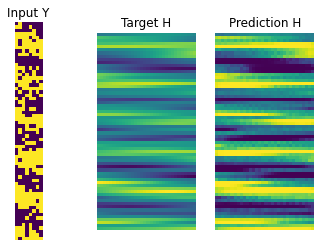

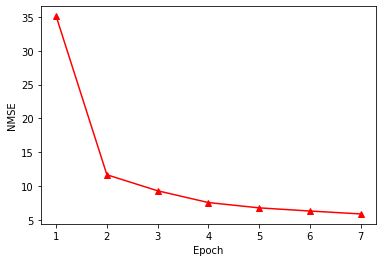

-----
EPOCH: 7
B/E: 0 / 7 , Generator loss: 14.685845 , Discriminator loss: 0.05492615 , time: 2:20:32.512886
B/E: 1 / 7 , Generator loss: 14.810482 , Discriminator loss: 0.15171924 , time: 2:20:33.293935
B/E: 2 / 7 , Generator loss: 15.463547 , Discriminator loss: 0.08478048 , time: 2:20:34.072492
B/E: 3 / 7 , Generator loss: 16.526636 , Discriminator loss: 0.054763224 , time: 2:20:34.918917
B/E: 4 / 7 , Generator loss: 13.7761755 , Discriminator loss: 0.7165599 , time: 2:20:35.675510
B/E: 5 / 7 , Generator loss: 12.344688 , Discriminator loss: 0.6652951 , time: 2:20:36.431605
B/E: 6 / 7 , Generator loss: 14.473648 , Discriminator loss: 0.6011086 , time: 2:20:37.162248
B/E: 7 / 7 , Generator loss: 17.1992 , Discriminator loss: 1.0649897 , time: 2:20:37.950786
B/E: 8 / 7 , Generator loss: 13.895025 , Discriminator loss: 1.0662279 , time: 2:20:38.665953
B/E: 9 / 7 , Generator loss: 14.385798 , Discriminator loss: 0.20328346 , time: 2:20:39.410573
B/E: 10 / 7 , Generator loss: 13.850298 

B/E: 86 / 7 , Generator loss: 16.5808 , Discriminator loss: 0.09294142 , time: 2:21:36.283904
B/E: 87 / 7 , Generator loss: 13.3252125 , Discriminator loss: 0.456033 , time: 2:21:37.017541
B/E: 88 / 7 , Generator loss: 12.517438 , Discriminator loss: 0.27004412 , time: 2:21:37.779126
B/E: 89 / 7 , Generator loss: 13.853447 , Discriminator loss: 0.24599157 , time: 2:21:38.512762
B/E: 90 / 7 , Generator loss: 11.630958 , Discriminator loss: 0.7040894 , time: 2:21:39.251889
B/E: 91 / 7 , Generator loss: 16.815807 , Discriminator loss: 0.13138512 , time: 2:21:39.978042
B/E: 92 / 7 , Generator loss: 16.376879 , Discriminator loss: 0.19692382 , time: 2:21:40.716168
B/E: 93 / 7 , Generator loss: 15.894711 , Discriminator loss: 0.071458586 , time: 2:21:41.459788
B/E: 94 / 7 , Generator loss: 15.973239 , Discriminator loss: 0.11471149 , time: 2:21:42.188932
B/E: 95 / 7 , Generator loss: 16.41065 , Discriminator loss: 0.13600205 , time: 2:21:42.916581
B/E: 96 / 7 , Generator loss: 11.91003 , Dis

B/E: 172 / 7 , Generator loss: 15.516376 , Discriminator loss: 0.19439334 , time: 2:22:39.939636
B/E: 173 / 7 , Generator loss: 12.956944 , Discriminator loss: 0.3331851 , time: 2:22:40.661295
B/E: 174 / 7 , Generator loss: 13.325324 , Discriminator loss: 0.3343157 , time: 2:22:41.400921
B/E: 175 / 7 , Generator loss: 13.059367 , Discriminator loss: 0.8303144 , time: 2:22:42.130566
B/E: 176 / 7 , Generator loss: 10.088063 , Discriminator loss: 0.6852272 , time: 2:22:42.855719
B/E: 177 / 7 , Generator loss: 18.653572 , Discriminator loss: 1.5772734 , time: 2:22:43.592848
B/E: 178 / 7 , Generator loss: 12.27439 , Discriminator loss: 0.9109544 , time: 2:22:44.330479
B/E: 179 / 7 , Generator loss: 13.563398 , Discriminator loss: 0.1454232 , time: 2:22:45.053634
B/E: 180 / 7 , Generator loss: 14.514438 , Discriminator loss: 0.041206397 , time: 2:22:45.796754
B/E: 181 / 7 , Generator loss: 14.976072 , Discriminator loss: 0.046439487 , time: 2:22:46.580298
B/E: 182 / 7 , Generator loss: 13.88

B/E: 257 / 7 , Generator loss: 15.741285 , Discriminator loss: 0.038740013 , time: 2:23:42.932599
B/E: 258 / 7 , Generator loss: 15.191156 , Discriminator loss: 0.05723673 , time: 2:23:43.672225
B/E: 259 / 7 , Generator loss: 14.304637 , Discriminator loss: 1.8114908 , time: 2:23:44.401370
B/E: 260 / 7 , Generator loss: 12.378205 , Discriminator loss: 2.132707 , time: 2:23:45.203879
B/E: 261 / 7 , Generator loss: 17.818823 , Discriminator loss: 0.11411555 , time: 2:23:46.061287
B/E: 262 / 7 , Generator loss: 12.957299 , Discriminator loss: 0.46331462 , time: 2:23:46.855311
B/E: 263 / 7 , Generator loss: 15.446544 , Discriminator loss: 0.15163077 , time: 2:23:47.617395
B/E: 264 / 7 , Generator loss: 14.635755 , Discriminator loss: 0.098134205 , time: 2:23:48.446854
B/E: 265 / 7 , Generator loss: 16.557442 , Discriminator loss: 0.11428008 , time: 2:23:49.201952
B/E: 266 / 7 , Generator loss: 15.582318 , Discriminator loss: 0.44988304 , time: 2:23:49.940580
B/E: 267 / 7 , Generator loss: 

B/E: 342 / 7 , Generator loss: 15.862244 , Discriminator loss: 0.029452182 , time: 2:24:46.520957
B/E: 343 / 7 , Generator loss: 16.564083 , Discriminator loss: 0.26801217 , time: 2:24:47.356903
B/E: 344 / 7 , Generator loss: 14.298594 , Discriminator loss: 0.14537099 , time: 2:24:48.089543
B/E: 345 / 7 , Generator loss: 13.607858 , Discriminator loss: 0.1761123 , time: 2:24:48.851127
B/E: 346 / 7 , Generator loss: 12.300579 , Discriminator loss: 0.33249477 , time: 2:24:49.597741
B/E: 347 / 7 , Generator loss: 16.915083 , Discriminator loss: 0.07172838 , time: 2:24:50.335869
B/E: 348 / 7 , Generator loss: 16.764177 , Discriminator loss: 0.09503005 , time: 2:24:51.056032
B/E: 349 / 7 , Generator loss: 14.31519 , Discriminator loss: 0.25633055 , time: 2:24:51.792662
B/E: 350 / 7 , Generator loss: 11.6049385 , Discriminator loss: 1.0272975 , time: 2:24:52.529793
B/E: 351 / 7 , Generator loss: 16.31401 , Discriminator loss: 0.3023869 , time: 2:24:53.262931
B/E: 352 / 7 , Generator loss: 16

B/E: 427 / 7 , Generator loss: 16.374535 , Discriminator loss: 0.5608354 , time: 2:25:49.455031
B/E: 428 / 7 , Generator loss: 11.681341 , Discriminator loss: 0.68515927 , time: 2:25:50.202141
B/E: 429 / 7 , Generator loss: 15.526129 , Discriminator loss: 0.1343238 , time: 2:25:50.937774
B/E: 430 / 7 , Generator loss: 15.724668 , Discriminator loss: 1.1038948 , time: 2:25:51.656939
B/E: 431 / 7 , Generator loss: 11.427658 , Discriminator loss: 0.96899825 , time: 2:25:52.389577
B/E: 432 / 7 , Generator loss: 15.071504 , Discriminator loss: 0.47760516 , time: 2:25:53.118224
B/E: 433 / 7 , Generator loss: 11.830305 , Discriminator loss: 0.20202854 , time: 2:25:53.858349
B/E: 434 / 7 , Generator loss: 13.362355 , Discriminator loss: 0.07847992 , time: 2:25:54.582003
B/E: 435 / 7 , Generator loss: 15.521444 , Discriminator loss: 0.061007805 , time: 2:25:55.340095
B/E: 436 / 7 , Generator loss: 13.093874 , Discriminator loss: 0.13519579 , time: 2:25:56.084214
B/E: 437 / 7 , Generator loss: 1

B/E: 512 / 7 , Generator loss: 15.139906 , Discriminator loss: 0.11220581 , time: 2:26:52.331210
B/E: 513 / 7 , Generator loss: 12.711018 , Discriminator loss: 0.5096942 , time: 2:26:53.062851
B/E: 514 / 7 , Generator loss: 12.2844925 , Discriminator loss: 0.551309 , time: 2:26:53.790498
B/E: 515 / 7 , Generator loss: 13.099968 , Discriminator loss: 0.34923634 , time: 2:26:54.523637
B/E: 516 / 7 , Generator loss: 11.749534 , Discriminator loss: 0.51287514 , time: 2:26:55.260768
B/E: 517 / 7 , Generator loss: 14.915092 , Discriminator loss: 0.23284456 , time: 2:26:55.990411
B/E: 518 / 7 , Generator loss: 12.139492 , Discriminator loss: 0.9114646 , time: 2:26:56.718559
B/E: 519 / 7 , Generator loss: 15.198395 , Discriminator loss: 0.0789932 , time: 2:26:57.463674
B/E: 520 / 7 , Generator loss: 16.125204 , Discriminator loss: 0.058681108 , time: 2:26:58.200306
B/E: 521 / 7 , Generator loss: 11.127705 , Discriminator loss: 0.8393842 , time: 2:26:58.925460
B/E: 522 / 7 , Generator loss: 12.

B/E: 597 / 7 , Generator loss: 18.051971 , Discriminator loss: 0.044697143 , time: 2:27:54.870517
B/E: 598 / 7 , Generator loss: 13.76816 , Discriminator loss: 1.7876784 , time: 2:27:55.604153
B/E: 599 / 7 , Generator loss: 12.253782 , Discriminator loss: 3.1396348 , time: 2:27:56.342781
B/E: 600 / 7 , Generator loss: 13.409963 , Discriminator loss: 0.3602876 , time: 2:27:57.059450
B/E: 601 / 7 , Generator loss: 10.486301 , Discriminator loss: 0.46362072 , time: 2:27:57.872439
B/E: 602 / 7 , Generator loss: 18.167059 , Discriminator loss: 0.04046637 , time: 2:27:58.656981
B/E: 603 / 7 , Generator loss: 16.15123 , Discriminator loss: 2.4179335 , time: 2:27:59.424057
B/E: 604 / 7 , Generator loss: 13.086398 , Discriminator loss: 0.8705135 , time: 2:28:00.180652
B/E: 605 / 7 , Generator loss: 16.324589 , Discriminator loss: 0.11963527 , time: 2:28:00.939741
B/E: 606 / 7 , Generator loss: 11.722975 , Discriminator loss: 0.49544102 , time: 2:28:01.700828
B/E: 607 / 7 , Generator loss: 13.17

B/E: 682 / 7 , Generator loss: 13.878092 , Discriminator loss: 2.808332 , time: 2:28:57.715255
B/E: 683 / 7 , Generator loss: 12.245604 , Discriminator loss: 1.8419591 , time: 2:28:58.452886
B/E: 684 / 7 , Generator loss: 18.807102 , Discriminator loss: 0.079088375 , time: 2:28:59.178536
B/E: 685 / 7 , Generator loss: 11.265024 , Discriminator loss: 0.55480814 , time: 2:28:59.899696
B/E: 686 / 7 , Generator loss: 11.969668 , Discriminator loss: 0.30785605 , time: 2:29:00.643813
B/E: 687 / 7 , Generator loss: 15.314616 , Discriminator loss: 0.070350006 , time: 2:29:01.408393
B/E: 688 / 7 , Generator loss: 13.475666 , Discriminator loss: 0.043436524 , time: 2:29:02.166983
B/E: 689 / 7 , Generator loss: 13.077801 , Discriminator loss: 0.81698155 , time: 2:29:02.943542
B/E: 690 / 7 , Generator loss: 11.619693 , Discriminator loss: 0.93459684 , time: 2:29:03.741060
B/E: 691 / 7 , Generator loss: 13.585571 , Discriminator loss: 0.9395064 , time: 2:29:04.542072
B/E: 692 / 7 , Generator loss: 

B/E: 767 / 7 , Generator loss: 12.992933 , Discriminator loss: 0.16837141 , time: 2:30:01.437364
B/E: 768 / 7 , Generator loss: 15.466003 , Discriminator loss: 0.077309266 , time: 2:30:02.187471
B/E: 769 / 7 , Generator loss: 14.717029 , Discriminator loss: 0.0782898 , time: 2:30:02.931088
B/E: 770 / 7 , Generator loss: 15.503914 , Discriminator loss: 0.038957857 , time: 2:30:03.659735
B/E: 771 / 7 , Generator loss: 15.535478 , Discriminator loss: 0.13480079 , time: 2:30:04.391376
B/E: 772 / 7 , Generator loss: 17.070168 , Discriminator loss: 0.046900988 , time: 2:30:05.131003
B/E: 773 / 7 , Generator loss: 15.667649 , Discriminator loss: 0.5613817 , time: 2:30:05.899573
B/E: 774 / 7 , Generator loss: 13.051564 , Discriminator loss: 0.17092212 , time: 2:30:06.630716
B/E: 775 / 7 , Generator loss: 15.478609 , Discriminator loss: 0.03547072 , time: 2:30:07.368345
B/E: 776 / 7 , Generator loss: 12.8715515 , Discriminator loss: 0.26763552 , time: 2:30:08.096492
B/E: 777 / 7 , Generator los

B/E: 852 / 7 , Generator loss: 15.14872 , Discriminator loss: 1.3674977 , time: 2:31:04.364450
B/E: 853 / 7 , Generator loss: 15.598795 , Discriminator loss: 1.5469345 , time: 2:31:05.091599
B/E: 854 / 7 , Generator loss: 13.55462 , Discriminator loss: 0.5548924 , time: 2:31:05.829728
B/E: 855 / 7 , Generator loss: 14.677054 , Discriminator loss: 0.11347918 , time: 2:31:06.579834
B/E: 856 / 7 , Generator loss: 14.45682 , Discriminator loss: 0.20807618 , time: 2:31:07.324949
B/E: 857 / 7 , Generator loss: 13.979579 , Discriminator loss: 0.14308357 , time: 2:31:08.071562
B/E: 858 / 7 , Generator loss: 12.776272 , Discriminator loss: 0.6203586 , time: 2:31:08.820172
B/E: 859 / 7 , Generator loss: 12.939605 , Discriminator loss: 0.9883125 , time: 2:31:09.551812
B/E: 860 / 7 , Generator loss: 10.990433 , Discriminator loss: 0.6490283 , time: 2:31:10.290440
B/E: 861 / 7 , Generator loss: 15.215535 , Discriminator loss: 1.3736274 , time: 2:31:11.027071
B/E: 862 / 7 , Generator loss: 11.640194

B/E: 937 / 7 , Generator loss: 10.734365 , Discriminator loss: 0.43426546 , time: 2:32:07.356415
B/E: 938 / 7 , Generator loss: 11.819024 , Discriminator loss: 1.193481 , time: 2:32:08.084064
B/E: 939 / 7 , Generator loss: 13.456852 , Discriminator loss: 0.8346251 , time: 2:32:08.814207
B/E: 940 / 7 , Generator loss: 14.543913 , Discriminator loss: 0.1345216 , time: 2:32:09.542356
B/E: 941 / 7 , Generator loss: 14.37295 , Discriminator loss: 0.07296039 , time: 2:32:10.262518
B/E: 942 / 7 , Generator loss: 15.28058 , Discriminator loss: 0.28361776 , time: 2:32:11.034582
B/E: 943 / 7 , Generator loss: 12.712445 , Discriminator loss: 0.10291669 , time: 2:32:11.794172
B/E: 944 / 7 , Generator loss: 13.7455845 , Discriminator loss: 0.04962158 , time: 2:32:12.533297
B/E: 945 / 7 , Generator loss: 14.496592 , Discriminator loss: 0.28502446 , time: 2:32:13.269430
B/E: 946 / 7 , Generator loss: 14.106692 , Discriminator loss: 0.13427983 , time: 2:32:14.002069
B/E: 947 / 7 , Generator loss: 18.6

B/E: 1022 / 7 , Generator loss: 13.406813 , Discriminator loss: 0.38692963 , time: 2:33:10.012005
B/E: 1023 / 7 , Generator loss: 16.682821 , Discriminator loss: 0.047240436 , time: 2:33:10.754128
B/E: 1024 / 7 , Generator loss: 13.936307 , Discriminator loss: 0.5753465 , time: 2:33:11.473789
B/E: 1025 / 7 , Generator loss: 17.1838 , Discriminator loss: 1.6450768 , time: 2:33:12.216910
B/E: 1026 / 7 , Generator loss: 18.15174 , Discriminator loss: 3.8637314 , time: 2:33:12.998956
B/E: 1027 / 7 , Generator loss: 16.604507 , Discriminator loss: 0.11775472 , time: 2:33:13.744071
B/E: 1028 / 7 , Generator loss: 13.8187895 , Discriminator loss: 0.33909526 , time: 2:33:14.473217
B/E: 1029 / 7 , Generator loss: 13.028252 , Discriminator loss: 0.13720973 , time: 2:33:15.205856
B/E: 1030 / 7 , Generator loss: 13.796128 , Discriminator loss: 0.8209578 , time: 2:33:15.948477
B/E: 1031 / 7 , Generator loss: 14.35006 , Discriminator loss: 0.2377021 , time: 2:33:16.696088
B/E: 1032 / 7 , Generator l

B/E: 1107 / 7 , Generator loss: 16.278429 , Discriminator loss: 0.077790946 , time: 2:34:13.359312
B/E: 1108 / 7 , Generator loss: 16.06445 , Discriminator loss: 0.59255385 , time: 2:34:14.101931
B/E: 1109 / 7 , Generator loss: 11.510046 , Discriminator loss: 0.7748633 , time: 2:34:14.820596
B/E: 1110 / 7 , Generator loss: 14.598624 , Discriminator loss: 0.31332877 , time: 2:34:15.574694
B/E: 1111 / 7 , Generator loss: 15.453438 , Discriminator loss: 0.122917496 , time: 2:34:16.340272
B/E: 1112 / 7 , Generator loss: 14.610676 , Discriminator loss: 0.10798792 , time: 2:34:17.113835
B/E: 1113 / 7 , Generator loss: 12.246239 , Discriminator loss: 0.56022877 , time: 2:34:17.837990
B/E: 1114 / 7 , Generator loss: 18.635712 , Discriminator loss: 0.087721884 , time: 2:34:18.568133
B/E: 1115 / 7 , Generator loss: 13.296196 , Discriminator loss: 0.8936127 , time: 2:34:19.316742
B/E: 1116 / 7 , Generator loss: 15.454666 , Discriminator loss: 0.64273596 , time: 2:34:20.035408
B/E: 1117 / 7 , Gene

B/E: 1191 / 7 , Generator loss: 17.3015 , Discriminator loss: 1.154161 , time: 2:35:15.785328
B/E: 1192 / 7 , Generator loss: 12.646215 , Discriminator loss: 0.81444454 , time: 2:35:16.529445
B/E: 1193 / 7 , Generator loss: 18.006636 , Discriminator loss: 0.04090263 , time: 2:35:17.288535
B/E: 1194 / 7 , Generator loss: 15.970987 , Discriminator loss: 0.2713503 , time: 2:35:18.024169
B/E: 1195 / 7 , Generator loss: 14.3560295 , Discriminator loss: 0.095135085 , time: 2:35:18.770282
B/E: 1196 / 7 , Generator loss: 16.988289 , Discriminator loss: 0.037501432 , time: 2:35:19.511405
B/E: 1197 / 7 , Generator loss: 13.471913 , Discriminator loss: 0.063914664 , time: 2:35:20.241049
B/E: 1198 / 7 , Generator loss: 15.104931 , Discriminator loss: 0.4455861 , time: 2:35:20.978180
B/E: 1199 / 7 , Generator loss: 14.0136175 , Discriminator loss: 0.08690268 , time: 2:35:21.711318
B/E: 1200 / 7 , Generator loss: 14.126879 , Discriminator loss: 0.6586628 , time: 2:35:22.445952
B/E: 1201 / 7 , Genera

B/E: 1275 / 7 , Generator loss: 14.749424 , Discriminator loss: 0.07520808 , time: 2:36:17.929869
B/E: 1276 / 7 , Generator loss: 14.979845 , Discriminator loss: 0.06414461 , time: 2:36:18.650029
B/E: 1277 / 7 , Generator loss: 13.048708 , Discriminator loss: 1.0967609 , time: 2:36:19.388657
B/E: 1278 / 7 , Generator loss: 11.057602 , Discriminator loss: 1.6914046 , time: 2:36:20.138763
B/E: 1279 / 7 , Generator loss: 15.189958 , Discriminator loss: 0.06344414 , time: 2:36:20.884877
B/E: 1280 / 7 , Generator loss: 13.649426 , Discriminator loss: 0.22916868 , time: 2:36:21.614022
B/E: 1281 / 7 , Generator loss: 15.651146 , Discriminator loss: 0.46171033 , time: 2:36:22.356643
B/E: 1282 / 7 , Generator loss: 11.588339 , Discriminator loss: 0.7462797 , time: 2:36:23.088283
B/E: 1283 / 7 , Generator loss: 18.168686 , Discriminator loss: 0.2962398 , time: 2:36:23.814932
B/E: 1284 / 7 , Generator loss: 14.0373125 , Discriminator loss: 0.120091245 , time: 2:36:24.554060
B/E: 1285 / 7 , Genera

B/E: 1360 / 7 , Generator loss: 14.454527 , Discriminator loss: 0.352177 , time: 2:37:20.696251
B/E: 1361 / 7 , Generator loss: 15.498397 , Discriminator loss: 0.03912751 , time: 2:37:21.429389
B/E: 1362 / 7 , Generator loss: 16.343208 , Discriminator loss: 0.6005791 , time: 2:37:22.152046
B/E: 1363 / 7 , Generator loss: 12.453593 , Discriminator loss: 0.21654522 , time: 2:37:22.946571
B/E: 1364 / 7 , Generator loss: 13.775971 , Discriminator loss: 0.6784412 , time: 2:37:23.675216
B/E: 1365 / 7 , Generator loss: 17.054373 , Discriminator loss: 0.26894063 , time: 2:37:24.415343
B/E: 1366 / 7 , Generator loss: 13.680997 , Discriminator loss: 0.44265193 , time: 2:37:25.163452
B/E: 1367 / 7 , Generator loss: 15.878151 , Discriminator loss: 1.5480127 , time: 2:37:25.897590
B/E: 1368 / 7 , Generator loss: 9.966573 , Discriminator loss: 2.8224893 , time: 2:37:26.621743
B/E: 1369 / 7 , Generator loss: 13.14838 , Discriminator loss: 0.7438073 , time: 2:37:27.349391
B/E: 1370 / 7 , Generator los

B/E: 1444 / 7 , Generator loss: 15.427469 , Discriminator loss: 0.09110999 , time: 2:38:22.764932
B/E: 1445 / 7 , Generator loss: 17.09399 , Discriminator loss: 0.15332629 , time: 2:38:23.488588
B/E: 1446 / 7 , Generator loss: 14.173428 , Discriminator loss: 0.2932039 , time: 2:38:24.227715
B/E: 1447 / 7 , Generator loss: 15.926802 , Discriminator loss: 0.052205816 , time: 2:38:25.014253
B/E: 1448 / 7 , Generator loss: 17.477968 , Discriminator loss: 0.03671535 , time: 2:38:25.752881
B/E: 1449 / 7 , Generator loss: 13.944728 , Discriminator loss: 0.092213325 , time: 2:38:26.479531
B/E: 1450 / 7 , Generator loss: 15.186377 , Discriminator loss: 0.05352928 , time: 2:38:27.212170
B/E: 1451 / 7 , Generator loss: 14.855746 , Discriminator loss: 0.5098403 , time: 2:38:27.957785
B/E: 1452 / 7 , Generator loss: 12.967682 , Discriminator loss: 0.6898707 , time: 2:38:28.687928
B/E: 1453 / 7 , Generator loss: 16.50547 , Discriminator loss: 1.057052 , time: 2:38:29.421565
B/E: 1454 / 7 , Generator

B/E: 1528 / 7 , Generator loss: 12.662835 , Discriminator loss: 0.12842514 , time: 2:39:24.885519
B/E: 1529 / 7 , Generator loss: 17.48576 , Discriminator loss: 0.2218341 , time: 2:39:25.630633
B/E: 1530 / 7 , Generator loss: 12.701457 , Discriminator loss: 0.105989784 , time: 2:39:26.377745
B/E: 1531 / 7 , Generator loss: 16.25911 , Discriminator loss: 0.029085 , time: 2:39:27.113378
B/E: 1532 / 7 , Generator loss: 14.774076 , Discriminator loss: 0.13614702 , time: 2:39:27.873466
B/E: 1533 / 7 , Generator loss: 17.331316 , Discriminator loss: 0.05824206 , time: 2:39:28.604108
B/E: 1534 / 7 , Generator loss: 16.121754 , Discriminator loss: 0.07222321 , time: 2:39:29.335748
B/E: 1535 / 7 , Generator loss: 16.008223 , Discriminator loss: 0.1226365 , time: 2:39:30.062399
B/E: 1536 / 7 , Generator loss: 11.2125025 , Discriminator loss: 0.80017257 , time: 2:39:30.793540
B/E: 1537 / 7 , Generator loss: 10.205632 , Discriminator loss: 2.0101645 , time: 2:39:31.514700
B/E: 1538 / 7 , Generator

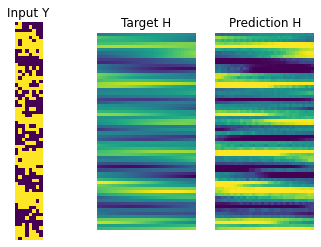

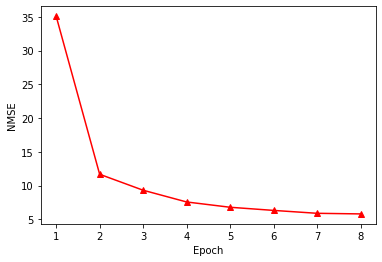

-----
EPOCH: 8
B/E: 0 / 8 , Generator loss: 13.090895 , Discriminator loss: 0.12558857 , time: 2:40:28.299698
B/E: 1 / 8 , Generator loss: 15.922651 , Discriminator loss: 0.051231317 , time: 2:40:29.053796
B/E: 2 / 8 , Generator loss: 13.975536 , Discriminator loss: 0.29816782 , time: 2:40:29.798912
B/E: 3 / 8 , Generator loss: 17.049025 , Discriminator loss: 0.22651283 , time: 2:40:30.560497
B/E: 4 / 8 , Generator loss: 12.36121 , Discriminator loss: 0.2278079 , time: 2:40:31.343044
B/E: 5 / 8 , Generator loss: 17.184666 , Discriminator loss: 0.043549005 , time: 2:40:32.097641
B/E: 6 / 8 , Generator loss: 14.033045 , Discriminator loss: 0.16942409 , time: 2:40:32.838765
B/E: 7 / 8 , Generator loss: 17.48349 , Discriminator loss: 0.06607142 , time: 2:40:33.584379
B/E: 8 / 8 , Generator loss: 15.464819 , Discriminator loss: 0.08663766 , time: 2:40:34.333985
B/E: 9 / 8 , Generator loss: 14.645875 , Discriminator loss: 0.22901256 , time: 2:40:35.067125
B/E: 10 / 8 , Generator loss: 11.330

B/E: 86 / 8 , Generator loss: 15.833924 , Discriminator loss: 0.095836975 , time: 2:41:32.322747
B/E: 87 / 8 , Generator loss: 15.258957 , Discriminator loss: 0.44667697 , time: 2:41:33.048400
B/E: 88 / 8 , Generator loss: 16.173252 , Discriminator loss: 0.13863707 , time: 2:41:33.803995
B/E: 89 / 8 , Generator loss: 15.9634695 , Discriminator loss: 0.045562014 , time: 2:41:34.527152
B/E: 90 / 8 , Generator loss: 13.920154 , Discriminator loss: 0.28732032 , time: 2:41:35.263285
B/E: 91 / 8 , Generator loss: 14.386048 , Discriminator loss: 0.11169043 , time: 2:41:36.015387
B/E: 92 / 8 , Generator loss: 14.488399 , Discriminator loss: 0.12041583 , time: 2:41:36.776472
B/E: 93 / 8 , Generator loss: 14.305034 , Discriminator loss: 1.4301295 , time: 2:41:37.503122
B/E: 94 / 8 , Generator loss: 12.323117 , Discriminator loss: 0.97815824 , time: 2:41:38.235761
B/E: 95 / 8 , Generator loss: 15.914946 , Discriminator loss: 1.0304037 , time: 2:41:38.974887
B/E: 96 / 8 , Generator loss: 9.007683 

B/E: 171 / 8 , Generator loss: 12.87019 , Discriminator loss: 0.40545943 , time: 2:42:35.377097
B/E: 172 / 8 , Generator loss: 9.91044 , Discriminator loss: 0.5957679 , time: 2:42:36.142675
B/E: 173 / 8 , Generator loss: 15.277439 , Discriminator loss: 0.39342836 , time: 2:42:36.885297
B/E: 174 / 8 , Generator loss: 15.933919 , Discriminator loss: 0.13343924 , time: 2:42:37.618432
B/E: 175 / 8 , Generator loss: 12.111507 , Discriminator loss: 0.15662035 , time: 2:42:38.359555
B/E: 176 / 8 , Generator loss: 13.5491495 , Discriminator loss: 0.19011836 , time: 2:42:39.093691
B/E: 177 / 8 , Generator loss: 16.279194 , Discriminator loss: 0.052471623 , time: 2:42:39.831322
B/E: 178 / 8 , Generator loss: 15.2217455 , Discriminator loss: 0.107605845 , time: 2:42:40.555475
B/E: 179 / 8 , Generator loss: 12.423496 , Discriminator loss: 0.25834414 , time: 2:42:41.289612
B/E: 180 / 8 , Generator loss: 11.826003 , Discriminator loss: 1.3976487 , time: 2:42:42.013268
B/E: 181 / 8 , Generator loss: 

B/E: 256 / 8 , Generator loss: 15.41449 , Discriminator loss: 0.099879615 , time: 2:43:38.180412
B/E: 257 / 8 , Generator loss: 15.618109 , Discriminator loss: 0.05524412 , time: 2:43:38.939003
B/E: 258 / 8 , Generator loss: 13.81484 , Discriminator loss: 0.09534854 , time: 2:43:39.662659
B/E: 259 / 8 , Generator loss: 13.030656 , Discriminator loss: 2.9491954 , time: 2:43:40.433226
B/E: 260 / 8 , Generator loss: 12.215791 , Discriminator loss: 2.3713157 , time: 2:43:41.171855
B/E: 261 / 8 , Generator loss: 15.022567 , Discriminator loss: 0.5801151 , time: 2:43:41.913477
B/E: 262 / 8 , Generator loss: 10.148955 , Discriminator loss: 0.79394805 , time: 2:43:42.635136
B/E: 263 / 8 , Generator loss: 14.15166 , Discriminator loss: 0.09532208 , time: 2:43:43.376758
B/E: 264 / 8 , Generator loss: 15.798799 , Discriminator loss: 0.16617504 , time: 2:43:44.113392
B/E: 265 / 8 , Generator loss: 12.864 , Discriminator loss: 1.1866091 , time: 2:43:44.841037
B/E: 266 / 8 , Generator loss: 12.95063

B/E: 341 / 8 , Generator loss: 12.29592 , Discriminator loss: 0.36420065 , time: 2:44:41.380990
B/E: 342 / 8 , Generator loss: 13.994998 , Discriminator loss: 0.080099404 , time: 2:44:42.105144
B/E: 343 / 8 , Generator loss: 15.504477 , Discriminator loss: 0.036249783 , time: 2:44:42.826804
B/E: 344 / 8 , Generator loss: 14.89843 , Discriminator loss: 0.061316364 , time: 2:44:43.559442
B/E: 345 / 8 , Generator loss: 14.277687 , Discriminator loss: 0.22816575 , time: 2:44:44.320029
B/E: 346 / 8 , Generator loss: 10.691235 , Discriminator loss: 0.6400452 , time: 2:44:45.042188
B/E: 347 / 8 , Generator loss: 11.338583 , Discriminator loss: 0.9134827 , time: 2:44:45.785809
B/E: 348 / 8 , Generator loss: 17.23713 , Discriminator loss: 0.029781021 , time: 2:44:46.632733
B/E: 349 / 8 , Generator loss: 15.80727 , Discriminator loss: 2.5589623 , time: 2:44:47.433245
B/E: 350 / 8 , Generator loss: 13.758495 , Discriminator loss: 0.42095026 , time: 2:44:48.162391
B/E: 351 / 8 , Generator loss: 15

B/E: 426 / 8 , Generator loss: 14.850748 , Discriminator loss: 0.037211377 , time: 2:45:44.336523
B/E: 427 / 8 , Generator loss: 11.627365 , Discriminator loss: 0.3148177 , time: 2:45:45.063673
B/E: 428 / 8 , Generator loss: 13.778839 , Discriminator loss: 0.050339933 , time: 2:45:45.799805
B/E: 429 / 8 , Generator loss: 12.093892 , Discriminator loss: 0.69275975 , time: 2:45:46.601316
B/E: 430 / 8 , Generator loss: 11.847376 , Discriminator loss: 0.71784484 , time: 2:45:47.329961
B/E: 431 / 8 , Generator loss: 12.36715 , Discriminator loss: 1.1096032 , time: 2:45:48.059608
B/E: 432 / 8 , Generator loss: 13.138115 , Discriminator loss: 0.8372928 , time: 2:45:48.805221
B/E: 433 / 8 , Generator loss: 16.312729 , Discriminator loss: 0.061403517 , time: 2:45:49.528377
B/E: 434 / 8 , Generator loss: 14.128816 , Discriminator loss: 1.5481162 , time: 2:45:50.252032
B/E: 435 / 8 , Generator loss: 14.064045 , Discriminator loss: 0.69754165 , time: 2:45:50.989164
B/E: 436 / 8 , Generator loss: 1

B/E: 511 / 8 , Generator loss: 11.373275 , Discriminator loss: 0.5094943 , time: 2:46:47.336474
B/E: 512 / 8 , Generator loss: 16.645182 , Discriminator loss: 0.09619719 , time: 2:46:48.075600
B/E: 513 / 8 , Generator loss: 12.07383 , Discriminator loss: 0.37713745 , time: 2:46:48.830199
B/E: 514 / 8 , Generator loss: 19.105362 , Discriminator loss: 0.03265792 , time: 2:46:49.576313
B/E: 515 / 8 , Generator loss: 14.393906 , Discriminator loss: 0.064962454 , time: 2:46:50.332906
B/E: 516 / 8 , Generator loss: 13.389352 , Discriminator loss: 0.27624533 , time: 2:46:51.062052
B/E: 517 / 8 , Generator loss: 14.3412485 , Discriminator loss: 0.12923945 , time: 2:46:51.792195
B/E: 518 / 8 , Generator loss: 13.760714 , Discriminator loss: 0.07553969 , time: 2:46:52.514852
B/E: 519 / 8 , Generator loss: 14.579129 , Discriminator loss: 0.06486324 , time: 2:46:53.243499
B/E: 520 / 8 , Generator loss: 13.74178 , Discriminator loss: 0.4108682 , time: 2:46:53.976138
B/E: 521 / 8 , Generator loss: 1

B/E: 596 / 8 , Generator loss: 18.935204 , Discriminator loss: 0.045695122 , time: 2:47:50.028995
B/E: 597 / 8 , Generator loss: 15.293929 , Discriminator loss: 0.1084111 , time: 2:47:50.754647
B/E: 598 / 8 , Generator loss: 17.29558 , Discriminator loss: 0.02964519 , time: 2:47:51.497766
B/E: 599 / 8 , Generator loss: 12.637653 , Discriminator loss: 0.8374025 , time: 2:47:52.251865
B/E: 600 / 8 , Generator loss: 12.542249 , Discriminator loss: 0.9714358 , time: 2:47:52.976522
B/E: 601 / 8 , Generator loss: 17.30517 , Discriminator loss: 0.040818706 , time: 2:47:53.708161
B/E: 602 / 8 , Generator loss: 14.031581 , Discriminator loss: 0.12721182 , time: 2:47:54.448284
B/E: 603 / 8 , Generator loss: 15.9251175 , Discriminator loss: 0.06910795 , time: 2:47:55.179426
B/E: 604 / 8 , Generator loss: 14.852532 , Discriminator loss: 0.06080048 , time: 2:47:55.907075
B/E: 605 / 8 , Generator loss: 12.922646 , Discriminator loss: 0.5453808 , time: 2:47:56.630231
B/E: 606 / 8 , Generator loss: 11

B/E: 681 / 8 , Generator loss: 13.121807 , Discriminator loss: 0.20312572 , time: 2:48:53.417724
B/E: 682 / 8 , Generator loss: 11.93081 , Discriminator loss: 0.0835898 , time: 2:48:54.131897
B/E: 683 / 8 , Generator loss: 12.878755 , Discriminator loss: 0.148325 , time: 2:48:54.902964
B/E: 684 / 8 , Generator loss: 14.083792 , Discriminator loss: 0.067218825 , time: 2:48:55.643588
B/E: 685 / 8 , Generator loss: 14.442061 , Discriminator loss: 0.32579994 , time: 2:48:56.364251
B/E: 686 / 8 , Generator loss: 12.280482 , Discriminator loss: 0.27837628 , time: 2:48:57.092895
B/E: 687 / 8 , Generator loss: 17.332438 , Discriminator loss: 0.36659986 , time: 2:48:57.843501
B/E: 688 / 8 , Generator loss: 12.975893 , Discriminator loss: 0.11658802 , time: 2:48:58.589614
B/E: 689 / 8 , Generator loss: 17.587986 , Discriminator loss: 0.031851135 , time: 2:48:59.338722
B/E: 690 / 8 , Generator loss: 15.65169 , Discriminator loss: 0.028921915 , time: 2:49:00.070863
B/E: 691 / 8 , Generator loss: 1

B/E: 766 / 8 , Generator loss: 13.051818 , Discriminator loss: 0.17729352 , time: 2:49:56.772016
B/E: 767 / 8 , Generator loss: 16.17673 , Discriminator loss: 0.03268874 , time: 2:49:57.532605
B/E: 768 / 8 , Generator loss: 15.698008 , Discriminator loss: 1.183387 , time: 2:49:58.348586
B/E: 769 / 8 , Generator loss: 11.147371 , Discriminator loss: 1.1425418 , time: 2:49:59.081727
B/E: 770 / 8 , Generator loss: 14.235591 , Discriminator loss: 0.0460293 , time: 2:49:59.848301
B/E: 771 / 8 , Generator loss: 12.933116 , Discriminator loss: 1.4055867 , time: 2:50:00.605395
B/E: 772 / 8 , Generator loss: 13.726283 , Discriminator loss: 0.83711356 , time: 2:50:01.324557
B/E: 773 / 8 , Generator loss: 15.784166 , Discriminator loss: 0.028065123 , time: 2:50:02.111595
B/E: 774 / 8 , Generator loss: 13.086231 , Discriminator loss: 0.37237433 , time: 2:50:02.829261
B/E: 775 / 8 , Generator loss: 16.253647 , Discriminator loss: 0.4301756 , time: 2:50:03.600329
B/E: 776 / 8 , Generator loss: 13.31

B/E: 851 / 8 , Generator loss: 16.324196 , Discriminator loss: 1.443597 , time: 2:50:59.917696
B/E: 852 / 8 , Generator loss: 12.937847 , Discriminator loss: 0.42800808 , time: 2:51:00.662813
B/E: 853 / 8 , Generator loss: 13.2014885 , Discriminator loss: 0.08309796 , time: 2:51:01.401937
B/E: 854 / 8 , Generator loss: 15.127981 , Discriminator loss: 0.6334468 , time: 2:51:02.136573
B/E: 855 / 8 , Generator loss: 11.089886 , Discriminator loss: 1.1457466 , time: 2:51:02.876200
B/E: 856 / 8 , Generator loss: 13.003184 , Discriminator loss: 0.23717901 , time: 2:51:03.616823
B/E: 857 / 8 , Generator loss: 12.919968 , Discriminator loss: 0.06578134 , time: 2:51:04.356448
B/E: 858 / 8 , Generator loss: 14.951956 , Discriminator loss: 0.05603932 , time: 2:51:05.080105
B/E: 859 / 8 , Generator loss: 14.229235 , Discriminator loss: 0.10855585 , time: 2:51:05.838195
B/E: 860 / 8 , Generator loss: 11.983443 , Discriminator loss: 0.22440752 , time: 2:51:06.560853
B/E: 861 / 8 , Generator loss: 11

B/E: 936 / 8 , Generator loss: 12.102346 , Discriminator loss: 0.36694106 , time: 2:52:02.870736
B/E: 937 / 8 , Generator loss: 12.126127 , Discriminator loss: 0.6219208 , time: 2:52:03.602374
B/E: 938 / 8 , Generator loss: 12.022749 , Discriminator loss: 0.7948229 , time: 2:52:04.357971
B/E: 939 / 8 , Generator loss: 12.74846 , Discriminator loss: 0.21462283 , time: 2:52:05.107578
B/E: 940 / 8 , Generator loss: 16.736757 , Discriminator loss: 1.0323797 , time: 2:52:05.830234
B/E: 941 / 8 , Generator loss: 11.915483 , Discriminator loss: 0.520958 , time: 2:52:06.569361
B/E: 942 / 8 , Generator loss: 11.91083 , Discriminator loss: 0.6900593 , time: 2:52:07.308488
B/E: 943 / 8 , Generator loss: 18.048489 , Discriminator loss: 0.04963402 , time: 2:52:08.053104
B/E: 944 / 8 , Generator loss: 19.17862 , Discriminator loss: 0.040174197 , time: 2:52:08.784745
B/E: 945 / 8 , Generator loss: 15.777054 , Discriminator loss: 0.03448391 , time: 2:52:09.522873
B/E: 946 / 8 , Generator loss: 14.4469

B/E: 1021 / 8 , Generator loss: 11.620026 , Discriminator loss: 0.92730933 , time: 2:53:05.503865
B/E: 1022 / 8 , Generator loss: 16.046215 , Discriminator loss: 0.68633324 , time: 2:53:06.237504
B/E: 1023 / 8 , Generator loss: 12.259626 , Discriminator loss: 0.39355224 , time: 2:53:06.963153
B/E: 1024 / 8 , Generator loss: 11.68627 , Discriminator loss: 0.48153436 , time: 2:53:07.694295
B/E: 1025 / 8 , Generator loss: 12.754983 , Discriminator loss: 0.054371867 , time: 2:53:08.429430
B/E: 1026 / 8 , Generator loss: 13.228084 , Discriminator loss: 0.11689109 , time: 2:53:09.166561
B/E: 1027 / 8 , Generator loss: 16.827272 , Discriminator loss: 0.034740645 , time: 2:53:09.889217
B/E: 1028 / 8 , Generator loss: 13.214586 , Discriminator loss: 0.050445117 , time: 2:53:10.635831
B/E: 1029 / 8 , Generator loss: 14.025226 , Discriminator loss: 0.25194567 , time: 2:53:11.378950
B/E: 1030 / 8 , Generator loss: 12.6814575 , Discriminator loss: 0.3821277 , time: 2:53:12.113585
B/E: 1031 / 8 , Ge

B/E: 1106 / 8 , Generator loss: 11.656177 , Discriminator loss: 1.8281242 , time: 2:54:08.883111
B/E: 1107 / 8 , Generator loss: 14.926912 , Discriminator loss: 0.36596757 , time: 2:54:09.622239
B/E: 1108 / 8 , Generator loss: 15.961827 , Discriminator loss: 0.21992046 , time: 2:54:10.368351
B/E: 1109 / 8 , Generator loss: 10.835337 , Discriminator loss: 0.29432324 , time: 2:54:11.157885
B/E: 1110 / 8 , Generator loss: 12.989414 , Discriminator loss: 0.10229113 , time: 2:54:11.932445
B/E: 1111 / 8 , Generator loss: 14.65637 , Discriminator loss: 0.21252257 , time: 2:54:12.695028
B/E: 1112 / 8 , Generator loss: 13.286029 , Discriminator loss: 0.09459437 , time: 2:54:13.430661
B/E: 1113 / 8 , Generator loss: 14.007194 , Discriminator loss: 1.7990427 , time: 2:54:14.162302
B/E: 1114 / 8 , Generator loss: 11.55085 , Discriminator loss: 1.5574244 , time: 2:54:14.899433
B/E: 1115 / 8 , Generator loss: 13.0077505 , Discriminator loss: 0.13526876 , time: 2:54:15.631572
B/E: 1116 / 8 , Generato

B/E: 1190 / 8 , Generator loss: 12.636769 , Discriminator loss: 0.13137022 , time: 2:55:11.645503
B/E: 1191 / 8 , Generator loss: 14.190106 , Discriminator loss: 0.2040754 , time: 2:55:12.523870
B/E: 1192 / 8 , Generator loss: 13.851002 , Discriminator loss: 0.10025443 , time: 2:55:13.401739
B/E: 1193 / 8 , Generator loss: 14.648967 , Discriminator loss: 1.5492245 , time: 2:55:14.472251
B/E: 1194 / 8 , Generator loss: 10.832916 , Discriminator loss: 3.0355835 , time: 2:55:15.369085
B/E: 1195 / 8 , Generator loss: 14.503069 , Discriminator loss: 0.10716944 , time: 2:55:16.222998
B/E: 1196 / 8 , Generator loss: 13.557332 , Discriminator loss: 0.9464129 , time: 2:55:17.216153
B/E: 1197 / 8 , Generator loss: 11.663168 , Discriminator loss: 0.5021462 , time: 2:55:17.980733
B/E: 1198 / 8 , Generator loss: 16.957474 , Discriminator loss: 0.019885805 , time: 2:55:18.725349
B/E: 1199 / 8 , Generator loss: 18.564732 , Discriminator loss: 0.048456304 , time: 2:55:19.467969
B/E: 1200 / 8 , Generat

B/E: 1274 / 8 , Generator loss: 14.0549965 , Discriminator loss: 0.06379602 , time: 2:56:15.116578
B/E: 1275 / 8 , Generator loss: 15.372834 , Discriminator loss: 1.1536847 , time: 2:56:15.849217
B/E: 1276 / 8 , Generator loss: 14.124844 , Discriminator loss: 2.136073 , time: 2:56:16.592834
B/E: 1277 / 8 , Generator loss: 15.022522 , Discriminator loss: 0.1605484 , time: 2:56:17.350427
B/E: 1278 / 8 , Generator loss: 14.369239 , Discriminator loss: 0.23969372 , time: 2:56:18.094046
B/E: 1279 / 8 , Generator loss: 13.097765 , Discriminator loss: 0.19846547 , time: 2:56:18.828681
B/E: 1280 / 8 , Generator loss: 13.364646 , Discriminator loss: 0.10976131 , time: 2:56:19.570803
B/E: 1281 / 8 , Generator loss: 15.898542 , Discriminator loss: 0.13683708 , time: 2:56:20.306436
B/E: 1282 / 8 , Generator loss: 16.309471 , Discriminator loss: 0.20323366 , time: 2:56:21.039573
B/E: 1283 / 8 , Generator loss: 15.363496 , Discriminator loss: 0.3602724 , time: 2:56:21.768719
B/E: 1284 / 8 , Generato

B/E: 1358 / 8 , Generator loss: 12.427396 , Discriminator loss: 1.5545882 , time: 2:57:17.125871
B/E: 1359 / 8 , Generator loss: 15.588998 , Discriminator loss: 0.95492285 , time: 2:57:17.856511
B/E: 1360 / 8 , Generator loss: 11.131566 , Discriminator loss: 1.5426769 , time: 2:57:18.582664
B/E: 1361 / 8 , Generator loss: 13.923632 , Discriminator loss: 0.45595175 , time: 2:57:19.314304
B/E: 1362 / 8 , Generator loss: 12.945366 , Discriminator loss: 0.18150315 , time: 2:57:20.060917
B/E: 1363 / 8 , Generator loss: 12.511942 , Discriminator loss: 0.123763934 , time: 2:57:20.791060
B/E: 1364 / 8 , Generator loss: 14.252804 , Discriminator loss: 0.313977 , time: 2:57:21.513217
B/E: 1365 / 8 , Generator loss: 17.538498 , Discriminator loss: 0.6561887 , time: 2:57:22.245358
B/E: 1366 / 8 , Generator loss: 12.327647 , Discriminator loss: 0.29739818 , time: 2:57:22.976000
B/E: 1367 / 8 , Generator loss: 13.455112 , Discriminator loss: 0.38957307 , time: 2:57:23.716625
B/E: 1368 / 8 , Generato

B/E: 1442 / 8 , Generator loss: 16.229336 , Discriminator loss: 0.046516977 , time: 2:58:19.287876
B/E: 1443 / 8 , Generator loss: 12.875821 , Discriminator loss: 0.07707578 , time: 2:58:20.021015
B/E: 1444 / 8 , Generator loss: 15.449785 , Discriminator loss: 0.081964225 , time: 2:58:20.749660
B/E: 1445 / 8 , Generator loss: 16.068104 , Discriminator loss: 0.065472074 , time: 2:58:21.477308
B/E: 1446 / 8 , Generator loss: 14.137096 , Discriminator loss: 0.22920473 , time: 2:58:22.237895
B/E: 1447 / 8 , Generator loss: 10.940607 , Discriminator loss: 1.5938514 , time: 2:58:22.977521
B/E: 1448 / 8 , Generator loss: 19.491152 , Discriminator loss: 4.674976 , time: 2:58:23.701185
B/E: 1449 / 8 , Generator loss: 11.651846 , Discriminator loss: 0.34838092 , time: 2:58:24.445793
B/E: 1450 / 8 , Generator loss: 9.884399 , Discriminator loss: 0.7418111 , time: 2:58:25.176436
B/E: 1451 / 8 , Generator loss: 18.678366 , Discriminator loss: 0.0452749 , time: 2:58:25.904083
B/E: 1452 / 8 , Generat

B/E: 1526 / 8 , Generator loss: 13.654993 , Discriminator loss: 0.23752905 , time: 2:59:21.513267
B/E: 1527 / 8 , Generator loss: 15.050099 , Discriminator loss: 0.07050206 , time: 2:59:22.254890
B/E: 1528 / 8 , Generator loss: 11.803339 , Discriminator loss: 0.8370019 , time: 2:59:22.991020
B/E: 1529 / 8 , Generator loss: 14.822939 , Discriminator loss: 0.05253855 , time: 2:59:23.715674
B/E: 1530 / 8 , Generator loss: 13.814214 , Discriminator loss: 0.6097303 , time: 2:59:24.477758
B/E: 1531 / 8 , Generator loss: 11.688796 , Discriminator loss: 1.2145348 , time: 2:59:25.228862
B/E: 1532 / 8 , Generator loss: 18.521545 , Discriminator loss: 0.21216977 , time: 2:59:25.966493
B/E: 1533 / 8 , Generator loss: 16.150124 , Discriminator loss: 0.122344516 , time: 2:59:26.680665
B/E: 1534 / 8 , Generator loss: 14.569189 , Discriminator loss: 0.069018126 , time: 2:59:27.409312
B/E: 1535 / 8 , Generator loss: 14.591509 , Discriminator loss: 0.8562094 , time: 2:59:28.146442
B/E: 1536 / 8 , Genera

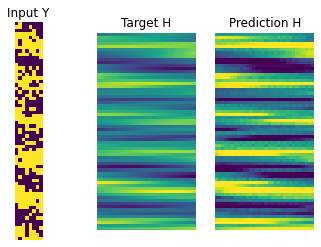

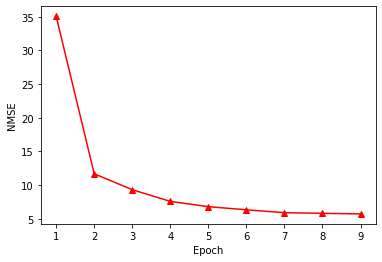

-----
EPOCH: 9
B/E: 0 / 9 , Generator loss: 15.227834 , Discriminator loss: 0.14138879 , time: 3:00:26.477067
B/E: 1 / 9 , Generator loss: 13.532665 , Discriminator loss: 0.40629715 , time: 3:00:27.272091
B/E: 2 / 9 , Generator loss: 13.100492 , Discriminator loss: 0.43969345 , time: 3:00:28.040165
B/E: 3 / 9 , Generator loss: 13.459973 , Discriminator loss: 0.23144922 , time: 3:00:28.790770
B/E: 4 / 9 , Generator loss: 11.364738 , Discriminator loss: 0.40164766 , time: 3:00:29.549359
B/E: 5 / 9 , Generator loss: 11.948205 , Discriminator loss: 0.36297068 , time: 3:00:30.336897
B/E: 6 / 9 , Generator loss: 15.175865 , Discriminator loss: 0.14285325 , time: 3:00:31.077021
B/E: 7 / 9 , Generator loss: 13.518686 , Discriminator loss: 0.14237022 , time: 3:00:31.910971
B/E: 8 / 9 , Generator loss: 13.798722 , Discriminator loss: 0.79619014 , time: 3:00:32.712483
B/E: 9 / 9 , Generator loss: 10.487937 , Discriminator loss: 1.1217701 , time: 3:00:33.507506
B/E: 10 / 9 , Generator loss: 17.859

B/E: 86 / 9 , Generator loss: 14.212435 , Discriminator loss: 0.7261972 , time: 3:01:30.711725
B/E: 87 / 9 , Generator loss: 11.369886 , Discriminator loss: 2.2370012 , time: 3:01:31.452846
B/E: 88 / 9 , Generator loss: 16.335533 , Discriminator loss: 1.1526886 , time: 3:01:32.177001
B/E: 89 / 9 , Generator loss: 12.813788 , Discriminator loss: 0.661823 , time: 3:01:32.907145
B/E: 90 / 9 , Generator loss: 16.951942 , Discriminator loss: 0.016763704 , time: 3:01:33.635791
B/E: 91 / 9 , Generator loss: 15.46057 , Discriminator loss: 0.64638805 , time: 3:01:34.376914
B/E: 92 / 9 , Generator loss: 12.364272 , Discriminator loss: 0.20189595 , time: 3:01:35.099073
B/E: 93 / 9 , Generator loss: 14.486208 , Discriminator loss: 0.47491962 , time: 3:01:35.859160
B/E: 94 / 9 , Generator loss: 9.952414 , Discriminator loss: 0.525186 , time: 3:01:36.595792
B/E: 95 / 9 , Generator loss: 11.6498785 , Discriminator loss: 0.51962006 , time: 3:01:37.334918
B/E: 96 / 9 , Generator loss: 12.378733 , Discr

B/E: 171 / 9 , Generator loss: 13.976859 , Discriminator loss: 0.98402053 , time: 3:02:33.507054
B/E: 172 / 9 , Generator loss: 14.781218 , Discriminator loss: 0.11133318 , time: 3:02:34.245682
B/E: 173 / 9 , Generator loss: 13.773854 , Discriminator loss: 0.34158152 , time: 3:02:34.979320
B/E: 174 / 9 , Generator loss: 14.5382 , Discriminator loss: 0.09265303 , time: 3:02:35.709462
B/E: 175 / 9 , Generator loss: 15.724335 , Discriminator loss: 0.018201657 , time: 3:02:36.458572
B/E: 176 / 9 , Generator loss: 12.822283 , Discriminator loss: 0.40629762 , time: 3:02:37.196200
B/E: 177 / 9 , Generator loss: 13.74483 , Discriminator loss: 0.34443435 , time: 3:02:37.920356
B/E: 178 / 9 , Generator loss: 11.057039 , Discriminator loss: 0.62136483 , time: 3:02:38.649501
B/E: 179 / 9 , Generator loss: 12.9406185 , Discriminator loss: 0.5027203 , time: 3:02:39.390624
B/E: 180 / 9 , Generator loss: 12.7443495 , Discriminator loss: 0.09162214 , time: 3:02:40.120768
B/E: 181 / 9 , Generator loss: 

B/E: 256 / 9 , Generator loss: 12.840777 , Discriminator loss: 0.3736487 , time: 3:03:36.369760
B/E: 257 / 9 , Generator loss: 13.216502 , Discriminator loss: 0.14084321 , time: 3:03:37.115375
B/E: 258 / 9 , Generator loss: 15.22534 , Discriminator loss: 0.07061069 , time: 3:03:37.836535
B/E: 259 / 9 , Generator loss: 14.917223 , Discriminator loss: 0.41413772 , time: 3:03:38.569673
B/E: 260 / 9 , Generator loss: 13.872202 , Discriminator loss: 0.092698425 , time: 3:03:39.313292
B/E: 261 / 9 , Generator loss: 12.968401 , Discriminator loss: 0.29870808 , time: 3:03:40.044433
B/E: 262 / 9 , Generator loss: 12.301118 , Discriminator loss: 0.10068348 , time: 3:03:40.771583
B/E: 263 / 9 , Generator loss: 16.736267 , Discriminator loss: 0.027747352 , time: 3:03:41.511208
B/E: 264 / 9 , Generator loss: 12.926535 , Discriminator loss: 0.09682873 , time: 3:03:42.243847
B/E: 265 / 9 , Generator loss: 15.573854 , Discriminator loss: 0.0135136545 , time: 3:03:42.966006
B/E: 266 / 9 , Generator los

B/E: 341 / 9 , Generator loss: 12.909221 , Discriminator loss: 0.1890351 , time: 3:04:39.187550
B/E: 342 / 9 , Generator loss: 14.790733 , Discriminator loss: 0.0428088 , time: 3:04:39.916695
B/E: 343 / 9 , Generator loss: 13.938278 , Discriminator loss: 0.05374239 , time: 3:04:40.646339
B/E: 344 / 9 , Generator loss: 15.10457 , Discriminator loss: 0.028112411 , time: 3:04:41.389458
B/E: 345 / 9 , Generator loss: 16.744207 , Discriminator loss: 0.025460899 , time: 3:04:42.118604
B/E: 346 / 9 , Generator loss: 12.901253 , Discriminator loss: 0.20025982 , time: 3:04:42.846252
B/E: 347 / 9 , Generator loss: 14.645083 , Discriminator loss: 0.21661666 , time: 3:04:43.582882
B/E: 348 / 9 , Generator loss: 15.279033 , Discriminator loss: 0.91691995 , time: 3:04:44.321512
B/E: 349 / 9 , Generator loss: 9.581746 , Discriminator loss: 5.2465997 , time: 3:04:45.048160
B/E: 350 / 9 , Generator loss: 14.094944 , Discriminator loss: 0.09059022 , time: 3:04:45.799264
B/E: 351 / 9 , Generator loss: 16

B/E: 426 / 9 , Generator loss: 11.769011 , Discriminator loss: 0.24552858 , time: 3:05:42.290308
B/E: 427 / 9 , Generator loss: 15.459418 , Discriminator loss: 0.25376546 , time: 3:05:43.030932
B/E: 428 / 9 , Generator loss: 12.683151 , Discriminator loss: 0.14504361 , time: 3:05:43.761077
B/E: 429 / 9 , Generator loss: 14.303594 , Discriminator loss: 0.04699443 , time: 3:05:44.494215
B/E: 430 / 9 , Generator loss: 12.593961 , Discriminator loss: 0.14620917 , time: 3:05:45.226353
B/E: 431 / 9 , Generator loss: 13.306649 , Discriminator loss: 0.08222906 , time: 3:05:45.961488
B/E: 432 / 9 , Generator loss: 13.051235 , Discriminator loss: 0.09051233 , time: 3:05:46.736049
B/E: 433 / 9 , Generator loss: 12.989144 , Discriminator loss: 0.33319193 , time: 3:05:47.503125
B/E: 434 / 9 , Generator loss: 17.221462 , Discriminator loss: 0.1910108 , time: 3:05:48.273692
B/E: 435 / 9 , Generator loss: 14.453685 , Discriminator loss: 0.07991527 , time: 3:05:49.010823
B/E: 436 / 9 , Generator loss: 

B/E: 511 / 9 , Generator loss: 13.922655 , Discriminator loss: 0.06411614 , time: 3:06:45.232366
B/E: 512 / 9 , Generator loss: 12.9999 , Discriminator loss: 0.96778095 , time: 3:06:45.960514
B/E: 513 / 9 , Generator loss: 12.066322 , Discriminator loss: 0.49019408 , time: 3:06:46.757034
B/E: 514 / 9 , Generator loss: 13.7917185 , Discriminator loss: 0.040880077 , time: 3:06:47.566530
B/E: 515 / 9 , Generator loss: 14.8972 , Discriminator loss: 0.047873266 , time: 3:06:48.359559
B/E: 516 / 9 , Generator loss: 14.457196 , Discriminator loss: 0.17181271 , time: 3:06:49.088204
B/E: 517 / 9 , Generator loss: 13.973933 , Discriminator loss: 0.026007196 , time: 3:06:49.825833
B/E: 518 / 9 , Generator loss: 13.983157 , Discriminator loss: 0.25028226 , time: 3:06:50.556475
B/E: 519 / 9 , Generator loss: 13.786412 , Discriminator loss: 0.1865777 , time: 3:06:51.318062
B/E: 520 / 9 , Generator loss: 16.004555 , Discriminator loss: 1.4508588 , time: 3:06:52.070163
B/E: 521 / 9 , Generator loss: 1

B/E: 596 / 9 , Generator loss: 14.246835 , Discriminator loss: 0.032332197 , time: 3:07:48.122022
B/E: 597 / 9 , Generator loss: 14.458364 , Discriminator loss: 0.030529514 , time: 3:07:48.876620
B/E: 598 / 9 , Generator loss: 15.130046 , Discriminator loss: 0.07060603 , time: 3:07:49.606764
B/E: 599 / 9 , Generator loss: 16.167458 , Discriminator loss: 0.020776633 , time: 3:07:50.342896
B/E: 600 / 9 , Generator loss: 16.128948 , Discriminator loss: 0.047025003 , time: 3:07:51.072042
B/E: 601 / 9 , Generator loss: 17.449446 , Discriminator loss: 0.2214598 , time: 3:07:51.816657
B/E: 602 / 9 , Generator loss: 14.850118 , Discriminator loss: 0.2828138 , time: 3:07:52.540313
B/E: 603 / 9 , Generator loss: 13.731891 , Discriminator loss: 0.083642885 , time: 3:07:53.282434
B/E: 604 / 9 , Generator loss: 13.86568 , Discriminator loss: 0.39002126 , time: 3:07:54.042522
B/E: 605 / 9 , Generator loss: 15.504499 , Discriminator loss: 1.1866105 , time: 3:07:54.792629
B/E: 606 / 9 , Generator loss

B/E: 681 / 9 , Generator loss: 14.313082 , Discriminator loss: 0.13031307 , time: 3:08:51.688420
B/E: 682 / 9 , Generator loss: 16.53976 , Discriminator loss: 0.056031417 , time: 3:08:52.426549
B/E: 683 / 9 , Generator loss: 13.80124 , Discriminator loss: 0.034048147 , time: 3:08:53.153698
B/E: 684 / 9 , Generator loss: 17.86857 , Discriminator loss: 0.024223171 , time: 3:08:53.876855
B/E: 685 / 9 , Generator loss: 18.398369 , Discriminator loss: 0.024560655 , time: 3:08:54.600509
B/E: 686 / 9 , Generator loss: 16.585505 , Discriminator loss: 0.36019236 , time: 3:08:55.345128
B/E: 687 / 9 , Generator loss: 13.253736 , Discriminator loss: 1.3622912 , time: 3:08:56.189559
B/E: 688 / 9 , Generator loss: 16.09296 , Discriminator loss: 0.42427185 , time: 3:08:57.044968
B/E: 689 / 9 , Generator loss: 12.272679 , Discriminator loss: 0.13497491 , time: 3:08:57.841989
B/E: 690 / 9 , Generator loss: 12.469207 , Discriminator loss: 0.19721188 , time: 3:08:58.616049
B/E: 691 / 9 , Generator loss: 

B/E: 766 / 9 , Generator loss: 13.959795 , Discriminator loss: 0.061878968 , time: 3:09:55.100105
B/E: 767 / 9 , Generator loss: 17.8111 , Discriminator loss: 0.34158424 , time: 3:09:55.835739
B/E: 768 / 9 , Generator loss: 11.111776 , Discriminator loss: 0.990237 , time: 3:09:56.563387
B/E: 769 / 9 , Generator loss: 17.697859 , Discriminator loss: 0.14948396 , time: 3:09:57.299020
B/E: 770 / 9 , Generator loss: 13.921715 , Discriminator loss: 0.095770456 , time: 3:09:58.087555
B/E: 771 / 9 , Generator loss: 18.798666 , Discriminator loss: 0.03413649 , time: 3:09:58.908531
B/E: 772 / 9 , Generator loss: 14.772152 , Discriminator loss: 0.255745 , time: 3:09:59.645660
B/E: 773 / 9 , Generator loss: 14.874531 , Discriminator loss: 0.11996828 , time: 3:10:00.417227
B/E: 774 / 9 , Generator loss: 14.404628 , Discriminator loss: 0.041120436 , time: 3:10:01.152361
B/E: 775 / 9 , Generator loss: 13.140719 , Discriminator loss: 0.20036492 , time: 3:10:01.902467
B/E: 776 / 9 , Generator loss: 14

B/E: 851 / 9 , Generator loss: 12.305897 , Discriminator loss: 0.15710905 , time: 3:10:58.353585
B/E: 852 / 9 , Generator loss: 13.370739 , Discriminator loss: 0.2516572 , time: 3:10:59.090217
B/E: 853 / 9 , Generator loss: 11.610641 , Discriminator loss: 0.29240143 , time: 3:10:59.829841
B/E: 854 / 9 , Generator loss: 15.086298 , Discriminator loss: 0.49321613 , time: 3:11:00.568470
B/E: 855 / 9 , Generator loss: 12.611211 , Discriminator loss: 0.37086707 , time: 3:11:01.343530
B/E: 856 / 9 , Generator loss: 15.460768 , Discriminator loss: 0.15011671 , time: 3:11:02.082157
B/E: 857 / 9 , Generator loss: 12.015055 , Discriminator loss: 0.90353453 , time: 3:11:02.824777
B/E: 858 / 9 , Generator loss: 18.085424 , Discriminator loss: 0.5946815 , time: 3:11:03.564404
B/E: 859 / 9 , Generator loss: 11.218428 , Discriminator loss: 0.23141699 , time: 3:11:04.293551
B/E: 860 / 9 , Generator loss: 12.462382 , Discriminator loss: 0.14638622 , time: 3:11:05.024192
B/E: 861 / 9 , Generator loss: 1

B/E: 936 / 9 , Generator loss: 10.756869 , Discriminator loss: 1.7594765 , time: 3:12:01.442869
B/E: 937 / 9 , Generator loss: 15.13947 , Discriminator loss: 0.24169454 , time: 3:12:02.214437
B/E: 938 / 9 , Generator loss: 12.624487 , Discriminator loss: 0.28218144 , time: 3:12:03.009957
B/E: 939 / 9 , Generator loss: 16.669865 , Discriminator loss: 0.018887714 , time: 3:12:03.787514
B/E: 940 / 9 , Generator loss: 13.45702 , Discriminator loss: 0.12831414 , time: 3:12:04.562573
B/E: 941 / 9 , Generator loss: 13.814924 , Discriminator loss: 0.10500237 , time: 3:12:05.327153
B/E: 942 / 9 , Generator loss: 12.482049 , Discriminator loss: 0.545824 , time: 3:12:06.065281
B/E: 943 / 9 , Generator loss: 10.960256 , Discriminator loss: 1.0083812 , time: 3:12:06.809399
B/E: 944 / 9 , Generator loss: 16.9516 , Discriminator loss: 0.1633773 , time: 3:12:07.528564
B/E: 945 / 9 , Generator loss: 17.378262 , Discriminator loss: 0.11724893 , time: 3:12:08.261203
B/E: 946 / 9 , Generator loss: 14.6174

B/E: 1021 / 9 , Generator loss: 12.288432 , Discriminator loss: 0.23702496 , time: 3:13:04.441323
B/E: 1022 / 9 , Generator loss: 15.945435 , Discriminator loss: 0.072139606 , time: 3:13:05.180949
B/E: 1023 / 9 , Generator loss: 15.19505 , Discriminator loss: 0.52261394 , time: 3:13:05.902109
B/E: 1024 / 9 , Generator loss: 13.486874 , Discriminator loss: 0.06397585 , time: 3:13:06.654212
B/E: 1025 / 9 , Generator loss: 13.997354 , Discriminator loss: 0.13145776 , time: 3:13:07.406814
B/E: 1026 / 9 , Generator loss: 16.675817 , Discriminator loss: 0.064002454 , time: 3:13:08.137456
B/E: 1027 / 9 , Generator loss: 12.25457 , Discriminator loss: 0.19358298 , time: 3:13:08.863606
B/E: 1028 / 9 , Generator loss: 19.021217 , Discriminator loss: 0.11615732 , time: 3:13:09.599240
B/E: 1029 / 9 , Generator loss: 13.296979 , Discriminator loss: 0.6768042 , time: 3:13:10.337868
B/E: 1030 / 9 , Generator loss: 9.8804 , Discriminator loss: 3.5824804 , time: 3:13:11.075996
B/E: 1031 / 9 , Generator

B/E: 1105 / 9 , Generator loss: 13.154374 , Discriminator loss: 0.09495573 , time: 3:14:06.939206
B/E: 1106 / 9 , Generator loss: 12.886355 , Discriminator loss: 0.19001739 , time: 3:14:07.673343
B/E: 1107 / 9 , Generator loss: 15.911055 , Discriminator loss: 0.78855085 , time: 3:14:08.436923
B/E: 1108 / 9 , Generator loss: 10.112184 , Discriminator loss: 0.9324209 , time: 3:14:09.175052
B/E: 1109 / 9 , Generator loss: 16.609463 , Discriminator loss: 0.20982203 , time: 3:14:09.918171
B/E: 1110 / 9 , Generator loss: 18.331238 , Discriminator loss: 0.023951968 , time: 3:14:10.665285
B/E: 1111 / 9 , Generator loss: 15.767849 , Discriminator loss: 0.06678254 , time: 3:14:11.408902
B/E: 1112 / 9 , Generator loss: 13.475825 , Discriminator loss: 0.09047316 , time: 3:14:12.143038
B/E: 1113 / 9 , Generator loss: 15.32702 , Discriminator loss: 0.03683102 , time: 3:14:12.868690
B/E: 1114 / 9 , Generator loss: 16.699821 , Discriminator loss: 0.04932661 , time: 3:14:13.599333
B/E: 1115 / 9 , Gener

B/E: 1189 / 9 , Generator loss: 15.1976795 , Discriminator loss: 3.1803484 , time: 3:15:09.448070
B/E: 1190 / 9 , Generator loss: 11.056256 , Discriminator loss: 2.1002529 , time: 3:15:10.171225
B/E: 1191 / 9 , Generator loss: 16.909586 , Discriminator loss: 0.09363535 , time: 3:15:10.934309
B/E: 1192 / 9 , Generator loss: 12.781958 , Discriminator loss: 0.4923733 , time: 3:15:11.675930
B/E: 1193 / 9 , Generator loss: 11.556381 , Discriminator loss: 0.43365195 , time: 3:15:12.413060
B/E: 1194 / 9 , Generator loss: 14.099629 , Discriminator loss: 0.07252542 , time: 3:15:13.161171
B/E: 1195 / 9 , Generator loss: 16.119234 , Discriminator loss: 0.19818246 , time: 3:15:13.895807
B/E: 1196 / 9 , Generator loss: 13.794846 , Discriminator loss: 0.14093512 , time: 3:15:14.617467
B/E: 1197 / 9 , Generator loss: 12.771912 , Discriminator loss: 0.075932086 , time: 3:15:15.353597
B/E: 1198 / 9 , Generator loss: 14.99638 , Discriminator loss: 0.081957586 , time: 3:15:16.082742
B/E: 1199 / 9 , Gener

B/E: 1273 / 9 , Generator loss: 15.216916 , Discriminator loss: 0.045219168 , time: 3:16:11.863107
B/E: 1274 / 9 , Generator loss: 15.076431 , Discriminator loss: 0.22051027 , time: 3:16:12.620200
B/E: 1275 / 9 , Generator loss: 14.503433 , Discriminator loss: 0.069783404 , time: 3:16:13.372802
B/E: 1276 / 9 , Generator loss: 14.727109 , Discriminator loss: 0.0649918 , time: 3:16:14.111929
B/E: 1277 / 9 , Generator loss: 14.740433 , Discriminator loss: 0.01813752 , time: 3:16:14.849557
B/E: 1278 / 9 , Generator loss: 14.721942 , Discriminator loss: 0.050059535 , time: 3:16:15.575708
B/E: 1279 / 9 , Generator loss: 14.175787 , Discriminator loss: 0.08099563 , time: 3:16:16.330806
B/E: 1280 / 9 , Generator loss: 17.168928 , Discriminator loss: 0.04044296 , time: 3:16:17.053463
B/E: 1281 / 9 , Generator loss: 19.963772 , Discriminator loss: 2.6961632 , time: 3:16:17.800574
B/E: 1282 / 9 , Generator loss: 10.663442 , Discriminator loss: 4.971079 , time: 3:16:18.518741
B/E: 1283 / 9 , Gener

B/E: 1357 / 9 , Generator loss: 14.189032 , Discriminator loss: 0.07230638 , time: 3:17:13.864912
B/E: 1358 / 9 , Generator loss: 14.624785 , Discriminator loss: 0.73783445 , time: 3:17:14.588567
B/E: 1359 / 9 , Generator loss: 11.81815 , Discriminator loss: 0.3065154 , time: 3:17:15.357639
B/E: 1360 / 9 , Generator loss: 16.312248 , Discriminator loss: 0.6301135 , time: 3:17:16.088780
B/E: 1361 / 9 , Generator loss: 14.498553 , Discriminator loss: 0.12996672 , time: 3:17:16.825910
B/E: 1362 / 9 , Generator loss: 13.184051 , Discriminator loss: 0.2634218 , time: 3:17:17.559547
B/E: 1363 / 9 , Generator loss: 16.21949 , Discriminator loss: 0.048547514 , time: 3:17:18.313646
B/E: 1364 / 9 , Generator loss: 15.515964 , Discriminator loss: 0.14530328 , time: 3:17:19.050277
B/E: 1365 / 9 , Generator loss: 13.868018 , Discriminator loss: 0.1999776 , time: 3:17:19.788407
B/E: 1366 / 9 , Generator loss: 16.717424 , Discriminator loss: 0.016734913 , time: 3:17:20.542006
B/E: 1367 / 9 , Generato

B/E: 1441 / 9 , Generator loss: 15.501406 , Discriminator loss: 0.026748361 , time: 3:18:16.020432
B/E: 1442 / 9 , Generator loss: 12.023272 , Discriminator loss: 0.11022562 , time: 3:18:16.748577
B/E: 1443 / 9 , Generator loss: 17.101892 , Discriminator loss: 0.019462029 , time: 3:18:17.516652
B/E: 1444 / 9 , Generator loss: 13.22119 , Discriminator loss: 0.08134965 , time: 3:18:18.249290
B/E: 1445 / 9 , Generator loss: 16.74707 , Discriminator loss: 0.011172753 , time: 3:18:18.998397
B/E: 1446 / 9 , Generator loss: 15.537245 , Discriminator loss: 0.06675005 , time: 3:18:19.746510
B/E: 1447 / 9 , Generator loss: 12.285401 , Discriminator loss: 0.19229776 , time: 3:18:20.518074
B/E: 1448 / 9 , Generator loss: 15.822249 , Discriminator loss: 0.076258644 , time: 3:18:21.249216
B/E: 1449 / 9 , Generator loss: 14.164852 , Discriminator loss: 0.16556104 , time: 3:18:21.983851
B/E: 1450 / 9 , Generator loss: 14.569917 , Discriminator loss: 0.053869084 , time: 3:18:22.715492
B/E: 1451 / 9 , G

B/E: 1525 / 9 , Generator loss: 10.410073 , Discriminator loss: 1.1675777 , time: 3:19:17.962846
B/E: 1526 / 9 , Generator loss: 14.233868 , Discriminator loss: 1.2905955 , time: 3:19:18.730420
B/E: 1527 / 9 , Generator loss: 12.62927 , Discriminator loss: 0.33151126 , time: 3:19:19.460563
B/E: 1528 / 9 , Generator loss: 12.881677 , Discriminator loss: 0.89995736 , time: 3:19:20.250097
B/E: 1529 / 9 , Generator loss: 15.371155 , Discriminator loss: 0.44010463 , time: 3:19:20.977747
B/E: 1530 / 9 , Generator loss: 12.916165 , Discriminator loss: 0.09908331 , time: 3:19:21.702896
B/E: 1531 / 9 , Generator loss: 15.167501 , Discriminator loss: 0.02911401 , time: 3:19:22.429049
B/E: 1532 / 9 , Generator loss: 14.5751095 , Discriminator loss: 0.3523662 , time: 3:19:23.181152
B/E: 1533 / 9 , Generator loss: 14.537586 , Discriminator loss: 0.057228938 , time: 3:19:23.918781
B/E: 1534 / 9 , Generator loss: 12.034577 , Discriminator loss: 0.37561274 , time: 3:19:24.656908
B/E: 1535 / 9 , Genera

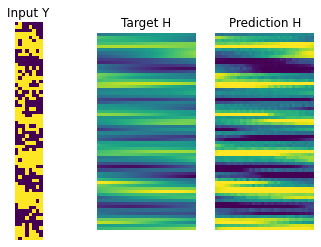

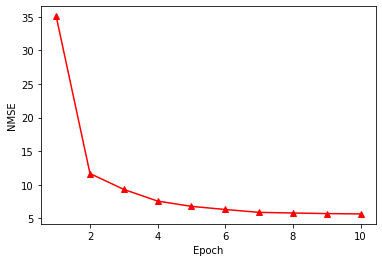

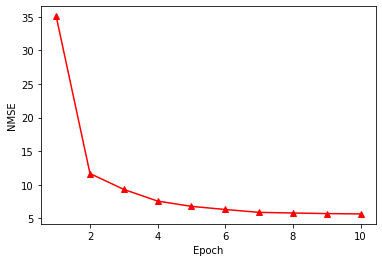

In [13]:
if __name__ == "__main__":

    # train
    nm, ep = train(epochs=10)
    
    plt.figure()
    plt.plot(ep,nm,'^-r')
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.show();
